# Titanic ML Pipeline: From Preprocessing to Model Evaluation  
## タイタニック機械学習パイプライン：前処理からモデル評価まで  

### 🧭 Introduction / はじめに  
The Titanic dataset is a classic introductory dataset for binary classification tasks in machine learning.  
In this notebook, I build a complete machine learning pipeline using multiple models (e.g., RandomForest, XGBoost, SVM), perform hyperparameter tuning, and analyze model interpretability with SHAP.

The final stacking model (with XGBoost as meta learner) achieved 83.6% accuracy and 87.4% ROC AUC in cross-validation.  
All steps are explained in both English and Japanese to make the content more accessible and educational.

---

タイタニック号のデータセットは、機械学習のバイナリ分類問題として有名な入門用課題です。  
このノートブックでは、ランダムフォレスト・XGBoost・SVM など複数のモデルを使って機械学習パイプラインを構築し、チューニングとSHAPを用いた解釈も行います。

最終的なスタッキングモデル（XGBoostをメタ学習器として使用）は、交差検証にて正解率83.6%、ROC AUC 87.4%を達成しました。  
すべてのステップには英語と日本語の説明を加えており、学習用・ポートフォリオ用の両方に役立つ内容となっています。



## 🎯 Objective  
- Predict passenger survival on the Titanic dataset  
タイタニック号の乗客の生存予測モデルを構築すること

- Build a reproducible and interpretable ML pipeline  
再現性・説明可能性の高い機械学習パイプラインを実装すること
---

## 📝 Contents  
1. 📥 Data Loading & Initial Exploration / データ読み込みと初期確認
2. 🔀 Data Preprocessing / データの前処理  
3. ♒ Baseline Modeling / ベースラインモデル構築
4. 🛠 Feature Engineering / 特徴量エンジニアリング
5. 🤖 Model Training & Tuning / モデル訓練とチューニング
6. 📊 Evaluation & Comparison / モデル評価と比較
7. 📤 Final Submission / 提出ファイルの作成   
8. 🎯 SHAP-Based Model Contribution (Meta Model: XGBoost) / SHAPによるベースモデルの貢献度分析  
9. 🔍 Final Model Analysis / 最終モデルの評価と考察  
10. 📌 Conclusion / 結論

---

## 🔧 Tools & Libraries

| Library             | Usage                                   |
| ------------------- | --------------------------------------- |
| pandas, numpy       | Data preprocessing / データ前処理             |
| matplotlib, seaborn | Visualization / 可視化                     |
| scikit-learn        | Modeling & Evaluation / モデルと評価          |
| xgboost, lightgbm   | High-performance ML algorithms / 高性能モデル |
| SHAP                | Model interpretability / モデルの解釈性        |

---

## 📌 Notes  
- Feature selection based on top 80% cumulative importance  
重要度の累積80%を基準に特徴量選定を行いました

- GridSearchCV & RandomizedSearchCV used for hyperparameter tuning  
パラメータ最適化にグリッド・ランダムサーチを使用

- Developed in Google Colab, dataset loaded from Google Drive  
Colab上で作成し、データはGoogle Driveから読み込み

---

## 💬 Feedback Welcome! / フィードバック歓迎
This notebook is a work in progress as I continue improving my skills.
ご意見・ご提案があれば、ぜひお寄せください！


## 📁 Data Access (Google Colab) / データの読み込み

Since this notebook was developed in Google Colab, the Titanic dataset was uploaded to Google Drive and loaded from there.  
このノートブックはGoogle Colab上で作成されたため、TitanicのデータセットはGoogle Driveにアップロードし、そこから読み込んでいます。

In [ ]:
# ① Mount Google Drive (for Colab users) / Google Driveのマウント（Colabユーザー向け）
from google.colab import drive
drive.mount('/content/drive')

# ② Set file path / パスを指定する
path = 'your/drive/path/to/data/'

# ③ Load training and test datasets / データの読み込み
import pandas as pd
df = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')

# ④ Preview the datasets
df.head()

Mounted at /content/drive


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


🔍 If you're running this on Kaggle or another local environment,
replace the path with the appropriate file location, such as /kaggle/input/titanic/.  
もしこれを Kaggle や他のローカル環境で実行している場合は、パスを適切なファイルの場所に置き換えてください。たとえば /kaggle/input/titanic/ などです。

In [ ]:
# 🔧 Basic Libraries / 基本ライブラリのインポート
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

# 📊 Visualization / 可視化ライブラリのインポート
import matplotlib.pyplot as plt
import seaborn as sns

# ⚙️ Preprocessing & Model Selection / 前処理およびモデル選定関連のライブラリ
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.base import clone
from sklearn.calibration import CalibratedClassifierCV

# 🤖 Classification Algorithms / 分類アルゴリズム
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb  # for Booster API if needed

# 📈 Evaluation Metrics & Tools / 評価指標およびツール
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import plot_tree
import time

# 🚫 Suppress Warnings / 警告の非表示設定
import warnings
warnings.filterwarnings('ignore')

✅ check data / データの中身を確認します。

In [ ]:
# Check data types and missing values / データと欠損値の確認
df.info()

# View summary statistics for numerical features / 数値特徴量の要約統計量を表示する
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# 1. Data Exploration / データ理解・探索
### 1.1 Check Missing Values / 欠損値の確認

We check the number of missing values for each feature in both training and test datasets to identify columns that need imputation or special handling.

訓練データとテストデータの各特徴量について、欠損値の数を確認します。これにより、補完や特別な処理が必要な列を特定します。

In [ ]:
df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [ ]:
df_test.isnull().sum()

,0
PassengerId,0
Pclass,0
Name,0
Sex,0
Age,86
SibSp,0
Parch,0
Ticket,0
Fare,1
Cabin,327


### 🔍 Missing Values / 欠損値の確認

We found missing values in the following columns:  
以下のカラムに欠損値が見つかりました：

- **Age**: Needs to be imputed. → Will fill with the median value.  
  **年齢**：補完が必要 → 中央値で補完します。

- **Cabin**: Many missing values. → Will drop or ignore this feature. Extract Deck (first letter) → Replace missing with 'U' (Unknown) → One-hot encode Deck → Create binary flag for Cabin presence → Drop original Cabin and Deck columns    
  **客室番号**：欠損が非常に多い → 先頭文字を抽出してDeckとして扱う → 欠損は'U'（不明）に置換 → Deckをダミー変数化 → Cabinの有無を示す2値特徴量を作成 → 元のCabinとDeck列を削除

- **Embarked**: 2 missing values. → Will fill with the most frequent value (mode).  
  **乗船地**：2件の欠損 → 最頻値で補完します。

- **Fare (in test set)**: 1 missing value. → Will fill with the median value.  
  **運賃（テストデータ）**：1件の欠損 → 中央値で補完します。


### 1.2 Visualizing Survival Rate / 生存率の可視化
Let's visualize the distribution of survivors and non-survivors in the dataset using both a pie chart and a count plot.

円グラフと棒グラフ（カウントプロット）を使って、生存者と非生存者の分布を可視化します。

This helps us understand the class balance in the target variable.

これにより、目的変数（Survived）のクラスのバランスを把握できます。

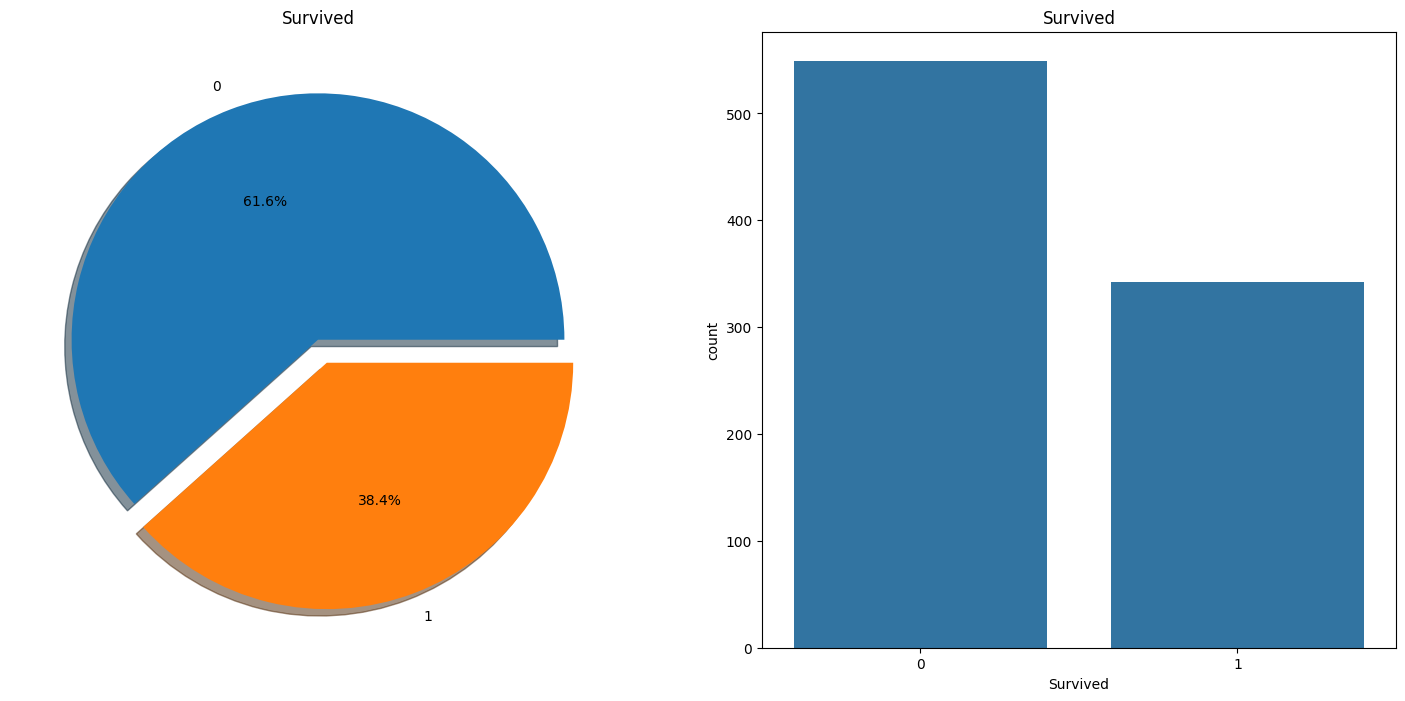

In [ ]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot(x = 'Survived',data=df,ax=ax[1])
ax[1].set_title('Survived')
plt.show()

### 🔍 What We Found / 見えてきたこと

- About **62%** of passengers did not survive, while **38%** survived.  
  約 **62%** の乗客が生存できず、**38%** が生存していました。
- The dataset is somewhat imbalanced, so using accuracy alone might be misleading.  
  データセットはやや不均衡であり、単純な精度だけでは評価に偏りが生じる可能性があります。
- Therefore, other metrics like ROC AUC and F1 score should also be considered.  
  このため、ROC AUC や F1スコアなどの指標の併用が重要になります。

## 1.3 Passenger Class Distribution and Survival by Class / 乗客クラスの分布とクラスごとの生存率

In this section, we explore how passengers are distributed among the three classes (`Pclass`).  
このセクションでは、乗客が3つのクラス（Pclass）にどのように分布しているかを確認します。

The bar chart on the left shows the number of passengers in each class.  
左の棒グラフは、各クラスに属する乗客の人数を示しています。

The count plot on the right breaks down survival status by class, giving us insight into survival trends per passenger class.  
右の棒蔵グラフでは、生存状況をクラスごとに分解して表示し、クラスによる生存傾向がわかります。

As we can see, passengers in 1st class had a higher chance of survival, while those in 3rd class faced lower survival rates.  
ご覧のとおり、1等船室の乗客は生存率が高く、3等船室の乗客は生存率が低い傾向にあります。

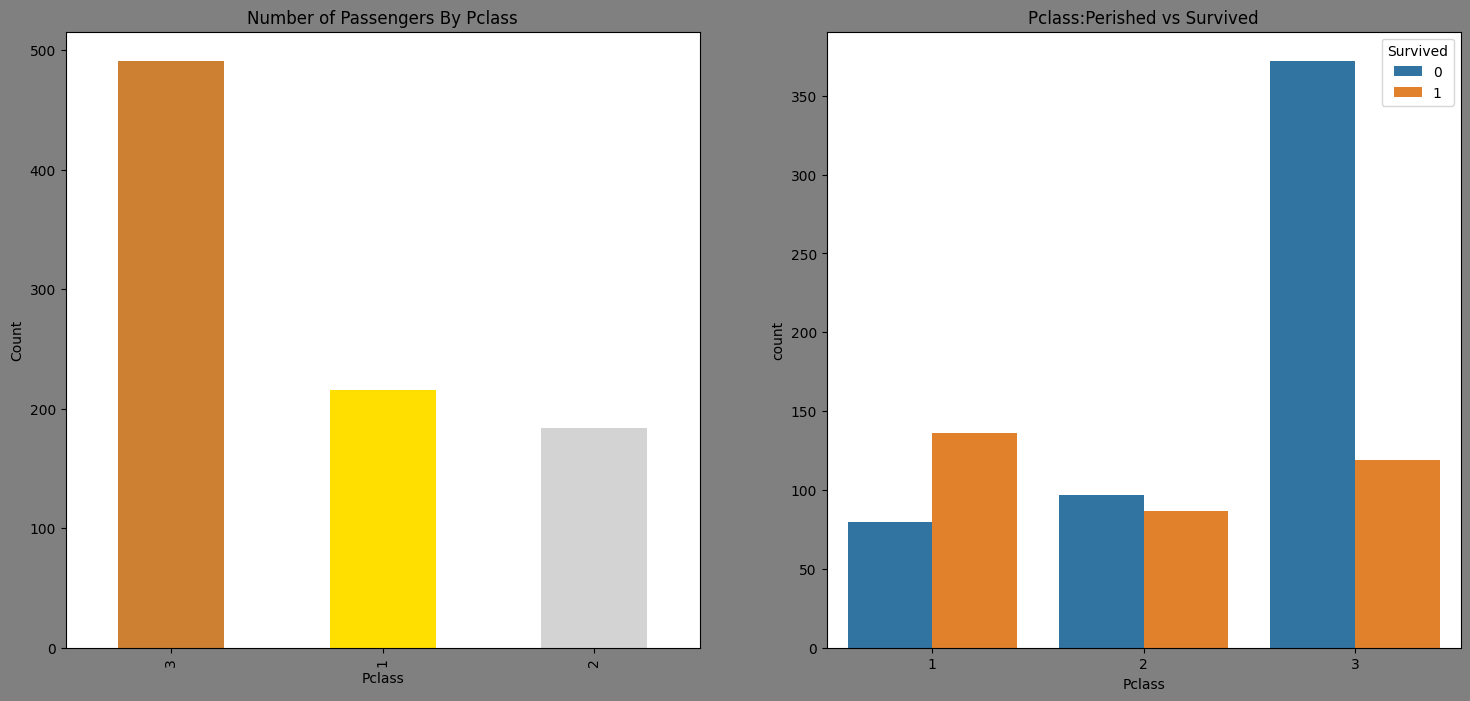

In [ ]:
f,ax=plt.subplots(1,2,figsize=(18,8), facecolor='gray')
df['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Number of Passengers By Pclass')
ax[0].set_ylabel('Count')
sns.countplot(x='Pclass',hue='Survived',data=df,ax=ax[1])
ax[1].set_title('Pclass:Perished vs Survived')
plt.show()

## 1.4 Survival Rate by Fare Group within Pclass 3 / 3等船室における運賃グループ別生存率

We select passengers in Pclass 3 and group them by fare quartiles to analyze survival rates.  
3等船室の乗客を抽出し、運賃の四分位数ごとにグループ分けして生存率を分析します。

The survival rates are calculated for each fare group to see if fare impacts survival within Pclass 3.  
各運賃グループごとに生存率を計算し、3等船室内で運賃が生存に影響を与えているかを確認します。

FareGroup
(-0.001, 7.75]    0.226562
(7.75, 8.05]      0.200000
(8.05, 15.5]      0.275510
(15.5, 69.55]     0.283333
Name: Survived, dtype: float64


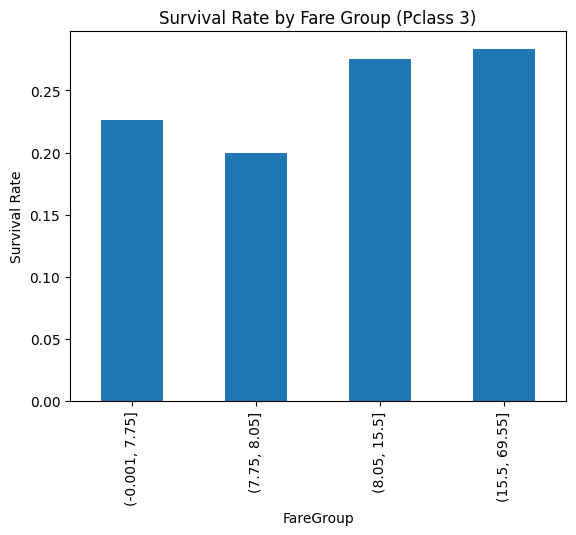

In [ ]:
# Select Pclass 3 passengers
pclass3 = df[df['Pclass'] == 3].copy()

# Create fare quartile groups
pclass3['FareGroup'] = pd.qcut(pclass3['Fare'], q=4)

# Calculate survival rate by FareGroup
survival_by_fare = pclass3.groupby('FareGroup')['Survived'].mean()

print(survival_by_fare)

# Optional: visualize survival rates by fare group
survival_by_fare.plot(kind='bar')
plt.title('Survival Rate by Fare Group (Pclass 3)')
plt.ylabel('Survival Rate')
plt.show()

### 🔍 What We Found / 見えてきたこと  
As shown in the plot, survival rates are similar across fare quartiles,  
indicating that fare does not significantly affect survival within Pclass 3.  
グラフの通り、運賃の四分位数ごとに生存率はほぼ同じであり、  
3等船室内では運賃が生存に大きな影響を与えていないことがわかります。


## 1.5 🚻 Survival Rate by Sex within Pclass 3 / 3等船室における性別ごとの生存率  
Next, we calculate survival rates by sex among passengers in Pclass 3.  
次に、3等船室の乗客について性別ごとの生存率を計算します。

This helps us understand how gender influenced survival chances within the lowest passenger class.  
これにより、最も下位の乗客クラス内で性別が生存率にどのように影響したかがわかります。

In [ ]:
# Calculate survival rate by sex within Pclass 3
survival_by_sex_pclass3 = pclass3.groupby('Sex')['Survived'].mean()
print(survival_by_sex_pclass3)

Sex
female    0.500000
male      0.135447
Name: Survived, dtype: float64


### 🔍 What We Found / 見えてきたこと  
The results show that females in Pclass 3 had a significantly higher survival rate compared to males.  
結果を見ると、3等船室の女性は男性に比べてかなり高い生存率を持っていることがわかります。

This reflects the "women and children first" evacuation policy practiced on the Titanic.  
これは、タイタニック号で実施された「女性と子供を先に救助する」方針を反映しています。

## 1.6 🎻 Visualizing Age Distribution by Pclass and Sex (Violin Plot) /        Pclass・性別ごとの年齢分布と生存状況の可視化  
We use violin plots to visualize the age distribution of passengers,  
split by survival status across different `Pclass` and `Sex` categories.  
バイオリンプロットを使って、乗客の年齢分布を生存状況ごとに表示します。  
ここでは `Pclass`（乗客クラス）と `Sex`（性別）ごとに分けています。

These plots help identify patterns in how age and other factors affect survival.  
このプロットによって、年齢や他の要素が生存率にどのように影響したかの傾向を視覚的に把握できます。

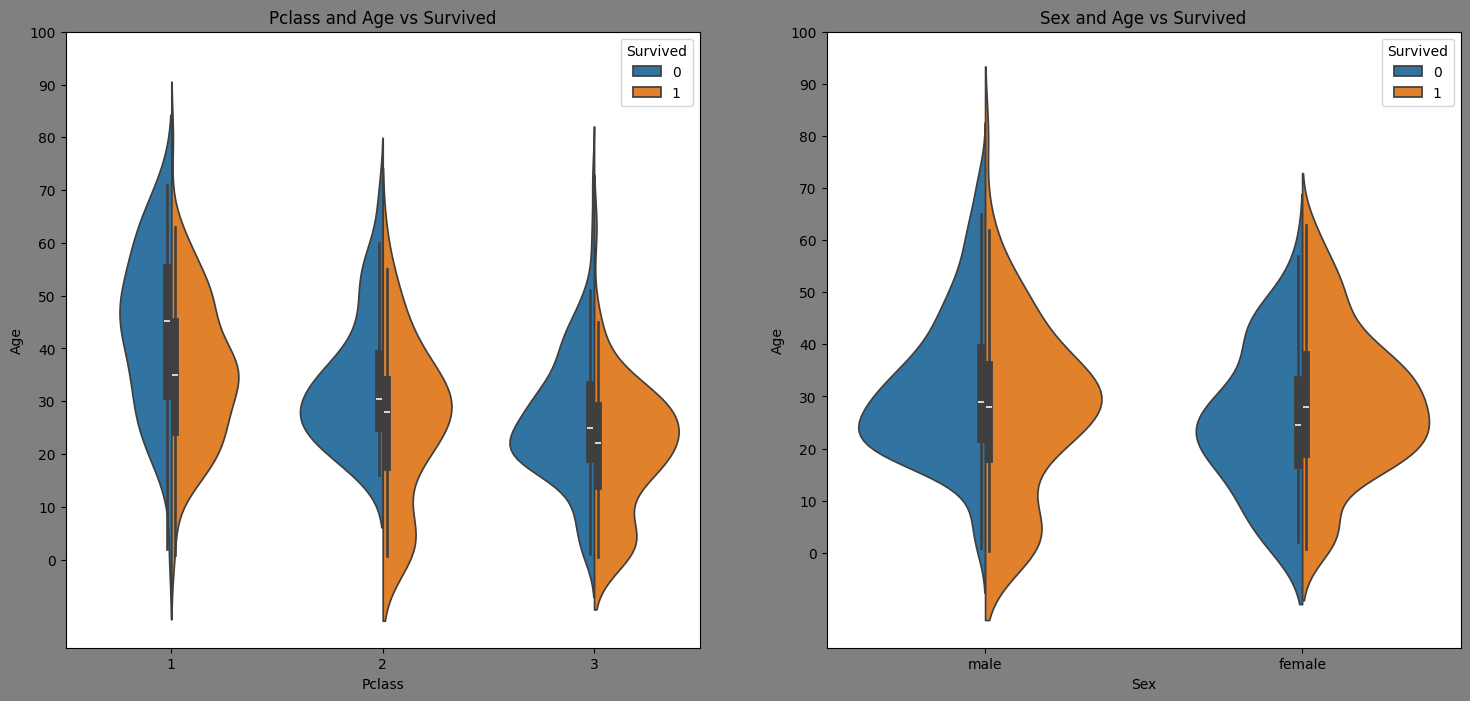

In [ ]:
# Create side-by-side violin plots
f, ax = plt.subplots(1, 2, figsize=(18, 8), facecolor='gray')

# Pclass × Age × Survived
sns.violinplot(x="Pclass", y="Age", hue="Survived", data=df, split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0, 110, 10))

# Sex × Age × Survived
sns.violinplot(x="Sex", y="Age", hue="Survived", data=df, split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0, 110, 10))

plt.show()

### 🔍 What We Found / 見えてきたこと  
In both plots, we observe that younger passengers (especially children) had higher survival rates,  
particularly in 1st and 2nd class, and among females.  
どちらのプロットでも、特に1等・2等船室や女性の中で、子ども（低年齢層）の生存率が高い傾向が見られます。

On the other hand, older male passengers in 3rd class had lower survival rates.  
一方で、3等船室の年配男性の生存率は低いことがわかります。

This visualization supports previous findings and reinforces the influence of class, gender, and age.  
この可視化は、これまでの分析結果を裏付け、クラス・性別・年齢の影響を再確認するものです。

We plot the average survival rate for each gender using a bar chart.  
性別ごとの平均生存率を棒グラフで可視化します。

This clearly shows that female passengers had a much higher survival rate than males.  
このグラフから、女性の方が生存率がはるかに高いことが明確にわかります。

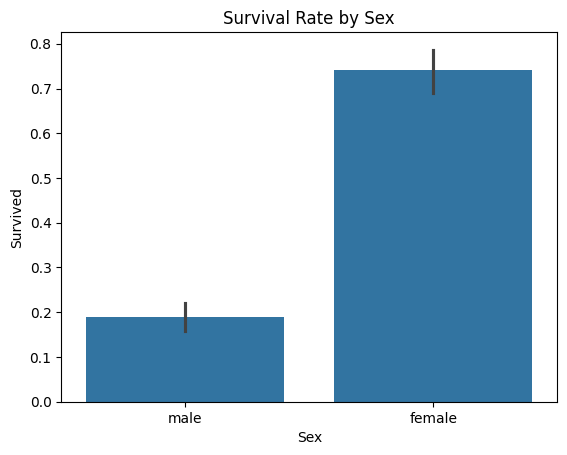

In [ ]:
sns.barplot(x='Sex', y='Survived', data=df)
plt.title("Survival Rate by Sex")
plt.show()

## 1.7 👶 Survival Rate of Children by Sex /                                   子ども（10歳未満）の生存率を性別ごとに確認  
We define a new column `Child` that marks passengers under 10 years old as 1, and others as 0.  
10歳未満の乗客を「子ども（Child = 1）」とし、それ以外を0として新しい列を作成します。

Then, we create a normalized crosstab to compare survival rates by `Child` and `Sex`.  
次に、`Child`と`Sex`の組み合わせで、生存率をクロス集計（正規化）します。


In [ ]:
# 子どもフラグを追加し、Child × Sex ごとの生存率をクロス集計
df.assign(Child = df['Age'].apply(lambda x: 1 if x < 10 else 0)) \
  .pipe(lambda d: pd.crosstab([d['Child'], d['Sex']], d['Survived'], normalize='index'))

Survived             0         1
Child Sex                       
0     female  0.246479  0.753521
      male    0.834862  0.165138
1     female  0.366667  0.633333
      male    0.406250  0.593750

### 🔍 What We Found / 見えてきたこと  
- **Adult women (Child = 0, female)** had the **highest survival rate** (75.4%), consistent with the "ladies first" policy.  
  （大人の女性は最も高い生存率を持っており、これは「女性優先」の原則と一致しています。）

- **Adult men (Child = 0, male)** had the **lowest survival rate** (16.5%), as expected.  
  （大人の男性の生存率は最も低く、予想通りの結果です。）

- **Child males** had a significantly **higher survival rate (59.4%)** than adult males.  
  （子どもの男性は大人の男性よりも大幅に高い生存率を示しています。）

- Interestingly, **child females** had a lower survival rate (63.3%) than **adult females** (75.4%).  
  （興味深いことに、女の子の生存率は大人の女性よりもやや低くなっています。）

This may be due to factors such as the location of cabins, family groups, or evacuation priority.  
（これは、キャビンの場所、家族単位の移動、避難の優先順位などが影響している可能性があります。）


## 1.8 🔥 Correlation Heatmap of Numerical Features / 数値特徴量の相関関係ヒートマップ  
We plot a correlation heatmap of all numerical features in the dataset.  
データセット内の数値型特徴量について、相関関係のヒートマップを描画します。

This helps identify which features are strongly related to each other or to the target variable (`Survived`).  
これにより、特徴量間、または目的変数（`Survived`）との強い関係があるものを見つけることができます。

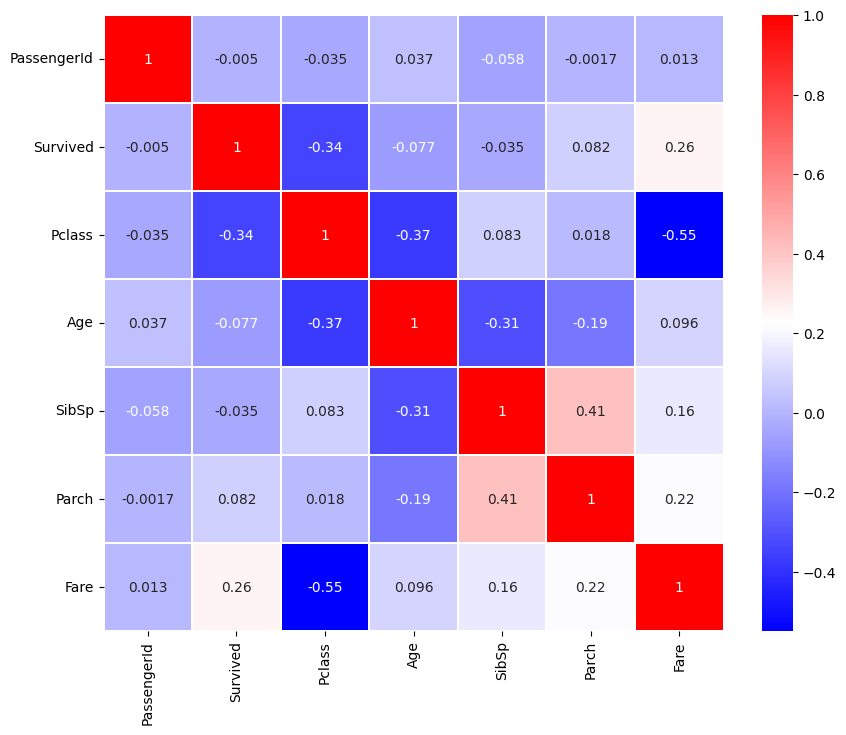

In [ ]:
# Select numeric columns only
df_numeric = df.select_dtypes(include=['number'])

# Plot heatmap of correlations
sns.heatmap(df_numeric.corr(), annot=True, cmap='bwr', linewidths=0.2)

# Set figure size
fig = plt.gcf()
fig.set_size_inches(10, 8)

plt.show()

### 🔍 What We Found / 見えてきたこと  
- `Fare` shows a moderate positive correlation with `Survived`.  
  `Fare`（運賃）は `Survived` と中程度の正の相関を持っています。

- `Pclass` has a negative correlation with `Survived`, indicating that higher classes had better survival chances.  
  `Pclass` は `Survived` と負の相関があり、高いクラス（1等）が生存しやすかったことを示しています。

- Some features like `SibSp` and `Parch` also have weak correlations, which might still be useful in combination.  
  `SibSp` や `Parch` のような特徴量も弱い相関を示しますが、他の特徴と組み合わせると有効な場合があります。

# 2 🧼 Data Preprocessing / データの前処理

Before training models, we need to clean and preprocess the dataset.  
This includes handling missing values, encoding categorical variables, and standardizing formats.  
モデルを訓練する前に、データセットの欠損値処理、カテゴリ変数のエンコーディング、フォーマットの統一などを行います。


📦 Backup the Preprocessed Data / 前処理済みデータのバックアップ  
We create backup copies of the preprocessed train and test datasets.  
前処理済みの訓練データとテストデータをバックアップとして保存しておきます。

This is useful when experimenting with feature engineering or trying different preprocessing strategies,  
as we can always revert to the original cleaned state.  
特徴量エンジニアリングや前処理方法を試す際に、元の状態に戻せるので便利です。

In [ ]:
df_base = df.copy() # baseline
df_base_test = df_test.copy()

We create backup copies of the preprocessed train and test datasets.  
前処理済みの訓練データとテストデータをバックアップとして保存しておきます。

This is useful when experimenting with feature engineering or trying different preprocessing strategies,  
as we can always revert to the original cleaned state.  
特徴量エンジニアリングや前処理方法を試す際に、元の状態に戻せるので便利です。


## 2.1 🧓 Age Imputation / Ageの補完

`Age` has a relatively large number of missing values.  
To ensure consistency between training and test data, we will fill the missing values using the **median age of the combined train and test datasets**.

`Age` には比較的多くの欠損値があります。  
訓練データとテストデータで一貫性を保つために、**訓練＋テスト全体の年齢の中央値**を使って補完します。


In [ ]:
# Combine train and test Age columns to calculate a consistent median
age = pd.concat([df_base['Age'],df_base_test['Age']])

# Fill missing Age values in both datasets with the same median
df_base['Age'] = df_base['Age'].fillna(age.median())
df_base_test['Age'] = df_base_test['Age'].fillna(age.median())

## 2.2 💰 Fare Imputation (Test Data) / Fareの補完（テストデータ）

The test dataset contains one missing value in the `Fare` column.  
Instead of using the overall median, we calculate the median `Fare` by passenger class (`Pclass`) and fill the missing value with the median of the corresponding class.

テストデータには `Fare` の欠損値が1件含まれています。  
単純に全体の中央値で補完するのではなく、乗客の等級（`Pclass`）ごとに `Fare` の中央値を計算し、  
該当する `Pclass` の中央値で補完することで、より妥当な推定を行います。

In [ ]:
# Calculate the median Fare for each Pclass from the training data
# 訓練データから Pclass ごとの Fare の中央値を計算
fare_per_class = df_base.groupby('Pclass')['Fare'].median()

# Apply class-specific median to fill missing Fare in the test data
# テストデータの欠損値に対して、対応する Pclass の中央値で補完
df_base_test['Fare'] = df_base_test.apply(
    lambda row: fare_per_class[row['Pclass']] if pd.isnull(row['Fare']) else row['Fare'],
    axis=1
)

## 2.3 🛳️ Cabin Feature Engineering / Cabin情報の特徴量変換

The `Cabin` column contains many missing values and detailed cabin numbers, which are difficult to use directly.  
We extract the first letter of each cabin as a new feature called `Deck`, since it may relate to passenger class or location on the ship.  
We also create a binary feature `Has_Cabin` that indicates whether cabin information was available.

`Cabin` 列には非常に多くの欠損があり、詳細なキャビン番号のままでは使用が難しいです。  
そのため、キャビンの最初の文字を `Deck` という新しい特徴量として抽出しました。これは、乗客の等級や船内での位置に関係している可能性があります。  
また、`Cabin` 情報の有無を示す2値の特徴量 `Has_Cabin` も作成しました（1: あり、0: なし）。

元の `Cabin` 列は使用しないため削除します。

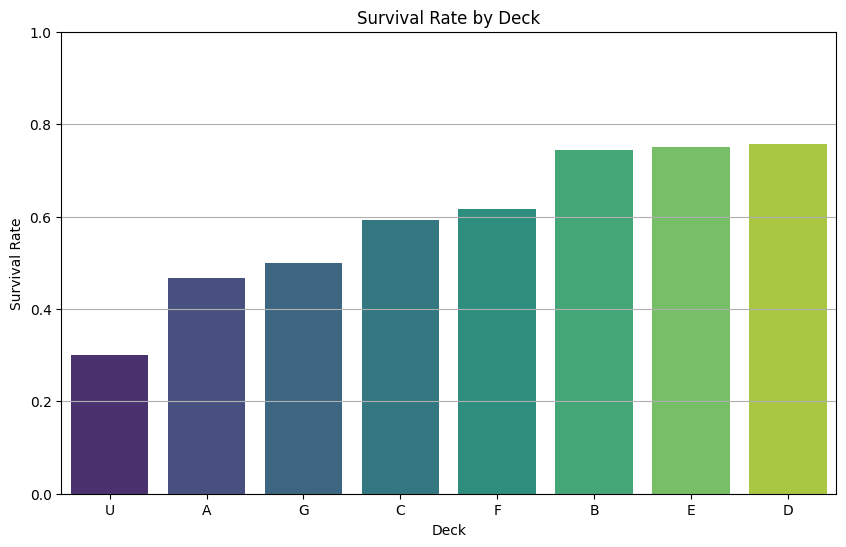

In [ ]:
# Extract the first letter from Cabin to represent Deck
# キャビンの先頭文字を取り出してDeckとして扱う。欠損は'U'（Unknown）に。
df_base['Deck'] = df_base['Cabin'].str[0].fillna('U')
df_base_test['Deck'] = df_base_test['Cabin'].str[0].fillna('U')

# Replace rare 'T' deck with 'U' (Unknown)
# 稀に存在する 'T' は情報が少ないため 'U' に統合
df_base['Deck'] = df_base['Deck'].replace('T', 'U')
df_base_test['Deck'] = df_base_test['Deck'].replace('T', 'U')

# Visualize survival rate by Deck
# Deckごとの生存率を表示して可視化
deck_survival = df_base.groupby('Deck')['Survived'].mean().sort_values().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=deck_survival, x='Deck', y='Survived', palette='viridis')
plt.title('Survival Rate by Deck')
plt.ylabel('Survival Rate')
plt.xlabel('Deck')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

In [ ]:
# Combine train and test Deck columns to create dummy variables
# 訓練データとテストデータのDeck列を連結し、ダミー変数化
all_decks = pd.concat([df_base['Deck'], df_base_test['Deck']], axis=0)
decks_ohe = pd.get_dummies(all_decks, prefix='Deck').astype(int)

# Split back to train and test datasets and concatenate
# 元の行数で分割して、それぞれのデータフレームに結合
df_base = pd.concat([
    df_base.reset_index(drop=True),
    decks_ohe.iloc[:len(df_base)].reset_index(drop=True)
], axis=1)

df_base_test = pd.concat([
    df_base_test.reset_index(drop=True),
    decks_ohe.iloc[len(df_base):].reset_index(drop=True)
], axis=1)

# Create a binary feature indicating whether Cabin info is available
# Cabin情報があったかどうかの2値特徴量（1: あり, 0: なし）
df_base['Has_Cabin'] = df_base['Cabin'].notnull().astype(int)
df_base_test['Has_Cabin'] = df_base_test['Cabin'].notnull().astype(int)

# Drop the original Cabin and Deck columns as they are no longer needed
# 元の Cabin と Deck の列は不要なので削除
df_base.drop(['Cabin', 'Deck'], axis=1, inplace=True)
df_base_test.drop(['Cabin', 'Deck'], axis=1, inplace=True)

## 2.5 ⚓ Embarked Imputation / Embarkedの欠損補完

The `Embarked` column has a few missing values.  
Since most passengers embarked from 'S' (Southampton),  
we fill missing values with 'S', the most frequent port.

`Embarked` 列には欠損値がいくつかあります。  
乗客の大多数が 'S'（サウサンプトン）から乗船しているため、  
欠損値は最頻値である 'S' で補完します。

### 2.5.1 ⚓ Visualization of Embarked Port Counts / Embarkedの乗船人数の可視化

This plot shows the distribution of passengers by their port of embarkation.  
It helps us understand the class imbalance and supports the decision to impute missing values with the most frequent port.

乗船地ごとの乗客数を示したグラフです。  
クラスの偏りを把握でき、欠損値を最頻値で補完する根拠の一つになります。

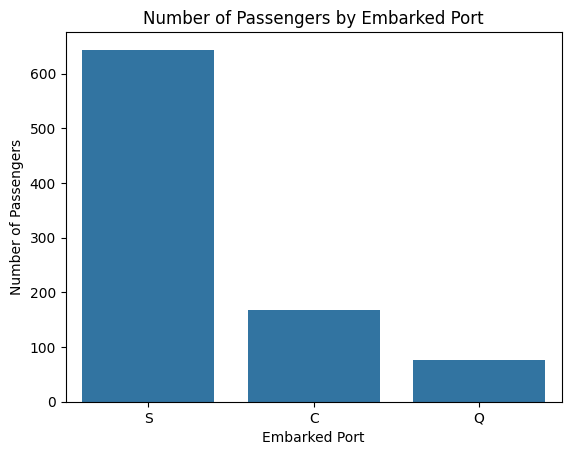

In [ ]:
# Visualize the count of passengers by Embarked port
# Embarkedごとの乗船人数をカウントプロットで表示
sns.countplot(x='Embarked', data=df_base)
plt.title('Number of Passengers by Embarked Port')
plt.xlabel('Embarked Port')
plt.ylabel('Number of Passengers')
plt.show()

### 2.5.2 Survival Rate by Embarked / Embarkedごとの生存率

The following bar plot shows the survival rates grouped by the port of embarkation (`Embarked`).  
Among the three main embarkation points — Southampton (S), Cherbourg (C), and Queenstown (Q) —  
passengers who boarded at Cherbourg (C) had the highest survival rate.

下の棒グラフは、乗船地 (`Embarked`) ごとの生存率を示しています。  
3つの主な乗船地、サウサンプトン (S)、シェルブール (C)、クイーンスタウン (Q) の中で、  
シェルブール (C) から乗船した乗客が最も高い生存率を示しました。

This indicates that embarkation point might be related to survival outcomes,  
possibly reflecting differences in passenger demographics or ticket classes.

このことは、乗船地が生存結果に関係している可能性があり、  
乗客の属性やチケットクラスの違いを反映しているかもしれません。

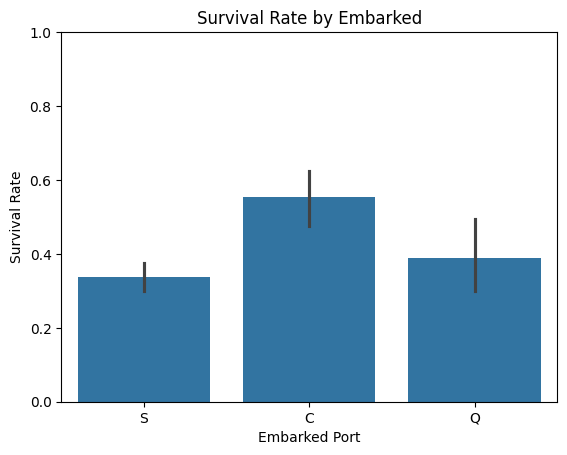

In [ ]:
# Visualize survival rate by Embarked port
# Embarkedごとの生存率を棒グラフで可視化
sns.barplot(x='Embarked', y='Survived', data=df_base)
plt.title('Survival Rate by Embarked')
plt.ylabel('Survival Rate')
plt.xlabel('Embarked Port')
plt.ylim(0, 1)
plt.show()

In [ ]:
# Fill missing Embarked values with the most frequent value 'S'
# Embarkedの欠損値を最頻値'S'で補完
df_base['Embarked'].fillna('S', inplace=True)
df_base.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [ ]:
df_base_test.isnull().sum()

,0
PassengerId,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0
Embarked,0


## 2.6 Categorical Data Preparation / カテゴリカルデータの準備

We have completed handling all missing values.  
Next, we will prepare categorical data so that models can handle them effectively.  

これで全ての欠損値処理が完了しました。  
次は、モデルが扱いやすいようにカテゴリカルデータの処理を行います。

### 2.6.1 Dropping Complex Text Features: Name and Ticket /  Name と Ticket の複雑な文字列特徴量を削除  
The categorical columns include `Name`, `Sex`, `Ticket`, `Embarked`, and `Pclass`.  
As a baseline, we will start by simply dropping the `Name` and `Ticket` columns since they are complex and not immediately useful.

カテゴリカル変数は `Name`, `Sex`, `Ticket`, `Embarked`, `Pclass` があります。  
今回はベースラインとして、複雑な `Name` と `Ticket` は簡単に削除します。


In [ ]:
# Drop 'Name' column (too detailed for baseline model)
# 'Name'列は複雑なのでベースラインでは削除
df_base.drop(['Name'], axis=1, inplace=True)
df_base_test.drop(['Name'], axis=1, inplace=True)

# Drop 'Ticket' column (too noisy for now)
# 'Ticket'列もベースラインでは情報が不明瞭なため削除
df_base.drop(['Ticket'], axis=1, inplace=True)
df_base_test.drop(['Ticket'], axis=1, inplace=True)

# Check remaining columns after drop
# 削除後のカラムを確認
df_base.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E',
       'Deck_F', 'Deck_G', 'Deck_U', 'Has_Cabin'],
      dtype='object')

### 2.6.2 Encoding Sex Column / Sex列のエンコーディング

The `Sex` column is a binary categorical variable.  
We convert it into numeric format by mapping `'male'` to `0` and `'female'` to `1`.  

This allows models to interpret the gender information as numerical input.

`Sex` 列は2値のカテゴリ変数です。  
`'male'` を `0`、`'female'` を `1` に変換することで、モデルが性別情報を数値として扱えるようにします。


In [ ]:
df_base['Sex'] = df_base['Sex'].map( {'male':0, 'female':1})
df_base_test['Sex'] = df_base_test['Sex'].map( {'male':0, 'female':1})

### 2.6.3 One-Hot Encoding for Embarked / Embarked列のOne-Hotエンコーディング  
The `Embarked` column contains three categories: `'S'`, `'C'`, and `'Q'`.  
To convert this categorical data into a format usable by machine learning models,  
we apply One-Hot Encoding and create separate binary columns for each port.

`Embarked` 列には `'S'`, `'C'`, `'Q'` の3つのカテゴリがあります。  
このカテゴリ変数を機械学習モデルで扱いやすくするため、  
One-Hot Encoding を適用し、それぞれの港に対応したバイナリ列を作成します。

We concatenate the training and test data before encoding to ensure consistency in the column order and structure.  
Then we split them back and merge with the original datasets.  
Finally, we drop the original `Embarked` column.

エンコーディングの前に訓練データとテストデータを連結することで、列の順序と構造の一貫性を保ちます。  
その後、元のデータセットに分割して結合し、`Embarked` 列は削除します。

In [ ]:
# Combine Embarked column from train and test to ensure consistent encoding
# 訓練・テストデータのEmbarked列を結合して、One-Hotの整合性を保つ
embarked = pd.concat([df_base['Embarked'], df_base_test['Embarked']])

# Apply One-Hot Encoding
# One-Hotエンコーディングを適用
embarked_ohe = pd.get_dummies(embarked).astype(int)

# Split back into train and test
# 訓練用とテスト用に分割
embarked_ohe_train = embarked_ohe[:len(df_base)]
embarked_ohe_test = embarked_ohe[len(df_base):]

# Add the encoded columns to the datasets
# エンコーディング結果を元データに結合
df_base = pd.concat([df_base, embarked_ohe_train], axis=1)
df_base_test = pd.concat([df_base_test, embarked_ohe_test], axis=1)

# Drop the original Embarked column
# 元のEmbarked列を削除
df_base.drop(columns=['Embarked'], inplace=True)
df_base_test.drop(columns=['Embarked'], inplace=True)

# Preview the result
# 処理後の先頭データを表示
df_base.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_U,Has_Cabin,C,Q,S
0,1,0,3,0,22.0,1,0,7.2500,0,0,0,0,0,0,0,1,0,0,0,1
1,2,1,1,1,38.0,1,0,71.2833,0,0,1,0,0,0,0,0,1,1,0,0
2,3,1,3,1,26.0,0,0,7.9250,0,0,0,0,0,0,0,1,0,0,0,1
3,4,1,1,1,35.0,1,0,53.1000,0,0,1,0,0,0,0,0,1,0,0,1
4,5,0,3,0,35.0,0,0,8.0500,0,0,0,0,0,0,0,1,0,0,0,1


### 2.6.4 One-Hot Encoding for Pclass / Pclass列のOne-Hotエンコーディング  
Although `Pclass` is already numeric (1, 2, 3),  
it is actually a categorical feature representing socio-economic class, not a continuous value.  

Therefore, we apply One-Hot Encoding to prevent the model from interpreting it as ordinal.

`Pclass` はすでに数値（1, 2, 3）として表現されていますが、  
これは連続値ではなく社会的階級を示すカテゴリ変数です。

そのため、モデルが誤って順序的な意味を持つと判断しないように、One-Hot Encoding を適用します。

As before, we concatenate train and test data first, encode, and then split them back.  
The original `Pclass` column is removed after encoding.

これまでと同様に、訓練データとテストデータを連結してエンコーディングを行い、  
その後分割して元のデータに結合します。エンコード後、`Pclass` 列は削除します。

In [ ]:
# Combine Pclass from train and test to ensure consistent encoding
# 訓練・テストのPclass列を結合して、One-Hotの整合性を保つ
pclass = pd.concat([df_base['Pclass'], df_base_test['Pclass']])

# Apply One-Hot Encoding
# One-Hotエンコーディングを適用（prefix付き）
pclass_ohe = pd.get_dummies(pclass, prefix='Pclass').astype(int)

# Split back into train and test
# 訓練用とテスト用に分割
pclass_ohe_train = pclass_ohe[:len(df_base)]
pclass_ohe_test = pclass_ohe[len(df_base):]

# Add encoded columns to original datasets
# エンコード結果を元データに追加
df_base = pd.concat([df_base, pclass_ohe_train], axis=1)
df_base_test = pd.concat([df_base_test, pclass_ohe_test], axis=1)

# Drop original Pclass column
# 元のPclass列を削除
df_base.drop(columns=['Pclass'], inplace=True)
df_base_test.drop(columns=['Pclass'], inplace=True)

# Check resulting columns
# 結果のカラム一覧を確認
df_base.columns

Index(['PassengerId', 'Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G',
       'Deck_U', 'Has_Cabin', 'C', 'Q', 'S', 'Pclass_1', 'Pclass_2',
       'Pclass_3'],
      dtype='object')

# 3. Baseline Modeling / ベースラインモデル構築

## 🤖 Preparing for Model Training / モデル構築に向けて

Through the preprocessing steps so far, all features have been converted into numeric values,  
and missing values have been appropriately handled.

ここまでの前処理により、全ての特徴量は数値化され、欠損値も適切に補完されました。  
この状態であれば、機械学習モデルにそのまま入力することが可能です。

---

In this section, we will start building a baseline model using Logistic Regression.  
To do so, we will first split the training data into training and validation sets.

このセクションでは、ロジスティック回帰を使ってベースラインモデルを構築していきます。  
まずは、訓練データを学習用と検証用に分割します。

## 📂 3.1 Preparing the Data / データの準備

We first separate the training data into features (`X`) and the target variable (`y`).  
The target column is `Survived`, which we want to predict.  
Therefore, we remove `Survived` from the feature set and assign it to `y`.

まず、訓練データを特徴量 (`X`) と目的変数 (`y`) に分けます。  
`Survived` は予測対象の変数であるため、`X` からは除外し、`y` に格納します。

## 🧪 3.2 Splitting the Data and Training a Baseline Model / 訓練データの分割とベースラインモデルの学習

We remove unnecessary columns such as `PassengerId` from the feature set.  
Then we split the data into training and validation sets (70% train / 30% validation)  
to evaluate the model's performance.

`PassengerId` など不要な列を除外した後、  
訓練データを学習用（70%）と検証用（30%）に分割して、  
モデルの性能を適切に評価できるようにします。

We use Logistic Regression as our baseline model.  
ロジスティック回帰をベースラインモデルとして使用します。

In [ ]:
# Feature matrix: drop PassengerId and Survived
# 特徴量行列（PassengerIdとSurvivedは除外）
X = df_base.drop(columns=['PassengerId', 'Survived'])

# Target variable
# 目的変数
y = df_base['Survived']

# Test data (for final prediction)
# 提出用のテストデータ（予測専用）
X_test = df_base_test.drop(columns=['PassengerId'])

# Split training data: 70% train, 30% validation
# 訓練データと検証データに分割（7:3）
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize Logistic Regression model
# ロジスティック回帰モデルを初期化
lr = LogisticRegression(max_iter=200, random_state=42)

# Train the model
# モデルを訓練
lr.fit(X_train, y_train)

LogisticRegression(max_iter=200, random_state=42)

## 📊 3.3 Baseline Model Performance / ベースラインモデルの精度評価

We evaluate the baseline Logistic Regression model using accuracy on both the training and validation sets.  
This gives us a rough idea of how well the model is learning and whether it is overfitting.  
Detailed metrics such as precision and recall will be used later when comparing multiple models.

ロジスティック回帰モデルを訓練データと検証データの両方で精度（Accuracy）を使って評価します。  
このスコアにより、モデルが過学習していないか、おおまかな性能を確認できます。

詳細な評価指標（precisionやrecallなど）は、後のモデル比較フェーズで使用します。

In [ ]:
# Evaluate model performance on training and validation sets
# 訓練データと検証データでの精度（Accuracy）を表示
print('Train Score: {}'.format(round(lr.score(X_train, y_train), 3)))
print(' Test Score: {}'.format(round(lr.score(X_valid, y_valid), 3)))

Train Score: 0.823
 Test Score: 0.806


# 4 🧱 特徴量エンジニアリング / Feature Engineering

本セクションでは、モデルの性能向上のために新しい特徴量を作成します。  
特に Titanic データでは、「名前」や「家族構成」から意味のある特徴を抽出できます。

In this section, we will create new features to improve the model's performance.  
In the Titanic dataset, features like "Name" and "Family composition" often provide useful information.

---

## 4.1 Family Size / 家族人数
We create a new feature called Family by adding the values of SibSp (number of siblings/spouses aboard), Parch (number of parents/children aboard), and 1 (the passenger themselves).  
SibSp（兄弟・配偶者の同乗人数）とParch（親・子供の同乗人数）、そして本人を足して、新しい特徴量Family（同乗家族人数）を作成します。

In [ ]:
df_fe = df_base.copy()       # Create a copy for feature engineering (training data) / ベースラインをコピーする
df_fe_test = df_base_test.copy()  # Create a copy for feature engineering (test data)

# Add new feature 'Family' by summing SibSp, Parch, and 1 (the passenger themselves) / 新しい特徴量　Familyを作成
df_fe['Family'] = df_fe['SibSp'] + df_fe['Parch'] + 1
df_fe_test['Family'] = df_fe_test['SibSp'] + df_fe_test['Parch'] + 1

df_fe.head()

,PassengerId,Survived,Sex,Age,SibSp,Parch,Fare,Deck_A,Deck_B,Deck_C,...,Deck_G,Deck_U,Has_Cabin,C,Q,S,Pclass_1,Pclass_2,Pclass_3,Family
0,1,0,0,22.0,1,0,7.2500,0,0,0,...,0,1,0,0,0,1,0,0,1,2
1,2,1,1,38.0,1,0,71.2833,0,0,1,...,0,0,1,1,0,0,1,0,0,2
2,3,1,1,26.0,0,0,7.9250,0,0,0,...,0,1,0,0,0,1,0,0,1,1
3,4,1,1,35.0,1,0,53.1000,0,0,1,...,0,0,1,0,0,1,1,0,0,2
4,5,0,0,35.0,0,0,8.0500,0,0,0,...,0,1,0,0,0,1,0,0,1,1


### 4.1.1 Baseline model with Family feature using Logistic Regression /  Family特徴量を含めたベースラインモデル（ロジスティック回帰）
We will now train a baseline model using Logistic Regression, including the newly added `Family` feature.  
We split the dataset into training and validation sets (70:30), then evaluate accuracy.

新たに作成した `Family` 特徴量を含めて、ロジスティック回帰でベースラインモデルを構築します。  
データセットを訓練データと検証データに 7:3 に分割し、正解率（Accuracy）を評価します。


In [ ]:
X_fe = df_fe.drop(columns=['PassengerId','Survived'])
y_fe = df_fe['Survived']

X_fe_test =  df_fe_test.drop(columns=['PassengerId'])

X_fe_train, X_fe_valid, y_fe_train, y_fe_valid = train_test_split(X_fe, y_fe, test_size=0.3, random_state=42)

lr_fe = LogisticRegression(max_iter=200, random_state=42)
lr_fe.fit(X_fe_train, y_fe_train)

print('Train Score: {}'.format(round(lr_fe.score(X_fe_train, y_fe_train), 3)))
print(' Test Score: {}'.format(round(lr_fe.score(X_fe_valid, y_fe_valid), 3)))

Train Score: 0.823
 Test Score: 0.806


### 4.1.2 Comparison of L1 and L2 Regularization / L1・L2正則化の比較  
Next, we apply **L1 and L2 regularization** to logistic regression and compare their performance.  
L1 regularization helps with feature selection by pushing some coefficients to zero.  
L2 regularization helps prevent overfitting by shrinking all coefficients.

次に、ロジスティック回帰に **L1（Lasso）とL2（Ridge）正則化** を適用し、それぞれの精度を比較します。  
L1正則化は一部の係数をゼロにすることで、特徴量選択に効果があります。  
L2正則化は全ての係数を小さくして、過学習を抑制します。

In [ ]:
# L1 正則化：penalty='l1', solver='liblinear'
score_l1 = cross_val_score(
    LogisticRegression(penalty='l1', solver='liblinear', C=0.5, max_iter=200, random_state=42),
    X_fe_train, y_fe_train, cv=5
).mean()

# L2 正則化：penalty='l2', solver='liblinear'
score_l2 = cross_val_score(
    LogisticRegression(penalty='l2', solver='liblinear', C=0.5, max_iter=200, random_state=42),
    X_fe_train, y_fe_train, cv=5
).mean()

print(f"L1 score: {score_l1:.3f}")
print(f"L2 score: {score_l2:.3f}")

L1 score: 0.809
L2 score: 0.812


### 4.1.3 🧮 Checking Feature Coefficients (Importance) in Logistic Regression / 特徴量の係数（重み）確認  
Let's now examine the **coefficients of the logistic regression model** to understand which features contribute the most to survival prediction.

ここでは、ロジスティック回帰モデルの **係数（重み）** を確認し、どの特徴量が生存予測に寄与しているかを見ていきます。

In [ ]:
# Save feature names / 特徴量名を保存
feature_names = df_fe.drop(columns=['PassengerId','Survived']).columns

# Get model coefficients / モデルの係数を取得
coef = lr_fe.coef_[0]

# Create DataFrame / 特徴量名と対応付けてDataFrameにする
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef
})

# Sort by absolute value / 絶対値の大きい順にソート
print(coef_df.sort_values(by='Coefficient', key=abs, ascending=False))

      Feature  Coefficient
0         Sex     2.527217
9      Deck_E     1.199697
11     Deck_G    -0.850731
18   Pclass_2     0.666413
7      Deck_C    -0.597087
12     Deck_U    -0.593168
19   Pclass_3    -0.576516
8      Deck_D     0.527554
13  Has_Cabin     0.517274
16          S    -0.406215
14          C     0.355488
6      Deck_B     0.310201
10     Deck_F     0.159281
2       SibSp    -0.150027
15          Q     0.117968
20     Family    -0.104250
5      Deck_A    -0.088506
1         Age    -0.030906
17   Pclass_1    -0.022655
3       Parch    -0.021464
4        Fare     0.005798


### 🔍 What We Found / 見えてきたこと
From the sorted coefficients, we can see the most influential features.  
In particular:

- `Sex` has the largest coefficient → gender is the strongest predictor of survival.
- Some deck-related features like `Deck_E`, `Deck_G`, and `Deck_C` also have large weights.
- `Family`, the new feature we added, has a small coefficient (≈ -0.11), suggesting its impact is limited in the current model.

ソートされた係数から、最も影響の大きい特徴量がわかります。

- `Sex`（性別）が最も大きな係数 → 生存率予測に最も強く寄与
- `Deck_E` や `Deck_G` など、客室階層の特徴も高い影響度
- 新たに追加した `Family` は係数が小さく（約 -0.11）、このモデルでは影響が限定的である可能性
---
#### ❓ Why is the impact of `Family` small?

The `Family` feature may show low importance for several reasons:

- The effect of `Family` might be **nonlinear**: both solo travelers and large families may have lower survival rates.
- Logistic regression, being a linear model, may not capture such nonlinear effects well.

You may consider the following approaches:

- Using `FamilySize` bins (e.g., Small, Medium, Large)
- Adding interaction terms
- Switching to tree-based models (e.g., RandomForest)

---

#### ❓ `Family` の影響が小さい理由は？

`Family` の影響が小さく見えるのは、以下のような理由が考えられます：

- `Family` と生存率の関係が **非線形** の可能性があります。例えば、1人旅や大家族では生存率が低い傾向があるかもしれません。
- ロジスティック回帰のような線形モデルでは、こうした非線形の影響をうまく捉えられないことがあります。

対応策として、以下のような工夫が考えられます：

- `FamilySize` をカテゴリ化する（例：1人＝Solo、2–4人＝Medium、5人以上＝Large）
- 他の特徴量との交互作用項を追加する
- 非線形の関係を捉えやすい木系モデル（例：RandomForest）に切り替える


### 4.1.4  Model with Random Forest Classifier  
We now train a **Random Forest classifier** using the same features including `Family`, and compare its performance with logistic regression.
Random Forest is a tree-based ensemble model, which can capture **nonlinear relationships and feature interactions** better than logistic regression.
This allows features like `Family`, which might have a nonlinear effect, to contribute more effectively.  

---

ランダムフォレスト分類器を使用して、`Family` を含む特徴量でモデルを学習し、ロジスティック回帰との性能比較を行います。    
ランダムフォレストは木構造に基づくアンサンブル学習モデルであり、
非線形な関係性や特徴量間の相互作用をロジスティック回帰よりも適切に捉えることができます。    
そのため、`Family` のような非線形な影響を持つ特徴量が効果的に働く可能性があります。

In [ ]:
# Train Random Forest / ランダムフォレストの学習
rfc_fe = RandomForestClassifier(
    max_depth=6, min_samples_leaf=5, n_estimators=100,
    n_jobs=-1, random_state=42
)
rfc_fe.fit(X_fe_train, y_fe_train)

# Print accuracy / 精度表示
print('Train Score: {}'.format(round(rfc_fe.score(X_fe_train, y_fe_train), 3)))
print(' Test Score: {}'.format(round(rfc_fe.score(X_fe_valid, y_fe_valid), 3)))

Train Score: 0.859
 Test Score: 0.799


### 🔍 What We Found / 見えてきたこと
From the above comparison, we can observe the following:

- **L2-regularized logistic regression** showed the best validation performance (CV ≈ 0.812).
- **Random Forest** slightly overfits: higher train score (0.859) but lower validation score (0.799).
- **L1-regularized logistic regression** performed slightly worse, suggesting that some weak features might be useful.

これらの比較から、以下のような示唆が得られます：

- **L2正則化ロジスティック回帰** が最も高い検証スコア（CV ≈ 0.812）を記録しました。
- **ランダムフォレスト** は学習スコアが高い一方で、検証スコアがやや低下しており、やや過学習気味です。
- **L1正則化** の精度はわずかに劣り、一部の弱い特徴も実は有効だった可能性があります。
---

## 4.2 Extracting Titles from Names / 敬称（Title）の抽出
We extract **titles (e.g., Mr, Mrs, Miss)** from the `Name` column using regular expressions.  
These titles can represent social status, gender, or age group, and may be useful for prediction.

`Name` 列から敬称（例：Mr, Mrs, Missなど）を正規表現を用いて抽出します。  
敬称は社会的地位・性別・年齢層などを表す可能性があり、予測に役立つことがあります。

In [ ]:
df_fe1 = df_fe.copy() ## + Title features
df_fe1_test = df_fe_test.copy()

In [ ]:
import re

# Function to extract title / 敬称（Title）を抽出する関数
def extract_title(name):
    title_search = re.search(r' ([A-Za-z]+)\.', name)  # Match pattern like " Mr." / 「空白＋英字＋ドット」にマッチさせる
    if title_search:
        return title_search.group(1)  # Return only the title part / 敬称の部分のみ返す
    return ""  # Return empty string if no match / 敬称が見つからなかった場合は空文字を返す

# Combine train and test data (need Name column) / 訓練・テストデータを結合（Name列が必要）
all_name = pd.concat([df, df_test], axis=0)

# Apply the function to extract Title from Name / NameからTitleを抽出して新しい列を作成
all_name['Title'] = all_name['Name'].apply(extract_title)

# Check unique titles extracted / 抽出された敬称のユニーク値を確認
print(all_name['Title'].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer' 'Dona']


### 4.2.1 🔍 Count Title Frequency / 敬称の出現回数をカウントする
We count how frequently each title appears.  
This helps us identify **rare titles** that should be grouped into a single category (e.g., 'Rare').

各敬称の出現回数を確認することで、  
**出現数が少ないレアな敬称** を見つけ、1つのカテゴリ（'Rare'）にまとめるための準備ができます。

In [ ]:
# Count how many times each title appears / 各敬称の出現回数をカウント
title_counts = all_name['Title'].value_counts()
print(title_counts)

Title
Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Major         2
Mlle          2
Ms            2
Mme           1
Don           1
Sir           1
Lady          1
Capt          1
Countess      1
Jonkheer      1
Dona          1
Name: count, dtype: int64


### 4.2.2 🎩 Title Feature Cleaning & One-Hot Encoding / 敬称（Title）の整形とエンコーディング  
We clean and group the extracted `Title` values from the Name column.  
Some titles are equivalent (e.g., 'Mlle' ≈ 'Miss'), and rare titles are grouped as 'Rare' to reduce dimensionality.  
Afterward, we perform one-hot encoding and merge them back into the training and test datasets.

`Name`列から抽出した`Title`（敬称）を整形し、  
同義のものを統合（例：'Mlle' ≈ 'Miss'）し、出現頻度の少ない敬称は 'Rare' にまとめて次元数を減らします。  
その後、ワンホットエンコーディングを行い、訓練／テストデータに結合します。

In [ ]:
# 一部の敬称を統合
all_name['Title'] = all_name['Title'].replace({
    'Mlle': 'Miss',
    'Ms': 'Miss',
    'Mme': 'Mrs'
})

# 頻度を再計算
title_counts = all_name['Title'].value_counts()

# 出現頻度が少ない敬称を「Rare」として統合
rare_titles = title_counts[title_counts < 10].index       #10未満のインデックスの値（敬称の名前）だけを取り出す

all_name['Title'] = all_name['Title'].replace(rare_titles, 'Rare')

# 敬称のダミー変数化をし、ダミー変数をTrue/Falseから0/1に変換
title_ohe = pd.get_dummies(all_name['Title'], prefix='Title').astype(int)

# df_fe1/df_fe1_test に行数を合わせて結合
df_fe1 = pd.concat([
    df_fe1.reset_index(drop=True),
    title_ohe.iloc[:len(df)].reset_index(drop=True)
], axis=1)

df_fe1_test = pd.concat([
    df_fe1_test.reset_index(drop=True),
    title_ohe.iloc[len(df):].reset_index(drop=True)
], axis=1)

In [ ]:
df_fe1.head()

,PassengerId,Survived,Sex,Age,SibSp,Parch,Fare,Deck_A,Deck_B,Deck_C,...,S,Pclass_1,Pclass_2,Pclass_3,Family,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,1,0,0,22.0,1,0,7.2500,0,0,0,...,1,0,0,1,2,0,0,1,0,0
1,2,1,1,38.0,1,0,71.2833,0,0,1,...,0,1,0,0,2,0,0,0,1,0
2,3,1,1,26.0,0,0,7.9250,0,0,0,...,1,0,0,1,1,0,1,0,0,0
3,4,1,1,35.0,1,0,53.1000,0,0,1,...,1,1,0,0,2,0,0,0,1,0
4,5,0,0,35.0,0,0,8.0500,0,0,0,...,1,0,0,1,1,0,0,1,0,0


In [ ]:
df_fe1_test.head()

,PassengerId,Sex,Age,SibSp,Parch,Fare,Deck_A,Deck_B,Deck_C,Deck_D,...,S,Pclass_1,Pclass_2,Pclass_3,Family,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,892,0,34.5,0,0,7.8292,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0
1,893,1,47.0,1,0,7.0000,0,0,0,0,...,1,0,0,1,2,0,0,0,1,0
2,894,0,62.0,0,0,9.6875,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
3,895,0,27.0,0,0,8.6625,0,0,0,0,...,1,0,0,1,1,0,0,1,0,0
4,896,1,22.0,1,1,12.2875,0,0,0,0,...,1,0,0,1,3,0,0,0,1,0


### 4.2.3 🤖 Logistic Regression with Title Feature / 敬称を加えたロジスティック回帰モデル  
We now retrain the logistic regression model using the dataset that includes the newly added `Title` features.  
This allows us to check whether including titles improves model performance.

新たに追加した `Title` 特徴量を含めたデータセットを用いて、ロジスティック回帰モデルを再学習します。  
これにより、敬称の追加がモデル性能を改善するかどうかを確認します。

In [ ]:
# Separate features and target / 説明変数と目的変数を分割
X_fe1 = df_fe1.drop(columns=['PassengerId', 'Survived'])
y_fe1 = df_fe1['Survived']

X_fe1_test = df_fe1_test.drop(columns=['PassengerId'])

# Split into training and validation sets / 訓練・検証データに分割
X_fe1_train, X_fe1_valid, y_fe1_train, y_fe1_valid = train_test_split(
    X_fe1, y_fe1, test_size=0.3, random_state=42
)

# Train logistic regression / ロジスティック回帰モデルの学習
lr_fe1 = LogisticRegression(max_iter=200, random_state=42)
lr_fe1.fit(X_fe1_train, y_fe1_train)

# Accuracy on train and validation / 訓練・検証スコアを表示
print('Train Score: {}'.format(round(lr_fe1.score(X_fe1_train, y_fe1_train), 3)))
print(' Test Score: {}'.format(round(lr_fe1.score(X_fe1_valid, y_fe1_valid), 3)))

Train Score: 0.854
 Test Score: 0.821


Adding the `Title` feature improved the model's validation score from 0.812 to 0.821.  
This suggests that **titles carry meaningful information** related to passenger survival — such as gender, age group, and social status.

`Title` 特徴量を追加することで、検証スコアが 0.812 → 0.821 に改善されました。  
これは、敬称が性別・年齢層・社会的地位など、**生存に関係する有益な情報を含んでいる**ことを示唆しています。


### 4.2.4🌲 Random Forest with Title Feature / 敬称を加えたランダムフォレスト  
We retrain the Random Forest model using the updated dataset that includes the `Title` features.  
This allows us to compare its performance with logistic regression and see whether nonlinear models benefit more from the new features.

`Title` を含めた更新済みのデータセットを使って、ランダムフォレストモデルを再学習します。  
ロジスティック回帰との比較や、非線形モデルがこの特徴量の恩恵をより受けるかを確認します。

In [ ]:
# Train Random Forest with Title features / Titleを加えたデータでRF学習
rfc_fe1 = RandomForestClassifier(
    max_depth=6, min_samples_leaf=5,
    n_estimators=100, n_jobs=-1, random_state=42
)
rfc_fe1.fit(X_fe1_train, y_fe1_train)

# Accuracy / 精度
print('Train Score: {}'.format(round(rfc_fe1.score(X_fe1_train, y_fe1_train), 3)))
print(' Test Score: {}'.format(round(rfc_fe1.score(X_fe1_valid, y_fe1_valid), 3)))

Train Score: 0.867
 Test Score: 0.817


### 🔍 What We found / 見えてきたこと  
Both models improved with the addition of the `Title` feature.  
Logistic Regression slightly outperforms Random Forest on the validation score (0.821 vs 0.817),  
but Random Forest has a higher training score, which may suggest mild overfitting.

両モデルとも、`Title` 特徴量の追加によってスコアが改善しました。  
検証スコアではロジスティック回帰がわずかに優れています（0.821 vs 0.817）が、  
ランダムフォレストは訓練スコアが高く、やや過学習の兆候があるかもしれません。

## 4.3 Ticket Feature / チケットの処理
We examine the `Ticket` feature to extract useful information.  
Ticket numbers often contain prefixes that indicate ticket type or cabin location, which might affect survival rates.

`Ticket`（チケット番号）を調査し、そこから有益な情報を抽出します。  
チケット番号にはプレフィックス（接頭辞）が含まれていることが多く、これがチケットの種類やキャビンの位置を示し、生存率に影響する可能性があります。

In [ ]:
df_fe2 = df_fe1.copy() ## + Ticket features
df_fe2_test = df_fe1_test.copy()

### 4.3.1 Count Title Frequency / 敬称の出現回数をカウントする

In [ ]:
# Show the most common Ticket values / チケット番号の頻出値を表示
print(df['Ticket'].value_counts().head())

Ticket
347082      7
1601        7
CA. 2343    7
3101295     6
CA 2144     6
Name: count, dtype: int64


### 4.3.2 🎟️ Ticket Group Size Feature / チケットからグループサイズを抽出  


In [ ]:
# Combine training and test data to compute ticket frequencies / チケットの出現回数を全体で計算
all_data = pd.concat([df, df_test], axis=0)
ticket_counts = all_data['Ticket'].value_counts()

# Map the ticket count to each passenger / 各乗客にチケットの人数を割り当てる
df_fe2['TicketGroupSize'] = df['Ticket'].map(ticket_counts).fillna(1)
df_fe2_test['TicketGroupSize'] = df_test['Ticket'].map(ticket_counts).fillna(1)

# Limit maximum group size to 8 to avoid outliers / 外れ値の影響を避けるため、最大を8に制限
df_fe2['TicketGroupSize'] = df_fe2['TicketGroupSize'].clip(upper=8)
df_fe2_test['TicketGroupSize'] = df_fe2_test['TicketGroupSize'].clip(upper=8)

# Create binary feature: Is the passenger in a group? / グループに属しているか（2人以上）
df_fe2['IsGroup'] = (df_fe2['TicketGroupSize'] > 1).astype(int)
df_fe2_test['IsGroup'] = (df_fe2_test['TicketGroupSize'] > 1).astype(int)

# Check survival rate by ticket group size / TicketGroupSizeごとの生存率を確認
print(df_fe2[['TicketGroupSize', 'Survived']].groupby('TicketGroupSize').mean())

                 Survived
TicketGroupSize          
1                0.270270
2                0.513812
3                0.653465
4                0.727273
5                0.333333
6                0.210526
7                0.208333
8                0.250000


 ### 📊 4.3.3 Ticket Group Size Distribution / チケットグループサイズの分布  
 We plot the distribution of `TicketGroupSize` to understand how common different group sizes are among passengers.  
This helps us verify whether most people traveled alone or with others.

`TicketGroupSize`（チケットを共有する人数）の分布を可視化することで、  
乗客が一人旅なのか複数人で行動していたのかの傾向を把握します。

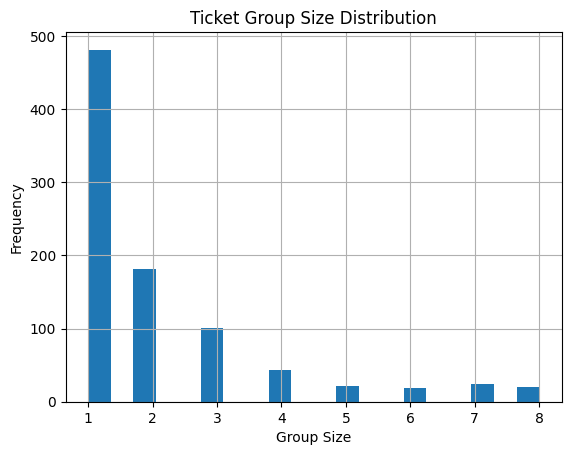

In [ ]:
# Visualize the distribution of ticket group sizes / チケットグループ人数の分布を可視化
df_fe2['TicketGroupSize'].hist(bins=20)
plt.title('Ticket Group Size Distribution')  # タイトル
plt.xlabel('Group Size')                    # x軸：人数
plt.ylabel('Frequency')                     # y軸：頻度
plt.show()

### 🔍 What We Found / 見えてきたこと  
The histogram shows that most passengers had a group size of 1 or 2,  
suggesting many were traveling alone or with just one companion.  
This supports the idea that group-related features might reveal social structures affecting survival.

このヒストグラムから、多くの乗客がグループサイズ1〜2であることがわかります。  
これは一人旅または少人数での行動が多かったことを示しており、  
グループに関する特徴量が生存に関係する社会的構造を示唆している可能性があります。

### 4.3.4 Logistic Regression with TicketGroupSize and IsGroup /
### TicketGroupSize・IsGroup を加えたロジスティック回帰

In [ ]:
X_fe2 = df_fe2.drop(columns=['PassengerId','Survived'])
y_fe2 = df_fe2['Survived']

X_fe2_test =  df_fe2_test.drop(columns=['PassengerId'])

X_fe2_train, X_fe2_valid, y_fe2_train, y_fe2_valid = train_test_split(X_fe2, y_fe2, test_size=0.3, random_state=42)

lr_fe2 = LogisticRegression(max_iter=200, random_state=42)
lr_fe2.fit(X_fe2_train, y_fe2_train)

print('Train Score: {}'.format(round(lr_fe2.score(X_fe2_train, y_fe2_train), 3)))
print(' Test Score: {}'.format(round(lr_fe2.score(X_fe2_valid, y_fe2_valid), 3)))

Train Score: 0.856
 Test Score: 0.821


### 🔍 What We Found / 見えてきたこと
Adding `TicketGroupSize` and `IsGroup` did not significantly change the validation score,  
but slightly improved the training accuracy.  
This suggests these features may provide helpful context, especially when used with other variables like `Title`.

`TicketGroupSize` と `IsGroup` を追加しても検証スコアには大きな変化はありませんでしたが、  
訓練スコアがわずかに向上しています。  
これらの特徴量は単独では影響が小さくても、`Title` など他の特徴量と組み合わせることで、背景情報として役立っている可能性があります。

## 🧩 4.4 Create Age Categories / 年齢をカテゴリ化する  
🎯 Why Categorize Age? / なぜ年齢をカテゴリ化するのか？

- In models like **logistic regression**, numerical features such as `Age` are interpreted linearly.  
  This means the model assumes that survival probability changes steadily with age.

- However, in reality, survival rates often vary **non-linearly across age groups** —  
  for example, children, young adults, and seniors may have very different outcomes.

- By converting age into **categories**, we allow the model to explicitly learn patterns specific to each age group.  
  This can improve interpretability and performance, especially for tree-based and linear models.

---

- ロジスティック回帰のようなモデルでは、`Age` のような数値特徴量は線形的に解釈されます。  
  つまり、年齢が上がるほど生存率が一様に変化する、という前提になります。

- しかし実際には、生存率は「子ども」「若者」「高齢者」などの **年齢層ごとに非線形に変化** する傾向があります。

- 年齢をカテゴリ化することで、モデルは **各年齢層に特有のパターン** を明示的に学習できるようになります。  
  特に、決定木系や線形モデルで効果が期待できます。


---



### 4.4.1👶👨‍🦰🧓 Categorizing Age into Groups / `Age` を年齢層でカテゴリ化

We convert the continuous `Age` feature into 3 categories:
- `Child` for ages 0–10
- `Adult` for ages 10–50
- `Senior` for ages 50–100

This helps the model understand non-linear survival patterns across different age groups.  
We then apply one-hot encoding to make these categories usable in machine learning models.

---

`Age`（年齢）を連続値のまま使うのではなく、以下のようなカテゴリに分けて扱います：

- `Child`：0〜10歳  
- `Adult`：10〜50歳  
- `Senior`：50〜100歳  

これは、年齢層ごとに異なる生存率傾向（非線形パターン）をモデルが学習しやすくするためです。  
その後、機械学習モデルで利用できるよう、ワンホットエンコーディングで数値化します。

In [ ]:
# Copy the latest dataframe / 最新の特徴量付きデータをコピー
df_fe3 = df_fe2.copy()  # + AgeGroup features
df_fe3_test = df_fe2_test.copy()

In [ ]:
# Combine Age from train and test to ensure consistent binning
# 訓練データとテストデータのAge列を結合し、同じ基準でビン分けできるようにする
all_age = pd.concat([df_fe3['Age'], df_fe3_test['Age']], axis=0)

# Create age group categories: Child (0–10), Adult (10–50), Senior (50–100)
# 年齢をカテゴリに変換：Child（0–10）、Adult（10–50）、Senior（50–100）
age_group = pd.cut(all_age, bins=[0, 10, 50, 100], labels=['Child','Adult', 'Senior'])

# Assign AgeGroup back to train and test data
# AgeGroup を訓練データ・テストデータに戻す
df_fe3['AgeGroup'] = age_group[:len(df_fe3)].reset_index(drop=True)
df_fe3_test['AgeGroup'] = age_group[len(df_fe3):].reset_index(drop=True)

# Combine AgeGroup from both sets and one-hot encode
# 両方の AgeGroup を結合してワンホットエンコーディング
all_group = pd.concat([df_fe3['AgeGroup'], df_fe3_test['AgeGroup']], axis=0)
age_dummies = pd.get_dummies(all_group, columns=['AgeGroup'], prefix='AgeGroup').astype(int)

# Add one-hot encoded columns back to original train and test sets
# ワンホット化した AgeGroup を元の訓練データ・テストデータに追加
df_fe3 = pd.concat([df_fe3.reset_index(drop=True), age_dummies.iloc[:len(df_fe3)].reset_index(drop=True)], axis=1)
df_fe3_test = pd.concat([df_fe3_test.reset_index(drop=True), age_dummies.iloc[len(df_fe3):].reset_index(drop=True)], axis=1)

# Drop original AgeGroup categorical column
# 元のカテゴリ列（AgeGroup）は削除
df_fe3.drop(columns=['AgeGroup'], inplace=True)
df_fe3_test.drop(columns=['AgeGroup'], inplace=True)

### 4.4.2 Logistic Regression with AgeGroup / Age をカテゴリ化して追加したロジスティック回帰


In [ ]:
X_fe3 = df_fe3.drop(columns=['PassengerId','Survived']).values
y_fe3 = df_fe3['Survived'].values

X_fe3_test =  df_fe3_test.drop(columns=['PassengerId']).values

X_fe3_train, X_fe3_valid, y_fe3_train, y_fe3_valid = train_test_split(X_fe3, y_fe3, test_size=0.3, random_state=42)

lr_fe3 = LogisticRegression(max_iter=200, random_state=42)
lr_fe3.fit(X_fe3_train, y_fe3_train)

print('Train Score: {}'.format(round(lr_fe3.score(X_fe3_train, y_fe3_train), 3)))
print(' Test Score: {}'.format(round(lr_fe3.score(X_fe3_valid, y_fe3_valid), 3)))

Train Score: 0.856
 Test Score: 0.81


### 🔍 What We Found / 見えてきたこと
We added age group features (Child, Adult, Senior) to capture potential non-linear effects of age on survival.  
However, the validation score slightly decreased from 0.821 to 0.817, suggesting the new features did not significantly improve model performance.

This may indicate that the model was already capturing the impact of age through other correlated features (e.g., Title or Family size),  
or that the age groups chosen were not optimal.

---

生存率に対する年齢の非線形な影響を捉えるために、Age をカテゴリ化して追加しました（Child、Adult、Senior）。  
しかし、検証スコアは 0.821 から 0.817 にわずかに低下し、新しい特徴量がモデル性能を明確に改善したとは言えません。

これは、年齢の影響がすでに他の関連特徴（例：TitleやFamily size）で捉えられていた可能性や、  
年齢層の区分けが最適でなかった可能性を示唆しています。

## 4.5 💰 Transforming Fare for Stability and Discretization / Fareの安定化と区間化処理

The Fare feature has two main challenges: zero values and a heavily skewed distribution.  
These issues can negatively affect model training and prediction accuracy.  
To solve these, we apply several data transformations.

---

Fare（運賃）には「0の値」と「右に大きく歪んだ分布」という2つの課題があります。  
これらはモデルの学習や予測精度に悪影響を与える可能性があります。  
そこで、いくつかのデータ変換を行います。

### 4.5.1 📊 Visualizing Fare Distribution / Fareの分布を可視化

We plot the distribution of the original `Fare` values using a histogram with KDE (kernel density estimate).  
This helps us understand how skewed the feature is and why a transformation is needed.

---

元の `Fare` の分布をヒストグラム＋カーネル密度推定（KDE）付きで可視化します。  
このグラフから、`Fare` がいかに **右に大きく偏っているか（右裾が長い）** を確認できます。  
こうした歪んだ分布は、モデルの学習において特定の値（高額運賃）を過剰に重視させる可能性があるため、後ほど対数変換などの処理が必要になります。

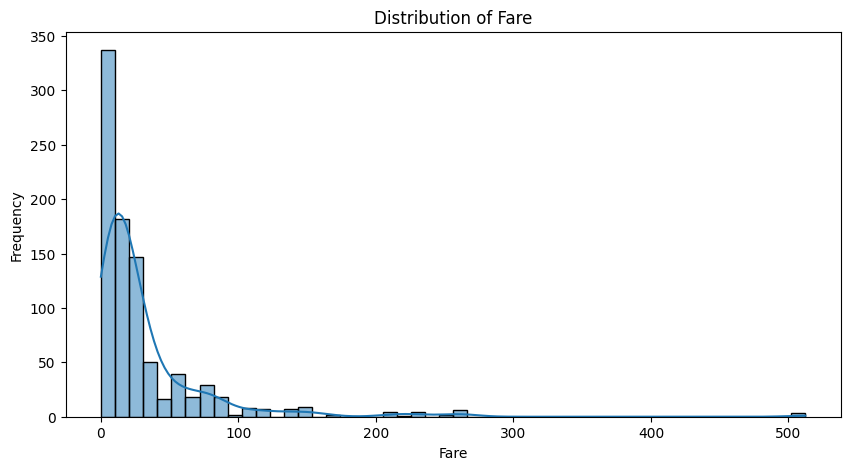

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Fare'], bins=50, kde=True)
plt.title('Distribution of Fare')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.show()

### 4.5.2💰 Fare Preprocessing: Handling Skewed and Zero Values / Fareの前処理：歪みと0値の対処

To improve model performance, we apply the following preprocessing steps to the `Fare` feature:

- **Replace zero fares** with the smallest positive fare in the training data.  
  This avoids issues during logarithmic transformation.
- **Apply log transformation** using `log1p`, which computes `log(Fare + 1)`.  
  This compresses large values and reduces skewness in the distribution.
- **Discretize Fare into 4 quantile-based bins** using `pd.qcut`.  
  This creates a new feature called `FareBand`, which categorizes passengers based on relative fare levels.

---

モデル精度の向上のため、`Fare` に以下の前処理を行いました：

- **0円のFare** を、訓練データ中の **最小の正のFare値** に置き換えました。  
  これにより、対数変換時のエラー（log(0)）を防ぎます。
- **対数変換**（`np.log1p`）を行い、`Fare` の大きな値を圧縮して分布の歪みを軽減しました。  
  `np.log1p(x)` は `log(x + 1)` を計算するため、0にも対応可能です。
- **等頻度の4つの区間（四分位）** に `Fare` を分割し、新たに `FareBand` というカテゴリ特徴量を作成しました。  
  これにより、乗客を相対的な運賃レベルで分類できます。


In [ ]:
df_fe4 = df_fe3.copy()  # + Fare features
df_fe4_test = df_fe3_test.copy()

In [ ]:
# Replace 0 fare values with the minimum positive fare in the dataset
# Fare が 0 の乗客は、データ中の最小の正の運賃で置き換える
min_fare = df_fe4[df_fe4['Fare'] > 0]['Fare'].min()

df_fe4['Fare'] = df_fe4['Fare'].replace(0, min_fare)
df_fe4_test['Fare'] = df_fe4_test['Fare'].replace(0, min_fare)

# Apply log transformation (log1p) to reduce skewness and handle outliers
# 対数変換（log1p）を適用して、分布の歪みを軽減し、外れ値の影響を抑える
df_fe4['Fare_log'] = np.log1p(df_fe4['Fare'])  # log(x + 1) is safe even for x = 0
df_fe4_test['Fare_log'] = np.log1p(df_fe4_test['Fare'])

# Discretize fare into 4 equal-sized quantile bins (FareBand)
# 運賃を4つの等頻度ビン（四分位）に分割し、FareBand というカテゴリ特徴量を作成
df_fe4['FareBand'] = pd.qcut(df_fe4['Fare'], q=4, labels=False)
df_fe4_test['FareBand'] = pd.qcut(df_fe4_test['Fare'], q=4, labels=False)

### 4.5.3 🔍 Visualizing Log-Transformed Fare / 対数変換後のFare分布を可視化

To check the effect of the log transformation, we plot the histogram of `log1p(Fare)`.  
The transformation compresses the extreme values and helps the feature become more normally distributed, which is better for many models such as logistic regression.

---

`log1p(Fare)` による **対数変換の効果を確認**するため、ヒストグラムを描画します。  
この変換により、運賃の極端に高い値が圧縮され、分布がより正規分布に近づきます。  
これは、ロジスティック回帰のようなモデルにとって有利に働くことが多いです。

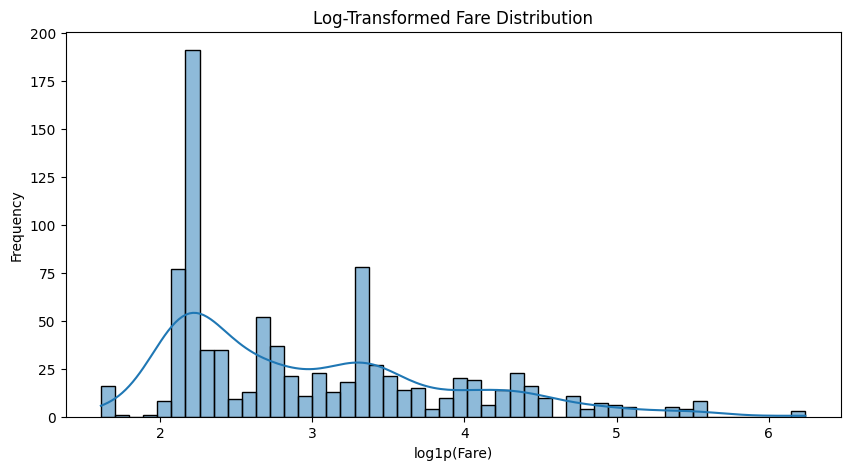

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(df_fe4['Fare']), bins=50, kde=True)
plt.title('Log-Transformed Fare Distribution')
plt.xlabel('log1p(Fare)')
plt.ylabel('Frequency')
plt.show()

### 4.5.4 ⚖️ Standardizing Fare / Fare の標準化

To prepare for models that are sensitive to feature scales (such as SVM or linear regression),  
we apply **Z-score normalization** to the `Fare` feature using `StandardScaler`.

---

SVM や線形回帰など、スケールに敏感なモデルに対応するため、`Fare` を **Zスコア正規化（標準化）** しました。  
`StandardScaler` により、Fare を「平均0・標準偏差1」に変換しています。

> ※ ロジスティック回帰も標準化の効果がある程度期待できますが、決定木系モデル（ランダムフォレストなど）には不要です。

In [ ]:
# Standardization (Z-score normalization) - especially useful for numerical models like SVM or linear models
# 標準化（Zスコア正規化） - SVMや線形モデルなど、数値に敏感なモデルに特に有効
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
# 訓練データの平均・標準偏差を学習し、訓練データを標準化する
df['Fare_scaled'] = scaler.fit_transform(df[['Fare']])

# Apply the same transformation to the test data
# テストデータにも同じルール（訓練データと同じ平均・標準偏差）で標準化を適用
df_test['Fare_scaled'] = scaler.transform(df_test[['Fare']])

### 4.5.5 📊 Logistic Regression with Fare Features / Fare特徴量を含めたロジスティック回帰

We train a logistic regression model using all features including:
- `Fare_log`: log-transformed fare (to reduce skewness)
- `FareBand`: binned fare values
- Other engineered features like `Family`, `Title`, and `AgeGroup`

The dataset is split into training and validation sets (70/30) to evaluate generalization performance.

---

`Fare_log`（対数変換後の運賃）、`FareBand`（ビン分割された運賃）などの特徴量を含めてロジスティック回帰モデルを学習しました。  
データは 70% 訓練用、30% 検証用 に分割し、汎化性能を評価します。

In [ ]:
# Prepare training and test features / 訓練データとテストデータを準備
X_fe4 = df_fe4.drop(columns=['PassengerId', 'Survived'])  # Features for training
y_fe4 = df_fe4['Survived']                                # Target variable

X_fe4_test = df_fe4_test.drop(columns=['PassengerId'])    # Test features (no target)

# Split training data into train and validation sets / 訓練データを訓練用と検証用に分割
X_fe4_train, X_fe4_valid, y_fe4_train, y_fe4_valid = train_test_split(
    X_fe4, y_fe4, test_size=0.3, random_state=42
)

# Logistic Regression model / ロジスティック回帰モデルの学習
lr_fe4 = LogisticRegression(max_iter=200, random_state=42)
lr_fe4.fit(X_fe4_train, y_fe4_train)

# Evaluate model performance / モデルの性能評価
print('Train Score: {}'.format(round(lr_fe4.score(X_fe4_train, y_fe4_train), 3)))
print(' Test Score: {}'.format(round(lr_fe4.score(X_fe4_valid, y_fe4_valid), 3)))

Train Score: 0.857
 Test Score: 0.813


### Insights / 考察

- Applying `log1p(Fare)` helped reduce the skewness and stabilize the model.
- `FareBand` adds interpretability by grouping passengers based on fare range.
- Logistic Regression benefits from normalized or transformed continuous features.

---

- `Fare` の対数変換によって分布の偏りが改善され、モデルの安定性が向上しました。
- `FareBand` により運賃に基づくグルーピングが可能になり、**解釈性が高まりました**。
- ロジスティック回帰は連続値に敏感なため、今回のような変換は有効です。

---

### 4.5.6 📊 Random Forest with Fare Features / Fare特徴量を含めたランダムフォレスト

In [ ]:
# ランダムフォレスト
rfc_fe4 = RandomForestClassifier(max_depth=5, min_samples_leaf=10, n_estimators=100, n_jobs=-1, random_state=42)
rfc_fe4.fit(X_fe4_train, y_fe4_train)

print('Train Score: {}'.format(round(rfc_fe4.score(X_fe4_train, y_fe4_train), 3)))
print(' Test Score: {}'.format(round(rfc_fe4.score(X_fe4_valid, y_fe4_valid), 3)))

Train Score: 0.852
 Test Score: 0.817


### Insights / 考察  
- The Random Forest model, enhanced with engineered fare features, shows balanced performance with similar train and test accuracies. This suggests that the model effectively captures the relationship between fare and survival without overfitting. Limiting the tree depth and minimum samples per leaf helps control model complexity and improves generalization. Including fare bins and log-transformed fare helps the model handle the skewed fare distribution better.  
---
- Fare特徴量を追加したランダムフォレストモデルは、訓練データと検証データでほぼ同じ精度を示し、過学習が抑えられていることがわかります。木の深さや葉の最小サンプル数を制限することでモデルの複雑さが調整され、汎化性能が向上しています。対数変換や等頻度ビン化されたFareは、偏った運賃分布に対してモデルがうまく対応できるようにしています。  

### 4.5.6.1 Default Random Forest Model: Cross-Validation Performance  
### / デフォルトモデルのクロスバリデーション評価  

We evaluate the default Random Forest model using 10-fold Stratified Cross-Validation on the entire training dataset.  
This provides baseline metrics (accuracy and ROC AUC) to compare against tuned models later.  

全訓練データを使い、10分割の層化交差検証でデフォルトのランダムフォレストモデルを評価します。  
これにより、後でチューニングモデルと比較するための基準となる精度とROC AUCの指標を得られます。

In [ ]:
# Features and target / 特徴量と目的変数
X = df_fe4.drop(columns=['PassengerId', 'Survived'])  # Features / 特徴量
y = df_fe4['Survived']                                # Target / 目的変数

# Model / モデル（デフォルトのランダムフォレスト）
rfc_default = RandomForestClassifier(n_estimators=100, random_state=42)

# Cross-validation strategy / クロスバリデーション戦略（層化 KFold）
rfc_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cv_acc_default = cross_val_score(rfc_default, X, y, cv=rfc_cv, scoring='accuracy')
cv_auc_default = cross_val_score(rfc_default, X, y, cv=rfc_cv, scoring='roc_auc')

print("Default Model - Mean CV Accuracy:", np.mean(cv_acc_default))
print("Default Model - Mean CV ROC AUC:", np.mean(cv_auc_default))

Default Model - Mean CV Accuracy: 0.8125093632958802
Default Model - Mean CV ROC AUC: 0.8653200916730329


### 4.5.7 Random Forest Hyperparameter Tuning with Randomized Search and Cross-Validation  
#### / ランダムフォレストのランダムサーチと交差検証によるハイパーパラメータチューニング

- Define a parameter distribution with `max_depth`, `min_samples_leaf`, and other key options.  
- Use `RandomizedSearchCV` with 10-fold **Stratified** cross-validation to efficiently search for the best hyperparameters.  
- Evaluate models using **accuracy** as the primary metric.  
- Fit `RandomizedSearchCV` on the full training data (no `train_test_split`) to maximize data usage.  
- Retrieve and display the best hyperparameters and the best cross-validation accuracy.  
- Using the best estimator, calculate **mean ROC AUC** and **mean accuracy** via 10-fold CV to assess model stability and generalization.  
- This process balances performance and efficiency, making it suitable when feature engineering is still evolving.

---

- `max_depth` や `min_samples_leaf` などの主要パラメータに対して、ランダムに候補を設定。  
- `RandomizedSearchCV` を 10分割の **StratifiedKFold（層化交差検証）** とともに使い、効率的に最適パラメータを探索。  
- 評価指標には `accuracy` を使用。  
- データを最大限活用するため、`train_test_split` は使わず全データで学習。  
- 最適なハイパーパラメータと、交差検証での最高精度（accuracy）を表示。  
- ベスト推定器を使い、10分割交差検証による **平均ROC AUC** と **平均Accuracy** を算出し、モデルの安定性を評価。  
- 特徴量がまだ変化している段階でも、効率よく汎化性能の高いモデルを得るための適切な方法。


In [ ]:
# Test data / テストデータ（目的変数はなし）
X_test = df_fe4_test.drop(columns=['PassengerId'])

# Define parameter distribution for RandomizedSearch / ランダムサーチ用のパラメータ範囲を定義
param_dist = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_leaf': [1, 2, 4, 8]
}

# Cross-validation strategy / クロスバリデーション戦略（層化 KFold）
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Set up RandomizedSearchCV / ランダムサーチをセットアップ
rfc_rs = RandomizedSearchCV(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    param_distributions=param_dist,
    n_iter=10,                 # Number of parameter settings sampled / 試すパラメータ数
    scoring='accuracy',       # Evaluation metric / 評価指標
    cv=cv,                    # Cross-validation strategy / クロスバリデーション手法
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV / ランダムサーチの実行
rfc_rs.fit(X, y)

# Best parameters and CV score / 最良パラメータとCVスコアを表示
print("Best Params:", rfc_rs.best_params_)
print("Best CV Accuracy:", rfc_rs.best_score_)

# Get best estimator / 最良モデルを取得
rf_rs_fe4 = rfc_rs.best_estimator_

# Cross-validated performance / クロスバリデーションでの性能評価
cv_auc = cross_val_score(rf_rs_fe4, X, y, cv=cv, scoring='roc_auc')
cv_acc = cross_val_score(rf_rs_fe4, X, y, cv=cv, scoring='accuracy')

print("Mean CV ROC AUC:", np.mean(cv_auc))
print("Mean CV Accuracy:", np.mean(cv_acc))

# # Create a DataFrame to compare the default and tuned model performances
# 比較用のDataFrame作成
comparison_df = pd.DataFrame({
    'Model': ['Default Random Forest', 'Tuned Random Forest'],
    'Mean CV Accuracy': [cv_acc_default.mean(), cv_acc.mean()],
    'Mean CV ROC AUC': [cv_auc_default.mean(), cv_auc.mean()]
})

print(comparison_df)

Best Params: {'min_samples_leaf': 1, 'max_depth': 7}
Best CV Accuracy: 0.8383520599250935
Mean CV ROC AUC: 0.8749170415641003
Mean CV Accuracy: 0.8383520599250935
                   Model  Mean CV Accuracy  Mean CV ROC AUC
0  Default Random Forest          0.812509         0.865320
1    Tuned Random Forest          0.838352         0.874917


### 📊 Model Comparison Summary / モデル比較のまとめ
| Model                 | Mean CV Accuracy | Mean CV ROC AUC |
| --------------------- | ---------------- | --------------- |
| Default Random Forest | 0.8125           | 0.8653          |
| Tuned Random Forest   | 0.8383           | 0.8749          |


### Insights / 考察

The tuned Random Forest model outperforms the default model in both accuracy and ROC AUC. This indicates that hyperparameter tuning via RandomizedSearchCV helped improve both classification performance and the model's ability to distinguish between classes. The increase in ROC AUC suggests better ranking of predictions and improved generalization.

チューニングされたランダムフォレストは、精度（Accuracy）とROC AUCの両方でデフォルトモデルを上回っています。これは、RandomizedSearchCVによるハイパーパラメータ調整が、分類性能およびクラス識別能力の向上に寄与したことを示します。特にROC AUCの改善は、予測のランク付けや汎化性能の向上を反映しています。

## 4.6 Feature Importance Analysis Using Random Forest / ランダムフォレストによる特徴量重要度の分析

Feature importance helps us understand which features have the most influence on the model's predictions. By identifying the most important variables, we can:

- Gain insights into the underlying data and factors affecting the target variable.
- Improve model interpretability and explainability.
- Select or engineer better features to enhance model performance.
- Potentially reduce the dimensionality of the dataset by removing less important features, leading to simpler and faster models.


---


特徴量重要度は、どの特徴量がモデルの予測にどれだけ影響を与えているかを理解するための指標です。重要な特徴量を知ることで、

- データの本質や目的変数に影響を与える要因の理解が深まります。
- モデルの解釈性や説明力が向上します。
- より良い特徴量の選択やエンジニアリングに役立ち、モデル性能を高めることができます。
- 重要度の低い特徴量を削除することで、次元削減やモデルの軽量化が可能になります。

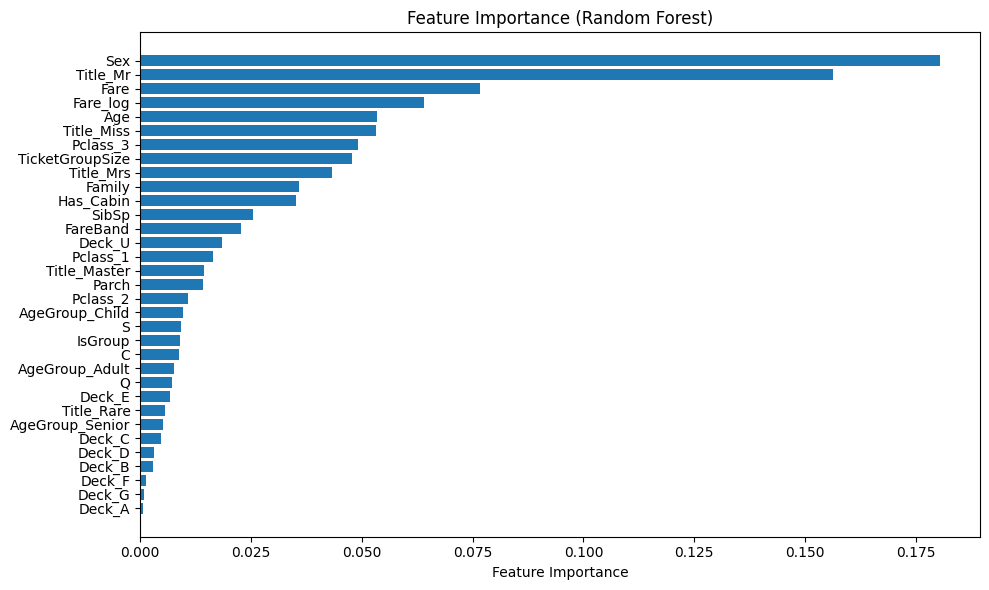

In [ ]:
# Get feature names excluding 'PassengerId' and 'Survived'
# 'PassengerId'と'生存'列は除く特徴量名を取得
feature_names = df_fe4.drop(columns=['PassengerId', 'Survived']).columns

# Retrieve feature importances from the best fitted Random Forest model
# 最適モデルから特徴量の重要度を取得
importances = rf_rs_fe4.feature_importances_

# Create a DataFrame for features and their importance scores, then sort descending
# 特徴量と重要度をまとめたデータフレームを作成し、重要度順にソート
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance as a horizontal bar chart
# 水平棒グラフで特徴量の重要度を可視化
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')  # X軸ラベル：特徴量の重要度
plt.title('Feature Importance (Random Forest)')  # グラフタイトル：ランダムフォレストの特徴量重要度
plt.gca().invert_yaxis()  # Invert y-axis to show most important feature at top（重要な特徴を上に表示）
plt.tight_layout()
plt.show()

###💡 Insights from Feature Importances /  特徴量重要度に基づく考察  

According to the Random Forest model, the top contributing features were:  
ランダムフォレストによる特徴量重要度では、以下の特徴が特に大きな影響を持つことがわかりました：  

1.  Sex  （性別）
2.  Title_Mr  （男性の敬称）
3.  Fare  （運賃）


These results align with known survival patterns on the Titanic:

Sex is the most influential feature, with females having significantly higher survival rates.

Title_Mr helps identify adult males, who historically had lower survival due to “women and children first” policies.

Fare (log-transformed or binned) reflects passenger class and socio-economic status, both of which are closely tied to survival odds.


これはタイタニックの生存傾向と整合的です：

性別は最も重要で、女性の生存率が明らかに高いことがデータからも示されています。

Title_Mrは成人男性を特定でき、"女性と子供が優先"という当時の救助方針を反映した結果です。

Fare（対数変換またはビン化済み）は、乗客の階級や社会的地位を表しており、生存可能性と強く相関しています。

## 4.7 Decision Tree Visualization (First Tree of Random Forest) /         決定木の可視化（ランダムフォレスト1本目）

Below is the structure of the first decision tree within the Random Forest model.  
In this tree, **sex** is used as the first splitting condition, indicating its high importance in the model.

以下はランダムフォレスト内の1本目の決定木の構造です。  
この木では **sex** が最初の分岐条件となっており、モデルにおいて重要な特徴量であることを示しています。

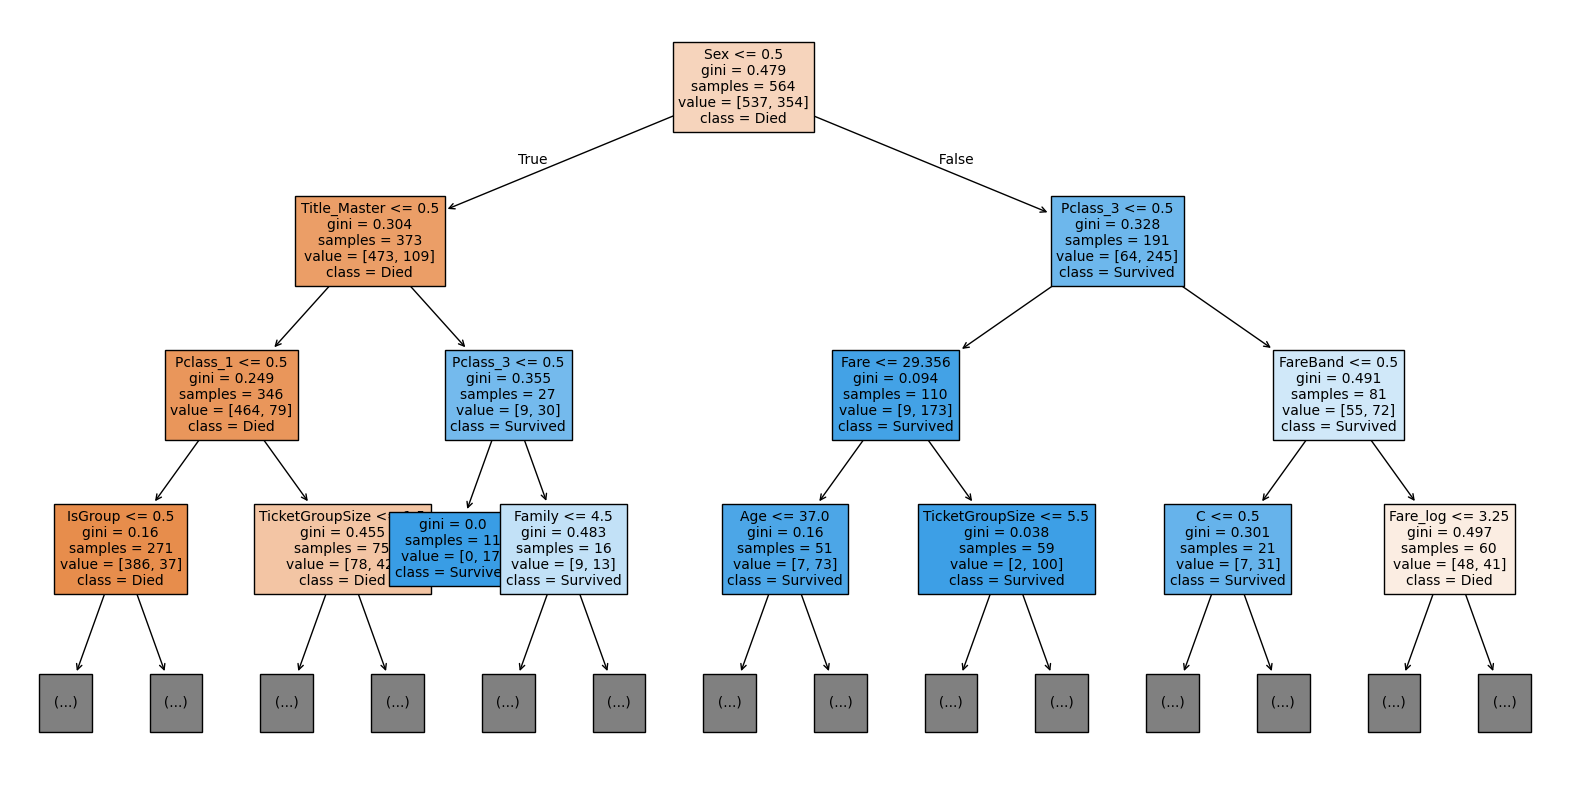

In [ ]:
# Extract one tree from the random forest and visualize it
# ランダムフォレストから1本の決定木を抽出して可視化する

estimator = rf_rs_fe4.estimators_[0]  # The first tree in the random forest / ランダムフォレスト内の最初の決定木を取得

plt.figure(figsize=(20, 10))
plot_tree(estimator,
          feature_names=df_fe4.drop(columns=['PassengerId', 'Survived']).columns,  # Feature names for display
          class_names=["Died", "Survived"],  # Class labels
          filled=True,  # Color nodes by class purity
          max_depth=3,  # Limit depth of visualization for readability
          fontsize=10)
plt.show()

Note: The features used in the early splits of a single decision tree may not perfectly match the global feature importance rankings. Feature importance is computed across all trees, while the decision tree visualization only represents one tree’s structure.  
（注）1本の決定木で最初に使われる特徴量と、ランダムフォレスト全体の重要度上位の特徴量は、必ずしも一致しません。重要度はすべての木を通じて算出される統計的な指標であり、可視化された木はその中の一例にすぎません。


## 4.8 Top 10 Feature Importance Analysis in Random Forest Model / ランダムフォレストモデルにおける上位10特徴量の重要度分析  

Understanding which features contribute most to model performance helps in interpretation, feature selection, and further improvements.
Here, we extract the top 10 most important features based on the tuned Random Forest model.

どの特徴量がモデル性能に最も貢献しているかを把握することで、モデルの解釈性が高まり、特徴量選択や改善に役立ちます。
ここでは、チューニング済みのランダムフォレストモデルに基づいて、重要度の高い特徴量トップ10を抽出して可視化します。


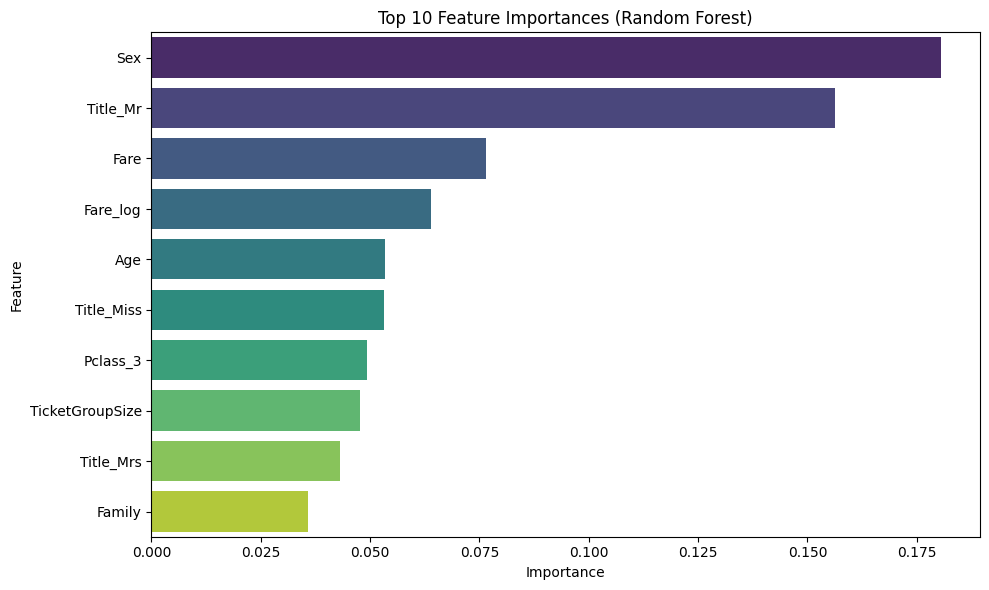

In [ ]:
top_n = 10  # Extract top 10 features
top_features = feature_importance_df.head(top_n)

# Plot the top 10 feature importances
# 上位10件の特徴量重要度をプロット
plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')
plt.title(f'Top {top_n} Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

###💡 Insights / 考察
Sex, Title_Mr, and Fare are among the top influential predictors.

Visualizing feature importance helps us focus on key variables and potentially eliminate or transform low-importance ones.

These results reinforce earlier interpretations and guide future feature refinement.

Sex, Title_Mr, Fare などが上位に位置しており、モデルにとって非常に重要な特徴量であることがわかります。
この可視化は、重要な変数に注目し、不要な特徴の削除や改善に向けた方向性を示してくれます。

## 4.9 Cumulative Feature Importance for Feature Selection / 特徴量選択のための累積重要度の可視化
To perform feature selection, we visualized the cumulative feature importance.  
This helps us identify how many top features are needed to cover over 80% of the total importance.  
The cumulative importance plot serves as a guide to balance model complexity and performance.

---
特徴量選択を行うために、特徴量の累積重要度を可視化しました。  
これにより、全体の80%以上の重要度をカバーするために必要な上位特徴量の数がわかります。  
累積重要度のグラフは、モデルの複雑さと性能のバランスを取る際の指標として役立ちます。


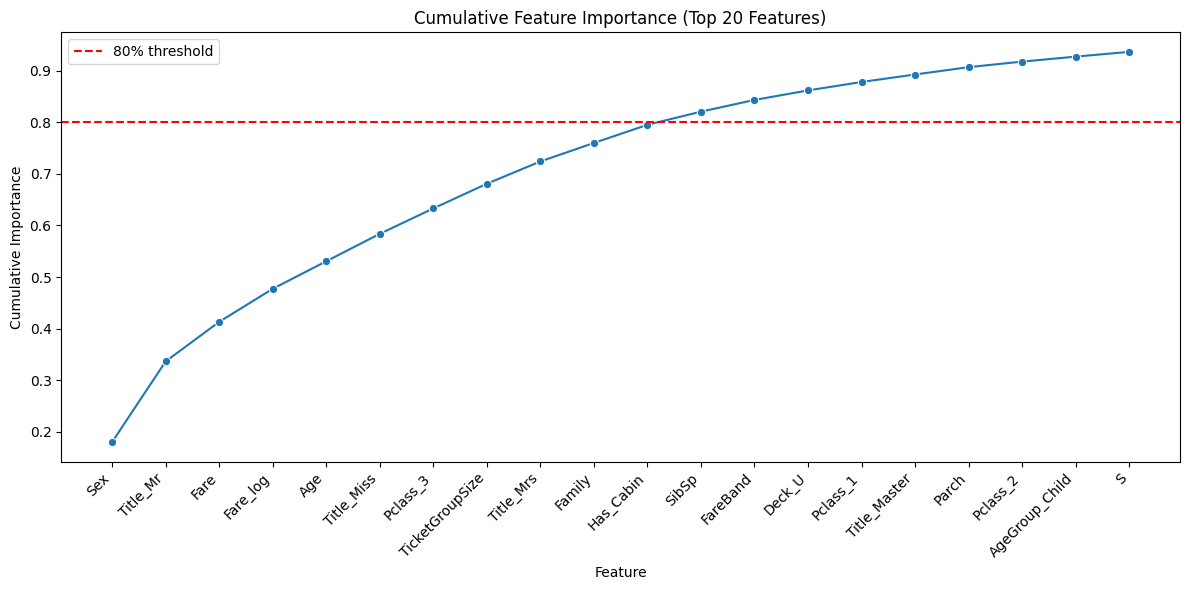

In [ ]:
# Calculate cumulative importance
# 累積重要度を計算する
feature_importance_df['Cumulative'] = feature_importance_df['Importance'].cumsum()

# Limit the number of displayed features (Top 20)
# 表示する特徴量数を制限（上位20件のみ表示）
top_n_display = 20

plt.figure(figsize=(12, 6))

# Line plot with feature names on the x-axis
# 特徴量名をX軸に用いた折れ線グラフ
sns.lineplot(
    data=feature_importance_df.head(top_n_display),
    x='Feature',
    y='Cumulative',
    marker='o'
)

# Rotate x-axis labels for readability
# X軸ラベルを回転して読みやすくする
plt.xticks(rotation=45, ha='right')

# Draw a horizontal line at 80% cumulative importance
# 累積重要度80%のしきい値ラインを追加
plt.axhline(0.8, color='red', linestyle='--', label='80% threshold')

# Titles and labels / タイトルと軸ラベル
plt.title('Cumulative Feature Importance (Top 20 Features)')
plt.xlabel('Feature')
plt.ylabel('Cumulative Importance')
plt.legend()

# Adjust layout / レイアウト調整
plt.tight_layout()
plt.show()

## 4.10 Selected Features Covering Top 80% of Cumulative Importance / 累積重要度上位80%を占める特徴量の選択

This code selects and lists the features whose cumulative importance is less than 80%.  
These features represent the most important ones that contribute up to 80% of the total importance in the model.  
Using these selected features can help reduce dimensionality while retaining most of the predictive power.  

---
このコードは累積重要度が80%未満の特徴量を選択し、リスト化しています。  
これらの特徴量はモデルの全体重要度の80%までを占める最も重要な特徴量群です。  
この特徴量群を使うことで、次元削減しつつ予測性能を維持することが期待できます。


In [ ]:
# Select features that contribute to cumulative importance less than 80%
# 累積重要度が80%未満の特徴量を選択
selected_features = feature_importance_df[feature_importance_df['Cumulative'] < 0.8]['Feature'].tolist()

# Display the selected features
# 選択された特徴量を表示
print("Top 80% features:", selected_features)

Top 80% features: ['Sex', 'Title_Mr', 'Fare', 'Fare_log', 'Age', 'Title_Miss', 'Pclass_3', 'TicketGroupSize', 'Title_Mrs', 'Family', 'Has_Cabin']


## 4.11 Grid Search Using Top 80% Features / 上位80%の特徴量を使ったグリッドサーチの実施

We select only the features that cumulatively account for 80% of the importance and perform hyperparameter tuning (grid search) on the Random Forest model using these selected features.

---
累積重要度で上位80%を占める特徴量だけを選択し、その特徴量に絞ってランダムフォレストのハイパーパラメータ最適化（グリッドサーチ）を行います。  


In [ ]:
# =====================================================
# 1. Define features and target variable / 上位80%の特徴量だけを特徴量に含める
# =====================================================
X_selected = df_fe4[selected_features]
y_selected = df_fe4['Survived']

# =====================================================
# 2. Define StratifiedKFold CV / StratifiedKFoldの定義（shuffleあり）
# =====================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# =====================================================
# 3. Hyperparameter grid / ハイパーパラメータの候補設定
# =====================================================
param_grid_rf_sel = {
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}

# =====================================================
# 4. Grid Search with cross-validation / クロスバリデーション付きグリッドサーチ
# =====================================================
grid_search_rf_sel = GridSearchCV(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    param_grid=param_grid_rf_sel,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# =====================================================
# 5. Fit on all data / 全データで学習（グリッドサーチで最適パラメータ探索）
# =====================================================
grid_search_rf_sel.fit(X_selected, y_selected)

# =====================================================
# 6. Get best estimator and parameters / 最良モデルとパラメータ取得
# =====================================================
best_model_rf_sel = grid_search_rf_sel.best_estimator_
best_params_rf_sel = grid_search_rf_sel.best_params_

# =====================================================
# 7. Evaluation function definition / クロスバリデーション評価関数定義
# =====================================================
def evaluate_model_cv(model, X, y, cv):
    accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()
    roc_auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc').mean()
    return {'accuracy': accuracy, 'roc_auc': roc_auc}

# =====================================================
# 8. Evaluate model with cross-validation / クロスバリデーションによる性能評価
# =====================================================
scores_rf_sel = evaluate_model_cv(best_model_rf_sel, X_selected, y_selected, cv)

# =====================================================
# 9. Classification report with cross-validated predictions / CV予測を使った分類レポート
# =====================================================
y_pred_cv_rf_sel = cross_val_predict(best_model_rf_sel, X_selected, y_selected, cv=cv)
class_report_rf_sel = classification_report(y_selected, y_pred_cv_rf_sel)

# =====================================================
# 10. Output results / 結果の出力
# =====================================================
print("📌 Best Parameters (RF selected features):", best_params_rf_sel)
print("📈 Mean CV Accuracy:", scores_rf_sel['accuracy'])
print("📈 Mean CV ROC AUC:", scores_rf_sel['roc_auc'])
print("📝 Classification Report (CV predictions):\n", class_report_rf_sel)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
📌 Best Parameters (RF selected features): {'max_depth': 7, 'min_samples_leaf': 4}
📈 Mean CV Accuracy: 0.8473416609126859
📈 Mean CV ROC AUC: 0.8760126725382831
📝 Classification Report (CV predictions):
               precision    recall  f1-score   support

           0       0.85      0.91      0.88       549
           1       0.83      0.75      0.79       342

    accuracy                           0.85       891
   macro avg       0.84      0.83      0.84       891
weighted avg       0.85      0.85      0.85       891



### Discussion / 考察

- **Effectiveness of Feature Selection**  
  Selecting only the top 80% of features based on cumulative importance retained strong predictive performance, demonstrating that dimensionality reduction by removing less important features is effective.

- **Model Performance**  
  The mean cross-validated accuracy (~0.85) and ROC AUC (~0.88) show that the model generalizes well and maintains stable performance.

- **Class-wise Performance Differences**  
  The recall for the deceased class (class 0) is high, whereas the recall for the survived class (class 1) is somewhat lower, indicating the model tends to miss some survivors.

- **Improved Computational Efficiency**  
  Reducing the number of features lowers training and inference computational costs, making the model more practical for deployment.

Future work could focus on improving recall for the survived class, exploring further feature engineering, and considering ensemble methods to boost accuracy.

---

- **特徴量選択の有効性**  
  累積重要度の上位80%の特徴量だけを選択しても高い予測性能を維持しており、重要度の低い特徴量を除くことで次元削減が効果的であることが示されました。

- **モデルの性能**  
  クロスバリデーションの平均Accuracy（約0.85）およびROC AUC（約0.88）から、モデルの汎化性能が高く安定していることがわかりました。

- **クラス別の性能差**  
  死亡者クラス（クラス0）のリコールは高い一方、生存者クラス（クラス1）のリコールがやや低く、生存者を見逃しやすい傾向がみられました。

- **計算効率の向上**  
  特徴量を絞ることで学習・推論の計算コストが低減され、実用面での利便性が向上しています。

今後は、生存者クラスのリコール改善、さらなる特徴量エンジニアリングの検討、およびアンサンブル手法の導入による精度向上を目指すことが重要です。

## 4.12 Stepwise Feature Selection from Remaining Features / 残りの特徴量から1つずつ選んでスコア比較を行う

We start from the currently selected features (top 80% by importance) and evaluate the baseline model accuracy.  
Then, we iteratively add one remaining feature at a time to see if it improves the model performance.  
This helps us identify which additional features might be valuable to include.

現在選択されている特徴量（重要度上位80%）でベースラインのスコアを計算します。  
その後、残りの特徴量を一つずつ追加してモデルの精度を比較し、  
どの特徴量を追加すると改善が見込めるかを確認します。  

In [ ]:
# Currently selected features (top 80% by importance)
# 現在選択されている特徴量（重要度上位80%）
selected_features = ['Sex', 'Title_Mr', 'Fare', 'Fare_log', 'Age', 'Title_Miss', 'Pclass_3', 'TicketGroupSize', 'Title_Mrs', 'Family', 'Has_Cabin']

# All feature columns excluding 'PassengerId' and 'Survived'
# 'PassengerId'と'生存'列を除いたすべての特徴量名
all_features = df_fe4.drop(columns=['PassengerId', 'Survived']).columns.tolist()

# Candidate features not yet used in the selected features
# 現在の選択特徴量に含まれていない、未使用の候補特徴量
remaining_features = [f for f in all_features if f not in selected_features]

# Original target variable / 目的変数（生存フラグ）
y = df_fe4['Survived']

print("Number of current features:", len(selected_features))  # 現在の特徴量数
print("Number of candidate features:", len(remaining_features))  # 候補特徴量数
print()

# Baseline score with currently selected features / 現在の特徴量のみでのベースラインスコア計算
X_base = df_fe4[selected_features]
X_train_base, X_valid_base, y_train, y_valid = train_test_split(
    X_base, y, test_size=0.3, random_state=42
)
model_base = RandomForestClassifier(n_estimators=100, random_state=42)
model_base.fit(X_train_base, y_train)
base_score = model_base.score(X_valid_base, y_valid)
print(f"Baseline score with current features: {base_score:.4f}")
print()

# List to store results of adding each remaining feature / 追加特徴ごとの結果格納リスト
improvement_list = []

for feature in remaining_features:
    # Combine current features with one candidate feature / 現在の特徴量に1つの候補特徴量を追加
    test_features = selected_features + [feature]
    X = df_fe4[test_features].values

    # Split train and validation sets / 学習・検証データに分割
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Train Random Forest model / ランダムフォレストモデルの学習
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate accuracy on validation set / 検証データでの精度評価
    score = model.score(X_valid, y_valid)

    # Calculate score difference compared to baseline / ベースラインとの差分を計算
    score_diff = score - base_score

    # Append results to list / 結果をリストに追加
    improvement_list.append((feature, score, score_diff))

    print(f"Added feature: {feature:<20} → Score: {score:.4f} (Diff: {score_diff:+.4f})")

# Sort results by score difference descending / スコア差分で降順にソート
improvement_list.sort(key=lambda x: x[2], reverse=True)

print("\n=== Score Improvement Ranking / スコア改善ランキング ===")
for feature, score, diff in improvement_list:
    print(f"{feature:<20} → Score: {score:.4f} (Diff: {diff:+.4f})")

Number of current features: 11
Number of candidate features: 22

Baseline score with current features: 0.7948

Added feature: SibSp                → Score: 0.7910 (Diff: -0.0037)
Added feature: Parch                → Score: 0.7948 (Diff: +0.0000)
Added feature: Deck_A               → Score: 0.7910 (Diff: -0.0037)
Added feature: Deck_B               → Score: 0.8022 (Diff: +0.0075)
Added feature: Deck_C               → Score: 0.7836 (Diff: -0.0112)
Added feature: Deck_D               → Score: 0.7910 (Diff: -0.0037)
Added feature: Deck_E               → Score: 0.7799 (Diff: -0.0149)
Added feature: Deck_F               → Score: 0.7799 (Diff: -0.0149)
Added feature: Deck_G               → Score: 0.7948 (Diff: +0.0000)
Added feature: Deck_U               → Score: 0.7948 (Diff: +0.0000)
Added feature: C                    → Score: 0.7948 (Diff: +0.0000)
Added feature: Q                    → Score: 0.7948 (Diff: +0.0000)
Added feature: S                    → Score: 0.8172 (Diff: +0.0224)
Added

### Discussion / 考察

### 1. Model Performance Improvement  
By adding the features `S` (Embarked), `AgeGroup_Adult` (Adult Age Group), `Deck_B` (Deck B), `Pclass_1` (First Class), and `IsGroup` (Presence of Group), the model's accuracy improved compared to the baseline using the top 80% important features.  
Notably, adding `S` led to the largest accuracy gain of about 2.2%, confirming that the boarding location plays a significant role in survival prediction.

### 1. モデル性能の向上  
`S`（乗船地）、`AgeGroup_Adult`（成人年齢グループ）、`Deck_B`（Bデッキ）、`Pclass_1`（ファーストクラス）、`IsGroup`（グループの有無）を追加したことで、重要度上位80%の特徴量のみを使ったベースラインよりもモデルの精度が向上しました。  
特に`S`の追加による約2.2%の精度改善が最大であり、乗船地が生存予測に重要な因子であることを裏付けています。

---

### 2. Interpretability and Practical Implications  
- The `S` feature likely reflects differences in rescue priority or lifeboat access based on boarding location.  
- `AgeGroup_Adult` captures survival pattern differences between adults and other age groups.  
- `Deck_B` and `Pclass_1` represent spatial and social status information influencing survival chances.  
- `IsGroup` suggests that traveling in groups may affect survival likelihood.

### 2. 解釈と実用的意義  
- `S`は、救命ボートの配置や救助の優先度の違いを反映している可能性があります。  
- `AgeGroup_Adult`は、成人とその他の年齢層間での生存パターンの違いを捉えています。  
- `Deck_B`や`Pclass_1`は、船内の位置や社会的地位に関わる情報で、生存確率に影響を与えています。  
- `IsGroup`は、グループでの同行が生存率に影響する可能性を示唆しています。

---

### 3. Future Directions  
While the model accuracy improved, there remains room to enhance recall for the survived class. Future efforts could focus on:  
- Further feature engineering, such as detailed group or family relationships.  
- Ensemble methods to increase model robustness.  
- Using balanced evaluation metrics like F1-score or AUC to better capture minority class performance.

### 3. 今後の方向性  
モデルの精度は向上しましたが、生存者クラスのリコール改善にはまだ課題があります。今後は以下の点に注力すると良いでしょう。  
- グループや家族関係の詳細を含むさらなる特徴量エンジニアリング。  
- モデルの堅牢性を高めるためのアンサンブル手法の検討。  
- 少数クラスの性能を適切に評価するため、F1スコアやAUCなどのバランスの取れた評価指標の活用。

---

### Summary  
The stepwise feature selection approach successfully identified additional valuable features, leading to a more interpretable and higher-performing model. This process enhances both the predictive power and the practical usability of the model.

### まとめ  
ステップワイズ特徴量選択により、重要度上位の特徴量だけでなく、有用な追加特徴量を特定でき、より解釈しやすく精度の高いモデルが構築できました。  
これにより、予測性能と実用性の両方が向上しました。


### 4.13 Grid Search with Extended Feature Set / 拡張特徴量セットを使ったグリッドサーチ

We add the features that improved the score (`S`, `AgeGroup_Adult`, `Deck_B`, `Pclass_1`, `IsGroup`) to the original selected features, creating an extended feature set.  
Using this extended set, we perform hyperparameter tuning for the Random Forest model with GridSearchCV to find the best parameters that maximize model performance.

スコア改善に寄与した特徴量（`S`、`AgeGroup_Adult`、`Deck_B`、`Pclass_1`、`IsGroup`）を元の選択特徴量セットに追加し、拡張特徴量セットを作成します。  
この拡張特徴量セットを使って、ランダムフォレストモデルのハイパーパラメータ最適化をGridSearchCVで行い、モデルの性能を最大化する最適なパラメータを探索します。


In [ ]:
# =====================================================
# 1. Define extended feature set / 拡張特徴量セットの定義
# =====================================================
extended_features = selected_features + ['S', 'AgeGroup_Adult', 'Deck_B', 'Pclass_1', 'IsGroup']
X_extended = df_fe4[extended_features]
y = df_fe4['Survived']

# =====================================================
# 2. Define StratifiedKFold CV / StratifiedKFoldの定義（shuffleあり）
# =====================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# =====================================================
# 3. Define hyperparameter grid / ハイパーパラメータの候補設定
# =====================================================
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}

# =====================================================
# 4. Grid Search with cross-validation / グリッドサーチ実行
# =====================================================
rfc_extended = GridSearchCV(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# =====================================================
# 5. Fit on all data / 全データで学習し最適パラメータを探索
# =====================================================
rfc_extended.fit(X_extended, y)

# =====================================================
# 6. Get best estimator and parameters / 最良モデルとパラメータ取得
# =====================================================
best_model_rfc_extended = rfc_extended.best_estimator_
best_params_rfc_extended = rfc_extended.best_params_

# =====================================================
# 7. Evaluate model with cross-validation / クロスバリデーションで性能評価
# =====================================================
cv_acc_extended = cross_val_score(best_model_rfc_extended, X_extended, y, cv=cv, scoring='accuracy').mean()
cv_auc_extended = cross_val_score(best_model_rfc_extended, X_extended, y, cv=cv, scoring='roc_auc').mean()

# =====================================================
# 8. Classification report with cross-validated predictions / CV予測を使った分類レポート作成
# =====================================================
y_pred_cv_extended = cross_val_predict(best_model_rfc_extended, X_extended, y, cv=cv)
class_report_extended = classification_report(y, y_pred_cv_extended)

# =====================================================
# 9. Output results / 結果の出力
# =====================================================
print("📌 Best Parameters (RF extended features):", best_params_rfc_extended)
print("📈 Mean CV Accuracy (extended features):", cv_acc_extended)
print("📈 Mean CV ROC AUC (extended features):", cv_auc_extended)
print("📝 Classification Report (CV predictions):\n", class_report_extended)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
📌 Best Parameters (RF extended features): {'max_depth': 7, 'min_samples_leaf': 2}
📈 Mean CV Accuracy (extended features): 0.8439897056054233
📈 Mean CV ROC AUC (extended features): 0.8790342975497483
📝 Classification Report (CV predictions):
               precision    recall  f1-score   support

           0       0.86      0.90      0.88       549
           1       0.82      0.76      0.79       342

    accuracy                           0.84       891
   macro avg       0.84      0.83      0.83       891
weighted avg       0.84      0.84      0.84       891



## Discussion / 考察

### Model Performance / モデルの性能  
The model using the extended feature set achieved:  
- Mean cross-validated accuracy of approximately 0.844,  
- ROC AUC of about 0.879,  
showing a slight improvement compared to the baseline and simpler feature sets.

拡張特徴量セットを用いたモデルは、  
- 平均クロスバリデーション精度が約0.844、  
- ROC AUCが約0.879となり、  
ベースラインや単純な特徴量セットと比較して若干の性能向上が見られました。

### Precision and Recall / 精度と再現率  
- For class 0 (deceased), precision was 86% and recall was 90%, indicating strong performance.  
- For class 1 (survived), precision was 82% but recall was lower at 76%, suggesting the model still tends to miss some survivors.

クラス0（死亡者）に対しては、精度86%、再現率90%と高い性能を発揮。  
クラス1（生存者）に対しては、精度82%だが再現率は76%とやや低く、生存者を見逃す傾向があります。

### Implications and Future Work / 今後の示唆  
The feature addition stably improved the model performance, but there remains room to improve recall for the survived class.  
Future work could explore:  
- Further feature engineering and data augmentation,  
- More complex models such as ensemble.  

今回の特徴量追加でモデル性能は安定的に向上しましたが、生存者クラスのリコール改善の余地があります。  
今後は、  
- さらなる特徴量エンジニアリングやデータ増強、  
- アンサンブルのような複雑なモデル

## 4.14 Confusion Matrix / 混同行列
We use the confusion matrix to evaluate the classification performance of the best Random Forest model on the validation set.  
It shows how many predictions were correct or incorrect for each class.  
混同行列は、最良のランダムフォレストモデルを検証データに対して評価するために使
います。  
各クラスについて、正解・不正解の予測数が分かります。

Confusion Matrix:
 [[508  41]
 [ 68 274]]


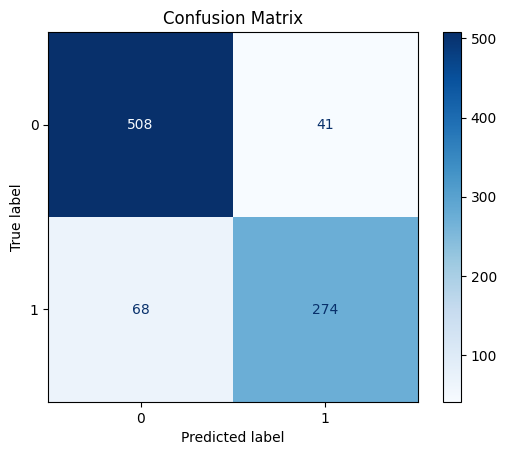

In [ ]:
# Predict labels with the best model
# 最良モデルで予測ラベルを取得
y_pred = best_model_rfc_extended.predict(X_extended)

# Calculate confusion matrix / 混同行列を計算
cm = confusion_matrix(y, y_pred)

# Print confusion matrix / 混同行列を表示
print("Confusion Matrix:\n", cm)

# Visualize confusion matrix / 混同行列を可視化（任意）
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model_rfc_extended.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Confusion Matrix Explanation / 解説

- **True Negative (TN):** 508 — Number of actual non-survivors correctly predicted as non-survivors.  
- **False Positive (FP):** 41 — Number of actual non-survivors incorrectly predicted as survivors.  
- **False Negative (FN):** 68 — Number of actual survivors incorrectly predicted as non-survivors.  
- **True Positive (TP):** 274 — Number of actual survivors correctly predicted as survivors.  

**Insights:**  
- The model shows strong performance detecting non-survivors (high TN).  
- However, it misses some survivors (relatively high FN), indicating room for improvement in recall for the survivor class.  
- This aligns with previous observations of lower recall for class 1.  
- Addressing class imbalance and improving model calibration could help improve performance.

---


- **True Negative (TN):** 508 — 実際に死亡した人を正しく死亡と予測した数。  
- **False Positive (FP):** 41 — 実際は死亡者だが、生存者と誤分類した数。  
- **False Negative (FN):** 68 — 実際は生存者だが、死亡者と誤分類した数。  
- **True Positive (TP):** 274 — 実際に生存した人を正しく生存と予測した数。  

**考察：**  
- 死亡者クラスの検出精度が高い（TNが多い）ことがわかります。  
- 一方で生存者クラスの見逃し（FN）が一定数あり、リコール改善の余地があります。  
- これは以前のリコールが低い結果とも整合しています。  
- クラス不均衡への対応やモデルの調整を行うことで、性能向上が期待されます。


## 4.15 Analyzing Misclassified Samples / 誤分類サンプルの分析  

This code identifies which validation samples the model misclassified.  
By examining these errors, we can better understand the model's weaknesses and potentially improve it.  
The process includes preparing the data, training the model, making predictions, restoring original feature values for clarity, and extracting the misclassified cases.

このコードは、モデルが検証データで誤分類したサンプルを特定します。  
誤分類したデータを調べることで、モデルの弱点を把握し、改善のヒントを得ることができます。  
処理の流れは、データ準備、モデル訓練、予測、元の特徴量の復元（見やすさのため）、誤分類ケースの抽出です。


In [ ]:
# Features and target variable / 特徴量と目的変数の設定
extended_features = selected_features + ['S', 'AgeGroup_Adult', 'Deck_B', 'Pclass_1', 'IsGroup']
X = df_fe4[extended_features]
y = df_fe4['Survived']

# Split dataset while preserving index / インデックスを保持して学習・検証データに分割
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest model with best parameters / 最適パラメータでランダムフォレストを訓練
rfc = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=4,
    n_jobs=-1,
    random_state=42
)
rfc.fit(X_train.values, y_train.values)

# Predict on validation set / 検証データで予測
y_pred = rfc.predict(X_valid.values)

# Recover validation dataset with original indices / 元のインデックス付き検証データを復元
df_valid = df_fe4.loc[X_valid.index].copy()

# Function to recover original Pclass from one-hot encoding / ワンホットエンコーディングされたPclassを元に戻す関数
def recover_pclass(row):
    if row.get('Pclass_1') == 1:
        return 1
    elif row.get('Pclass_2') == 1:
        return 2
    elif row.get('Pclass_3') == 1:
        return 3
    return None

# Add recovered Pclass column if present / Pclass列を復元して追加（存在する場合）
if 'Pclass_1' in df_valid.columns:
    df_valid['Pclass'] = df_valid.apply(recover_pclass, axis=1)

# Recover Sex as string for interpretability (0: male, 1: female) / 性別を文字列に復元（0: 男性, 1: 女性）
df_valid['Sex_str'] = df_valid['Sex'].map({0: 'male', 1: 'female'})

# Add prediction results and correctness flag / 予測結果と正解判定を追加
df_valid['Predicted'] = y_pred
df_valid['Correct'] = df_valid['Survived'] == df_valid['Predicted']

# Extract misclassified samples / 誤分類されたサンプルを抽出
mistakes = df_valid[df_valid['Correct'] == False]
print("\n=== Misclassified Validation Data / 誤分類された検証データ ===")
print(mistakes[['Survived', 'Predicted', 'Sex_str', 'Age', 'Fare', 'Pclass']])


=== Misclassified Validation Data / 誤分類された検証データ ===
     Survived  Predicted Sex_str   Age      Fare  Pclass
709         1          0    male  28.0   15.2458       3
621         1          0    male  42.0   52.5542       1
447         1          0    male  34.0   26.5500       1
192         1          0  female  19.0    7.8542       3
673         1          0    male  31.0   13.0000       2
235         0          1  female  28.0    7.5500       3
204         1          0    male  18.0    8.0500       3
23          1          0    male  28.0   35.5000       1
362         0          1  female  45.0   14.4542       3
772         0          1  female  57.0   10.5000       2
312         0          1  female  26.0   26.0000       2
889         1          0    male  26.0   30.0000       1
767         0          1  female  30.5    7.7500       3
357         0          1  female  38.0   13.0000       2
254         0          1  female  41.0   20.2125       3
712         1          0    male  4

### Misclassification Analysis Insights / 誤分類の傾向分析

Among the misclassified samples, we observe the following:

- Many false negatives (actual survivors predicted as non-survivors) are **young males in 3rd class with low fares**.
- Several false positives (actual non-survivors predicted as survivors) are **females in 2nd or 3rd class**, which might indicate the model over-prioritizes gender.
- Passengers with ambiguous feature combinations (e.g., high fare but low class) are also frequently misclassified.

These patterns suggest the model might be relying too heavily on individual features like `Sex` or `Fare`, rather than more complex interactions. Introducing more sophisticated features (e.g., family grouping, social status from titles) or using more advanced models (e.g., XGBoost) may improve performance.

誤分類されたデータから以下の傾向が見られます：

- 偽陰性（生存者を死亡と予測）には、**3等船室の若い男性で運賃が安いケース**が多く見られます。
- 偽陽性（死亡者を生存と予測）には、**2〜3等船室の女性**が多く、性別の重み付けが強すぎる可能性があります。
- 運賃が高いのに低クラスの乗客など、**特徴量の組み合わせが複雑なケース**も誤分類されやすいです。

これらの傾向から、`Sex` や `Fare` といった単体の特徴量への依存が強く、より複雑な特徴量や上位モデル（例：XGBoost）の活用が改善につながる可能性があります。

## 4.16 Characteristics of Misclassified Samples / 誤分類サンプルの特徴分析
In this section, we explore the characteristics of the misclassified samples in more detail.
We compare their feature distributions with those of correctly classified passengers.
このセクションでは、誤分類されたサンプルの特徴を詳しく分析します。
正しく分類された乗客と比較することで、誤分類の原因となりやすい傾向を探ります。

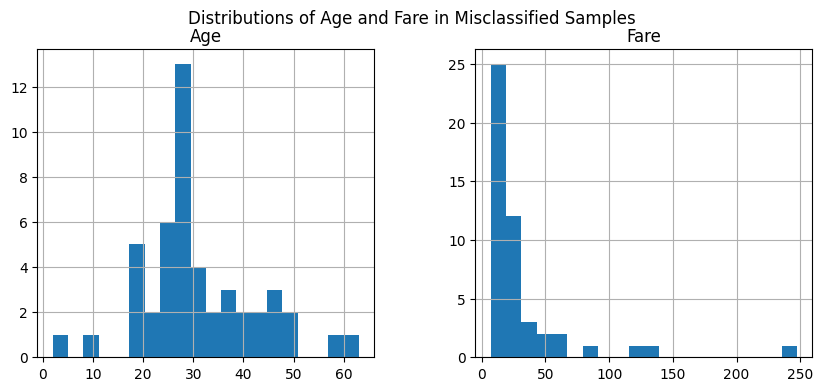

In [ ]:
# Plot histogram of Age and Fare for misclassified samples / 誤分類サンプルのAgeとFareをヒストグラム表示
mistakes[['Age', 'Fare']].hist(bins=20, figsize=(10, 4))
plt.suptitle('Distributions of Age and Fare in Misclassified Samples')
plt.show()

### From the plots, we observe:

- Most misclassified passengers are in the 20–40 age range.
- Many misclassified cases had relatively low fares (under 30), which may contribute to the model underestimating their survival chances.

このグラフから以下のような傾向が見られます：

- 誤分類された乗客は20〜40歳に集中している傾向があります。
- 運賃が30未満のケースが多く、モデルが生存の可能性を過小評価している一因かもしれません。

## 4.17 Crosstab of Pclass and Sex in Misclassified Samples / 誤分類サンプルのPclassと性別のクロス集計
To understand the demographic patterns behind the misclassifications, we examine the relationship between passenger class (`Pclass`) and sex (`Sex`) among the misclassified validation samples.

誤分類された検証サンプルにおいて、乗客の等級（`Pclass`）と性別（`Sex`）の関係を調べ、誤分類が特定の属性に偏っていないかを確認します。

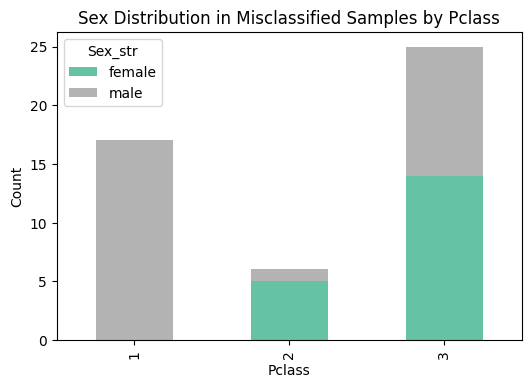

In [ ]:
# Stacked bar chart of misclassified Pclass × Sex　/ 誤分類サンプルのPclassと性別のクロス集計
pd.crosstab(mistakes['Pclass'], mistakes['Sex_str']).plot(
    kind='bar',
    stacked=True,
    colormap='Set2',
    figsize=(6,4)
)
plt.title('Sex Distribution in Misclassified Samples by Pclass')
plt.ylabel('Count')
plt.xlabel('Pclass')
plt.show()

### Interpretation of Crosstab / クロス集計の解釈

From the misclassified samples:

- In **1st class**, only **male passengers** were misclassified.
- In **2nd class**, **mostly females** were misclassified.
- In **3rd class**, both males and females were misclassified, with **females slightly more frequent**.

このクロス集計から、以下のような傾向が見られます：

- **1等船室では男性のみ**が誤分類されています。
- **2等船室では女性の誤分類が多く**、モデルが女性の生存率を過信している可能性があります。
- **3等船室では男女ともに誤分類**されていますが、**女性の方がやや多い**傾向があります。

These patterns suggest that the model may **overestimate survival for females**, especially in lower classes, and **underestimate survival for 1st-class males**.

この傾向から、モデルが特に下位等級の女性に対して**生存確率を過大評価**し、1等船室の男性に対しては**過小評価**している可能性があると考えられます。

## 4.18 Comparison of Age and Fare between Correct and Misclassified Samples / 正解者と誤分類者のAge・Fare比較

To explore whether certain numeric features differ between correctly and incorrectly classified samples, we compare the average `Age` and `Fare` values for each group.

正しく分類されたサンプルと誤分類されたサンプルの間で、`Age`（年齢）と`Fare`（運賃）の平均に差があるかを調べます。

In [ ]:
# Separate correct and misclassified samples / 正解・誤分類サンプルを分ける
correct = df_valid[df_valid['Correct'] == True]
mistakes = df_valid[df_valid['Correct'] == False]

# Compare average Age and Fare / 平均AgeとFareを比較
print("Average Age - Mistakes:", mistakes['Age'].mean(), " / Correct:", correct['Age'].mean())
print("Average Fare - Mistakes:", mistakes['Fare'].mean(), " / Correct:", correct['Fare'].mean())

Average Age - Mistakes: 30.96875  / Correct: 30.017045454545453
Average Fare - Mistakes: 31.216752083333336  / Correct: 33.52191227272727


### 📊 Comparison Results / 比較結果

| Feature  | Misclassified (誤分類) | Correctly Classified (正解) |
| -------- | ------------------- | ------------------------- |
| **Age**  | 30.97               | 30.02                     |
| **Fare** | 31.22               | 33.52                     |

###🧠 Interpretation / 解釈
- The average Age is very similar between the two groups, indicating that age alone is not a strong factor in the model’s misclassification.

- The average Fare is slightly lower among the misclassified samples, suggesting that lower fares might slightly increase misclassification risk, though the difference is small.

- Age（年齢） の平均値には 大きな差はなく、モデルが年齢単独に強く依存しているわけではないと考えられます。

- 一方で Fare（運賃） の平均値は誤分類された方が わずかに低く、運賃が低い乗客は やや誤分類されやすい 傾向が示唆されます（ただし、差は小さいです）。  

###🔍 Conclusion / 結論
While Age appears to have minimal influence on misclassification, the slightly lower Fare among misclassified passengers indicates that fare might subtly affect model decisions. This reinforces the idea that Fare, while informative, may not be sufficient in isolation and should be considered in combination with other features for robust predictions.

Age の影響は限定的である一方、Fare はわずかながら誤分類に関連している可能性があります。
これは、Fare 単体ではなく他の特徴量と組み合わせて使うことで、より正確な予測が可能になることを示唆しています。


## 4.19 Misclassification Rate by Age Group / 年齢帯ごとの誤分類率

To identify which age groups the model tends to misclassify, we calculate the misclassification rate by age range.

モデルがどの年齢層で誤分類しやすいかを把握するために、年齢帯ごとに誤分類率を算出・可視化します。

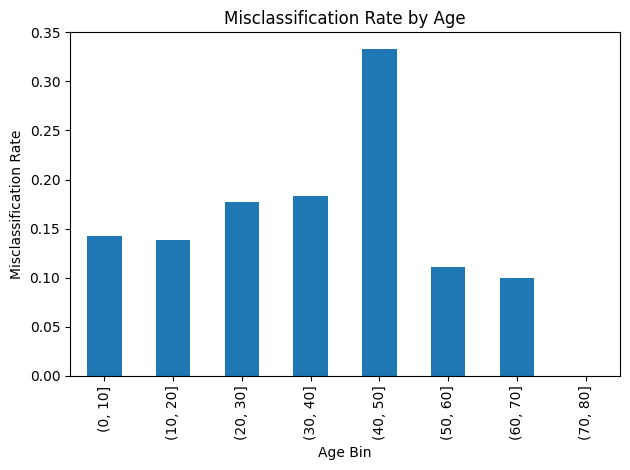

In [ ]:
# Create age bins / 年齢を区切ってカテゴリ化
df_valid['AgeBin'] = pd.cut(df_valid['Age'], bins=[0,10,20,30,40,50,60,70,80])

# Group by age bin and calculate misclassification rate / 年齢帯ごとに誤分類率を計算
age_mis = df_valid.groupby('AgeBin')['Correct'].agg(['count', 'sum'])
age_mis['Misclassification Rate'] = 1 - age_mis['sum'] / age_mis['count']

# Plot misclassification rate / 誤分類率を棒グラフで可視化
age_mis['Misclassification Rate'].plot(kind='bar', title='Misclassification Rate by Age')
plt.ylabel('Misclassification Rate')
plt.xlabel('Age Bin')
plt.tight_layout()
plt.show()

From the plot, we observe that the **misclassification rate is highest for passengers aged 40–50**.

This suggests that the model may be struggling to correctly classify passengers in this age range, possibly due to mixed survival patterns or underrepresented training data for this group.

グラフから、**40〜50歳の年齢帯で誤分類率が最も高い**ことが分かります。

この年代の乗客は、生存・死亡のパターンが混在している可能性があり、モデルが正しく分類するのが難しいのかもしれません。また、この層の学習データが少ない可能性も考えられます。

## 4.20 Misclassification Rate by Fare Range / 運賃帯ごとの誤分類率

We analyze how the misclassification rate varies across fare ranges. This helps identify whether the model performs poorly for passengers in certain fare brackets.

運賃帯ごとの誤分類率を算出・可視化することで、モデルが特定の価格帯で誤分類しやすい傾向がないかを調べます。

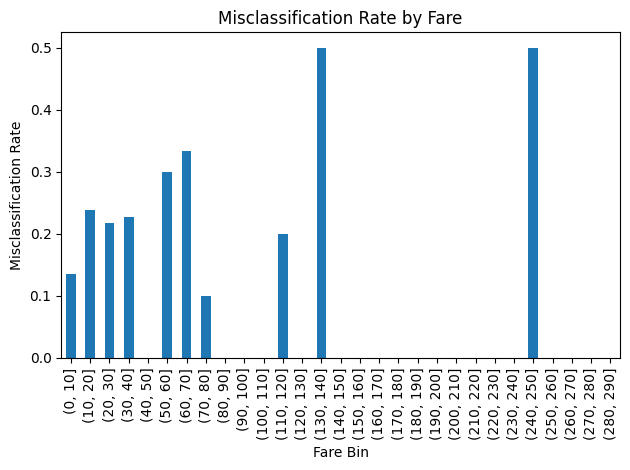

In [ ]:
# Create fare bins every 10 units / 運賃を10刻みでビニング
df_valid['FareBin'] = pd.cut(df_valid['Fare'], bins=range(0, 300, 10))

# Calculate misclassification rate by fare bin / 運賃帯ごとの誤分類率を計算
fare_mis = df_valid.groupby('FareBin')['Correct'].agg(['count', 'sum'])
fare_mis['Misclassification Rate'] = 1 - fare_mis['sum'] / fare_mis['count']

# Plot the misclassification rate / 棒グラフで可視化
fare_mis['Misclassification Rate'].plot(kind='bar', title='Misclassification Rate by Fare')
plt.ylabel('Misclassification Rate')
plt.xlabel('Fare Bin')
plt.tight_layout()
plt.show()

### Observation: High Misclassification in High-Fare Bins / 高額運賃帯での誤分類の傾向

From the plot, we observe that misclassification rates spike in certain high-fare bins:

- **130–140**
- **240–250**

This is surprising, as high fare typically correlates with higher survival (e.g. 1st-class passengers). The elevated error rate suggests that the model may:

- Misclassify wealthy passengers who didn't survive
- Overestimate survival for certain high-fare profiles

These outliers might be special cases (e.g. solo 1st-class men, or passengers with rare combinations of features).

グラフから、以下の高額運賃帯で誤分類率が高くなっていることが分かりました：

- **130〜140**
- **240〜250**

高運賃の乗客（たとえば1等船室）は通常生存率が高いため、これは意外な結果です。モデルが以下のような誤りをしている可能性があります：

- 実際には死亡した裕福な乗客を、生存と誤分類している
- 特定の高額運賃のパターンで、生存確率を過大評価している

これらのケースは、特殊な条件を持つ例外（例：1等船室で単独の男性など）かもしれません。

## 4.21 Detailed Misclassification Analysis by FareBin, Pclass, and Sex / 運賃帯 × 等級 × 性別による詳細な誤分類分析

To detect specific passenger groups where the model performs poorly, we analyze misclassification rates grouped by `FareBin`, `Pclass`, and `Sex`.

モデルが誤分類しやすい具体的な乗客グループを特定するために、`FareBin（運賃帯）× Pclass（乗客等級）× Sex（性別）`で誤分類率を算出し、誤分類率が高い順に並べて確認します。

In [ ]:
# Group by FareBin, Pclass, and Sex / 運賃帯 × 等級 × 性別で集計
grouped = df_valid.groupby(['FareBin', 'Pclass', 'Sex_str'])['Correct'].agg(['count', 'sum'])

# Calculate misclassification rate / 誤分類率 = 1 - 正解率
grouped['Misclassification Rate'] = 1 - grouped['sum'] / grouped['count']

# Sort by highest misclassification rate / 誤分類率が高い順にソートして表示
print(grouped.sort_values('Misclassification Rate', ascending=False).dropna())

                           count  sum  Misclassification Rate
FareBin    Pclass Sex_str                                    
(130, 140] 1      male         1    0                1.000000
(240, 250] 1      male         1    0                1.000000
(50, 60]   3      male         1    0                1.000000
(70, 80]   1      male         1    0                1.000000
(20, 30]   1      male        13    7                0.461538
(10, 20]   3      female      11    6                0.454545
(50, 60]   1      male         5    3                0.400000
(30, 40]   1      male        10    6                0.400000
(0, 10]    3      female      19   12                0.368421
(60, 70]   1      male         3    2                0.333333
(110, 120] 1      male         3    2                0.333333
(10, 20]   3      male         7    5                0.285714
           2      female      11    8                0.272727
(30, 40]   3      female       5    4                0.200000
(20, 30]

### Key Insights from Misclassification by Fare, Pclass, and Sex / 運賃・等級・性別による誤分類分析の重要な気づき
The detailed analysis of misclassification rate by FareBin, Pclass, and Sex reveals specific passenger groups that the model struggles with.

#### 🚨 High Misclassification Groups:
- **(130–140], Pclass 1, male** → 100% misclassified
- **(240–250], Pclass 1, male** → 100% misclassified
- **(50–60], Pclass 3, male** → 100%
- **(70–80], Pclass 1, male** → 100%

These are high-fare, male passengers in 1st class who the model predicted incorrectly.  
This is surprising, as such passengers often had a higher chance of survival historically.

→ **Hypothesis**: These may be exceptional cases (e.g., solo male travelers who perished), or the model overestimates survival based on fare/class alone.

#### ✅ Low Misclassification Groups:
- Many **high-fare females in 1st class** were correctly classified (0% error)
- **Low-fare males in 3rd class** also had relatively low misclassification (e.g. 0.08 in (0–10] bin)

These results suggest the model relies heavily on **Sex, Fare, and Pclass** features, and may struggle with **outliers or overlapping distributions**.

---

運賃・等級・性別ごとの誤分類率を確認したところ、以下のような明確な傾向が見られました。

#### 🚨 誤分類率が高いグループ（モデルの弱点）:
- **(130–140], 1等船室, 男性** → 100% 誤分類
- **(240–250], 1等船室, 男性** → 100% 誤分類
- **(50–60], 3等船室, 男性** → 100%
- **(70–80], 1等船室, 男性** → 100%

これらは「高運賃 × 男性 × 1等船室」で、本来なら生存率が高い傾向があるにもかかわらず、モデルが誤って予測しています。

→ **仮説**：単独の男性旅行者など、他の特徴により生存率が下がっているが、モデルが `Fare` や `Pclass` に過度に依存してしまっている可能性があります。

#### ✅ 正しく分類されたグループ（モデルの得意分野）:
- 高運賃の女性（特に1等船室）は多くが正しく分類されている
- 3等船室の低運賃男性も一部で誤分類率がかなり低い（例：(0–10]で 0.08）

これらの傾向から、モデルは **性別・等級・運賃に強く依存**していることがわかります。  
その一方で、これらが交差して「例外的な属性」になると誤分類する傾向があります。

## 4.22 Misclassification Rate by Pclass and Sex / 等級と性別による誤分類率の可視化  
To understand which broad demographic groups the model struggles with,  
we calculate and plot misclassification rates by `Pclass` and `Sex`.

`Pclass（乗客等級）× Sex（性別）` の組み合わせごとの誤分類率を算出し、棒グラフで可視化します。  
これにより、モデルがどのような属性に対して誤分類しやすいかが分かります。

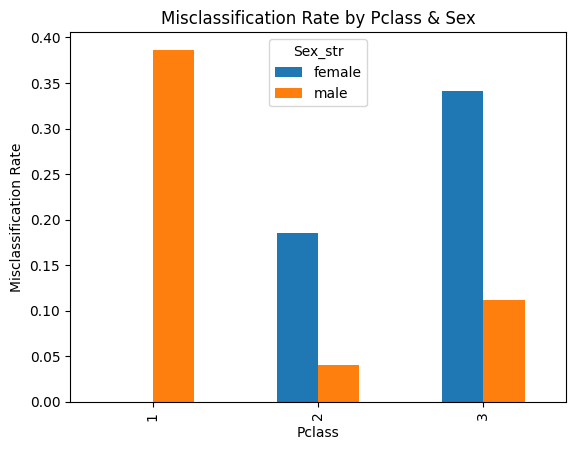

In [ ]:
# Group by Pclass and Sex / 等級と性別でグループ化
total = df_valid.groupby(['Pclass', 'Sex_str'])['Correct'].agg(['count', 'sum'])

# Misclassification Rate = 1 - 正解率
total['Misclassification Rate'] = 1 - total['sum'] / total['count']

# Pivot for bar chart and plot / バーチャート用にピボットして可視化
total['Misclassification Rate'].unstack().plot(kind='bar', title='Misclassification Rate by Pclass & Sex')
plt.ylabel('Misclassification Rate')
plt.show()

### Class-Gender Distribution and Its Impact / 等級 × 性別の偏りとモデル性能への影響  
Upon analyzing the misclassification rates, we notice a **class-gender imbalance**:

- In **1st class**, all misclassified passengers were **male**.
- In **2nd and 3rd class**, **females outnumber males** in the misclassified samples.

これは、モデルが生存率を判断する際に「1等 → 高運賃 → 生存」と単純に学習してしまい、  
1等の男性（実際には死亡者も多い）を過剰に生存と予測してしまう一因となっていると考えられます。

#### Key Observations / 主な観察結果:

- **1st class passengers** in the misclassified group were predominantly male (17 males, 0 females).
- **2nd and 3rd class** misclassified passengers had **more females than males**.
- This gender imbalance varies **by class**, and may skew model behavior.

モデルは `Pclass`, `Sex`, `Fare` を強く重視しているため、  
このようなデータ分布の偏りが、モデルの **学習バイアス** につながっていると考えられます。

---

This insight suggests a need to either:
- Engineer more nuanced features (e.g., family size, deck, group survival),
- Or use methods that reduce overfitting to correlated features.

→ つまり、**Pclass や Sex に依存しすぎない特徴量エンジニアリング**、  
または **交差項や非線形モデル** の導入が有効になる可能性があります。

## 4.23 Misclassification Rate Heatmap by Pclass & Sex / 客室等級と性別ごとの誤分類率ヒートマップ
This heatmap visualizes the misclassification rates by passenger class (Pclass) and gender (Sex).
Darker colors indicate higher misclassification rates, helping us identify which groups the model struggles with.

このヒートマップは、乗客の客室等級（Pclass）と性別（Sex）ごとの誤分類率を示しています。
色が濃いほど誤分類率が高く、モデルがどのグループの予測で苦戦しているかを視覚的に理解できます。

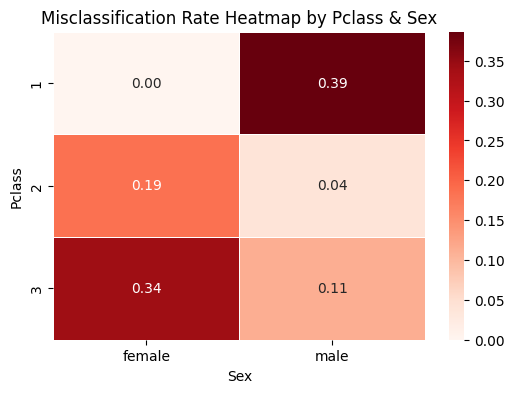

In [ ]:
# データをピボットして、行: Pclass、列: Sex_str に変換
heatmap_data = total['Misclassification Rate'].unstack()

# ヒートマップ描画
plt.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="Reds", linewidths=0.5)
plt.title('Misclassification Rate Heatmap by Pclass & Sex')
plt.ylabel('Pclass')
plt.xlabel('Sex')
plt.show()

### 🔍 Interpretation of Heatmap / ヒートマップの解釈
From the heatmap, we observe that 1st class males (Pclass=1, Sex=male) and 3rd class females (Pclass=3, Sex=female) have the highest misclassification rates, at 0.39 and 0.34 respectively.
These darker cells indicate that the model struggles particularly with these two demographic groups.

ヒートマップから、1等客室の男性（Pclass=1, Sex=male）と3等客室の女性（Pclass=3, Sex=female）の誤分類率が特に高く、それぞれ 0.39、0.34 であることがわかります。
これらのセルの色が濃いことから、モデルがこの2つの属性の乗客に対して、特に予測を誤りやすい傾向があると分かります。  
### 🛠️ Implications for Model Improvement / モデル改善への示唆
These findings suggest that additional feature engineering — such as creating interaction terms (e.g., Pclass x Sex) or incorporating survival rate priors — may help the model better capture these complex patterns.

これらの結果は、例えば Pclass × Sex のような交互作用特徴量を作成したり、生存率の事前知識を特徴に組み込むなど、さらなる特徴量エンジニアリングが有効であることを示唆しています。

## 4.24 📈 SHAP Analysis of Top Features + Key Additions / 上位特徴量＋追加特徴量のSHAP解析  
To better understand the model's decision-making process, we analyze SHAP values for the top 80% most important features, along with the following features that significantly improved the model's score:


*   S (Embarked = S)
*   AgeGroup_Adult
*   Deck_B
*   Pclass_1
*   IsGroup

これらの特徴量は、スコア向上に大きく貢献したため、上位80%の重要特徴量に加えて SHAP 値を可視化して分析します。

モデルがどの情報を重視しているか、そして各特徴が予測にどれほどの影響を与えているかを確認するのが目的です。

SHAP (SHapley Additive exPlanations) values allow us to:

*   Visualize the magnitude and direction of each feature's contribution to theprediction
*   Understand which features push the prediction higher (toward survival) or lower (toward not surviving) for each passenger

This analysis provides interpretability and transparency, helping us not only to validate the model's reasoning but also to identify potential biases or over-reliance on specific features.  

SHAP（SHapley加法的説明）値を用いることで、次のことが可能になります：

*   各特徴量が予測に与える**影響の大きさと方向（正か負か）**を可視化
*   各乗客において、どの特徴が生存の方向に予測を押し上げたか、または非生存の方向に押し下げたかを理解する

この分析によってモデルの判断基準を解釈可能にし、妥当な予測をしているかの検証や、特定の特徴への過度な依存や偏りの検出が可能となります。

In [ ]:
pip install shap

### 4.24.1 🔍 SHAP Value Summary (Bar Plot Interpretation) / SHAP値サマリ（バー・プロットの解釈）
The SHAP bar plot shows the mean absolute SHAP values for each feature, indicating how much each feature contributes, on average, to the model’s output (regardless of direction).
This helps us understand which features the model relies on most heavily in making predictions.

SHAP のバー・プロットは、各特徴量の平均絶対SHAP値を示しており、予測に対してその特徴量が平均してどれほど影響を与えているかを表しています（正方向・負方向を問わず）。
これにより、モデルがどの情報に最も依存して予測しているかを理解できます。

✅ shap_values shape: 891 (16, 2)
✅ 特徴量名: ['Sex', 'Title_Mr', 'Fare', 'Fare_log', 'Age', 'Title_Miss', 'Pclass_3', 'TicketGroupSize', 'Title_Mrs', 'Family', 'Has_Cabin', 'S', 'AgeGroup_Adult', 'Deck_B', 'Pclass_1', 'IsGroup']


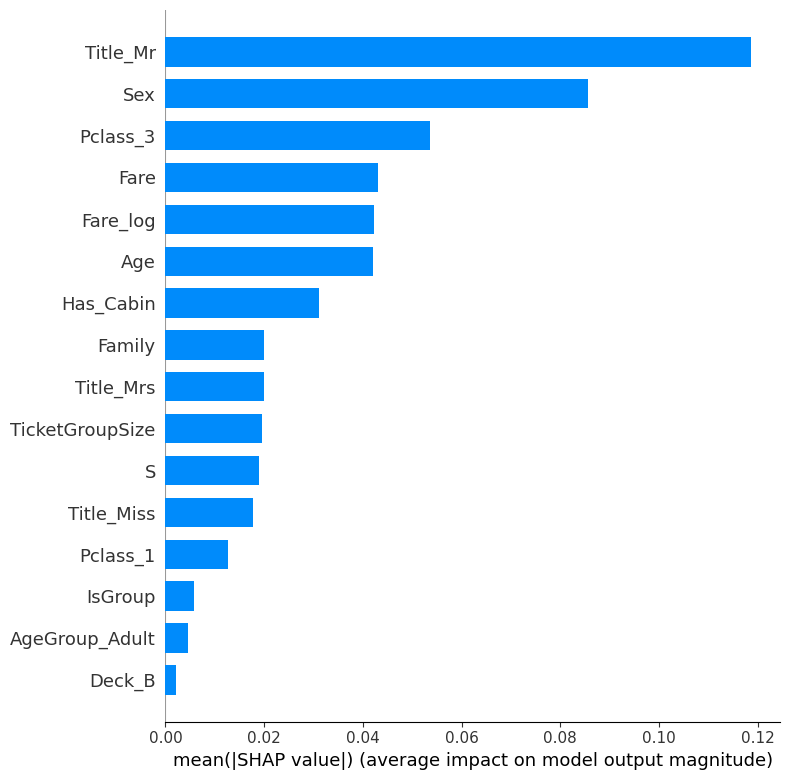

In [ ]:
import shap

# -------------------------
# 1. Data Preparation / モデル学習
# -------------------------
# Final feature set including selected features and manually added impactful ones
# 選択された特徴量に加え、スコア向上に寄与した追加特徴量を含めた最終セット
extended_features = selected_features + ['S', 'AgeGroup_Adult', 'Deck_B', 'Pclass_1', 'IsGroup']

X_extended_df = df_fe4[extended_features]  # Feature matrix / 特徴量データフレーム
y_extended = df_fe4['Survived']           # Target variable / 目的変数（生存フラグ）

# -------------------------
# 2. Model Training / モデル学習
# -------------------------
# Train a Random Forest model on the extended feature set
# 拡張された特徴量セットでランダムフォレストを学習
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_extended_df, y_extended)

# -------------------------
# 3. SHAP
# -------------------------
# Use TreeExplainer for SHAP value calculation (compatible with tree-based models)
# 木構造モデルに対応した TreeExplainer を使って SHAP 値を計算
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_extended_df)  # Returns a shap.Explanation object
                                        # shap.Explanation オブジェクトが返される（サンプル×特徴量×クラス）

# -------------------------
# 4. Verification and Debug Output / 検証と出力
# -------------------------
# Print the number of SHAP value samples and the shape of the first element
# SHAP 値のサンプル数と最初の要素の形状を出力して確認
print("✅ shap_values shape:", len(shap_values), shap_values[0].shape)

# Print the names of the features used
# 使用された特徴量名を出力
print("✅ 特徴量名:", X_extended_df.columns.tolist())

# -------------------------
# 5. Visualization (Bar Plot) / 可視化（bar プロット
# -------------------------
# Since this is a binary classification, we use only the SHAP values for class 1 (Survived=1)
# 2クラス分類のため、クラス1（=生存）の SHAP 値のみを使用する
shap.summary_plot(shap_values[..., 1], X_extended_df, plot_type="bar")

### 📌 Top Features Identified /  特に影響の大きかった特徴量

1. **`Title_Mr`** – This feature had the highest SHAP value. The model strongly uses this title to identify male adults, who historically had lower survival rates.

2. **`Sex`** – The gender of the passenger remains one of the strongest predictors of survival. Female passengers had much higher survival rates due to the "women and children first" evacuation policy.

3. **`Pclass_3`** – Being in 3rd class negatively influences survival predictions. This suggests the model learned that lower-class passengers had fewer chances of survival.

These findings validate the model’s logic and are consistent with known patterns from the Titanic dataset.  


---
1. **`Title_Mr`** – 最もSHAP値が高かった特徴です。モデルはこの敬称を利用して、大人の男性（歴史的に生存率が低かった）を特定していると考えられます。

2. **`Sex`** – 性別は依然として生存予測において非常に強力な特徴です。女性は「女性と子供を優先する」という避難方針の影響で、生存率が高かったためです。

3. **`Pclass_3`** – 3等客室の乗客であることは、生存予測にマイナスの影響を与えています。これはモデルが「下層クラスの乗客は生存の可能性が低い」という傾向を学習していることを示唆します。

これらの結果は、モデルの予測ロジックが妥当であり、Titanicデータセットで知られている傾向とも一致していることを裏付けています。

## 4.24.2 📈 SHAP Summary Plot (Dot Plot) / SHAPサマリープロット（ドットプロット）  

This plot shows the distribution of SHAP values for each feature across all samples.  
Each point represents a SHAP value for a single passenger, and its color reflects the feature value (e.g., red = high, blue = low).

From the plot, we can observe not only which features are important, but also **how** they affect the prediction direction (positive → survival, negative → non-survival).  
For example, higher values of `Sex` (i.e., male = 1) tend to push predictions toward non-survival (left), while lower values (female = 0) push toward survival (right).

This helps reveal **nonlinear relationships and interaction effects** that may not be obvious from feature importance alone.  
このプロットは、各特徴量における全サンプルのSHAP値の分布を示しています。  
1つ1つの点が1人の乗客におけるSHAP値を表しており、色はその特徴量の値を示しています（赤 = 高い値、青 = 低い値）。

このプロットを通して、重要な特徴量だけでなく、それらが**予測にどのような方向で影響しているか**（右 = 生存方向、左 = 非生存方向）も確認できます。  
例えば、`Sex`の値が高い（= 男性）と予測が非生存側（左）に押され、低い（= 女性）と生存側（右）に押される傾向が見られます。

単なる特徴量の重要度では見えにくい、**非線形な関係性や特徴量間の相互作用**を理解する手がかりにもなります。


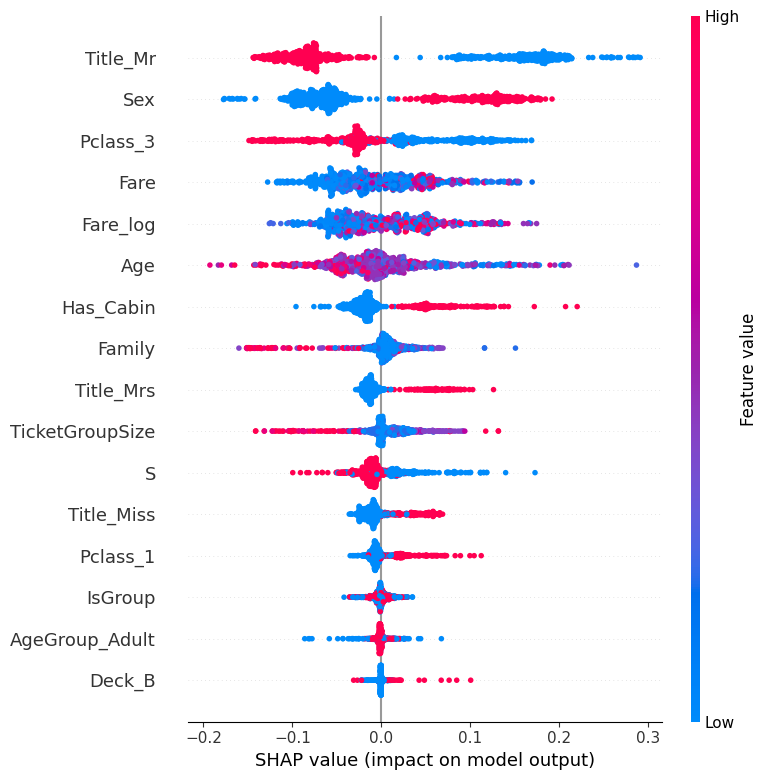

In [ ]:
shap.summary_plot(shap_values[..., 1], X_extended_df)

### 🔍 Detailed Interpretation of SHAP Summary Plot / SHAPサマリープロットの詳細な解釈

From the SHAP dot plot, we can derive how specific feature values push the model’s predictions toward survival or non-survival.

- **Title_Mr**: Most of the red points (high value = Mr) are concentrated on the **left side**, indicating a strong negative impact on survival prediction. The model consistently associates this title with lower survival probability.

- **Sex**: Blue points (female = 0) are mainly located on the **left**, meaning that in some cases the model predicts lower survival probability for females. Red points (male = 1) are often on the **right**, showing that being male sometimes increases the prediction. This may indicate complex interactions with other features like `Title` or `Pclass`.

- **Pclass_3**: Red points (3rd class = 1) are slightly more concentrated on the **left**, meaning that being in 3rd class tends to lower the survival prediction. Blue points (not 3rd class) are more on the **right**, pushing predictions toward survival. However, the distribution is more balanced compared to the other features, suggesting that the impact of `Pclass_3` is less extreme but still significant.  


---


SHAPのドットプロットを分析することで、特定の特徴値がモデルの予測を「生存」「非生存」のどちらに押しているかを理解できます。

- **Title_Mr**：赤い点（高い値 = Mr）が**左側**に多く分布しており、生存予測に対して強いマイナスの影響を持っていることが分かります。モデルはこの敬称を「生存率が低い人物」として一貫して扱っているようです。

- **Sex**：青い点（女性 = 0）が**左側**に多く分布し、女性が生存しにくいと予測されたケースがあることを示しています。逆に赤い点（男性 = 1）は**右側**に分布しており、男性であっても生存予測が高くなるケースがあることを示しています。これは、`Title` や `Pclass` など他の特徴量との**相互作用**の影響が反映されている可能性があります。

- **Pclass_3**：赤い点（3等客室 = 1）は**左側**にやや多く分布し、生存予測を下げる傾向があります。青い点（それ以外）は**右側**に多く、生存の方向に影響しています。ただし、他の特徴に比べて分布はよりバランスが取れており、`Pclass_3`の影響は極端ではないものの、依然として重要であることが分かります。


## 4.24.3 🔎 SHAP Waterfall Plot: Individual Prediction Breakdown / SHAPウォーターフォールプロット：個別予測の内訳

To understand **how the model makes predictions for a single passenger**, we used the SHAP waterfall plot.  
It visualizes how each feature pushed the prediction score up or down starting from the base value.

Below is the waterfall plot for passenger **#300**.

- Red bars show features that **increase** the predicted probability of survival.
- Blue bars show features that **decrease** the probability.

This plot clearly shows **which features were most responsible** for this particular prediction.  
It complements the summary plot by adding a case-level explanation.  

---

モデルが**特定の乗客に対してどのように予測を行っているか**を理解するために、SHAPのウォーターフォールプロットを使いました。  
このプロットでは、ベースライン（平均的な予測値）からスタートして、各特徴量が予測をどれだけ押し上げた／押し下げたかを視覚的に確認できます。

以下は、乗客**#300**のウォーターフォールプロットです。

- 赤いバーは、生存の予測スコアを**上げた要因**  
- 青いバーは、生存の予測スコアを**下げた要因**

このプロットにより、「なぜこの乗客がこう予測されたのか」を**特徴量ごとに明確に可視化**できます。  
全体傾向を示すsummary plotと組み合わせることで、分析の深みと納得感が大きく増します。

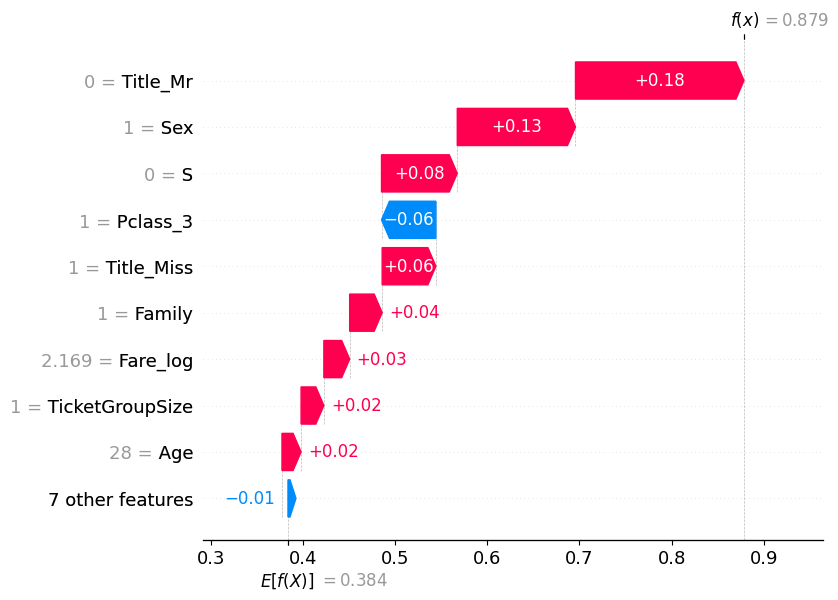

In [ ]:
# -------------------------
# 1. Extract SHAP values for class 1 (Survived) / クラス1（生存）に対するSHAP値を抽出
# -------------------------
# The shape of shap_values.values is (891, 14, 2): 891 passengers × 14 features × 2 classes
# shap_values.values の形は (891, 14, 2)：891人 × 14特徴量 × 2クラス
# So we extract only the SHAP values for class 1 (survived)
# そのうち「クラス1（生存）」に対するSHAP値だけを取り出す
values = shap_values.values[:, :, 1]  # Resulting shape is (891, 14) / 結果の形は (891, 14)

# -------------------------
# 2. Extract base values (baseline prediction per sample) / ベース値（サンプルごとの予測ベースライン）を抽出
# -------------------------
# Base values represent the expected output of the model before seeing any features
# ベース値は、特徴量を考慮する前の「平均的な予測値（ベースライン）」を表す
# If the SHAP explanation is for multiple classes, we extract class 1's base values
# 複数クラスの場合は、生存クラス（クラス1）のベース値を取り出す
base_values = shap_values.base_values[:, 1] if shap_values.base_values.ndim > 1 else shap_values.base_values

# -------------------------
# 3. Rebuild a SHAP Explanation object for class 1 only / クラス1（生存）だけの SHAP Explanation オブジェクトを再構築
# -------------------------
# This allows us to use SHAP plots like waterfall for class 1 (survived) only
# これにより、生存クラスのSHAP値だけを使ったウォーターフォールなどのプロットが可能になる
class1_shap = shap.Explanation(
    values=values,                     # SHAP values for class 1 / クラス1のSHAP値
    base_values=base_values,          # Base values for class 1 / クラス1のベース値
    data=X_extended_df,               # Original input data / 元の入力データ
    feature_names=X_extended_df.columns  # Feature names / 特徴量名
)

# -------------------------
# 4. Plot SHAP waterfall for a specific passenger / 特定の乗客に対するSHAPウォーターフォールプロットを描画
# -------------------------
# Waterfall plot shows how each feature contributes to the final prediction step by step
# ウォーターフォールプロットは、各特徴量が最終予測に段階的にどのように寄与したかを示す
shap.plots.waterfall(class1_shap[300]) # Example: passenger #300 / 例：300番目の乗客

### 🚩 Key Positive Contributors for This Passenger / この乗客に対する主要なプラスの寄与特徴量

For this passenger (#300), the top features that increased the predicted survival probability were:

- **Title_Mr** with a SHAP value of +0.18  
- **Sex** with a SHAP value of +0.13  
- **S** (embarked at Southampton) with a SHAP value of +0.08  

These features pushed the model’s prediction towards survival.

---

この乗客（#300）において、生存予測を押し上げた主な特徴量は以下の通りです：

- **Title_Mr**（敬称Mr）: SHAP値 +0.18  
- **Sex**（性別）: SHAP値 +0.13  
- **S**（サウサンプトン乗船）: SHAP値 +0.08  

これらの特徴量がモデルの予測を生存方向へと後押ししました。


## 4.24.4 SHAP Dependence Plots / SHAP依存プロット

For each feature in our extended set, we plotted SHAP dependence plots.  
These plots show how the value of a feature relates to its impact on the prediction, helping us understand feature interactions and nonlinear effects.

拡張特徴量セットの各特徴量について、SHAP依存プロットを作成しました。  
このプロットは、特徴量の値が予測にどのように影響するかを示し、特徴間の相互作用や非線形効果の理解に役立ちます。

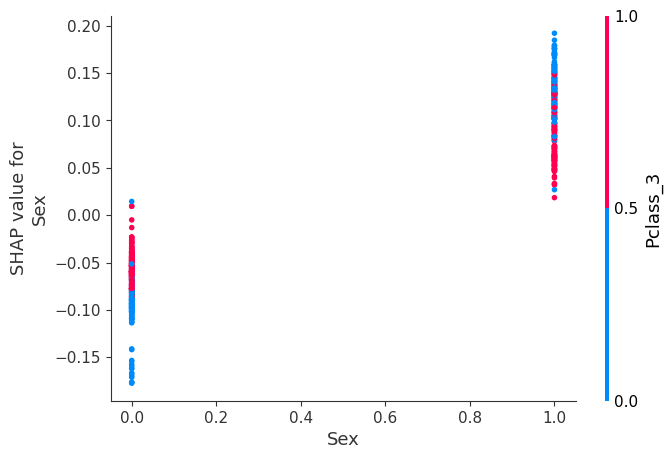

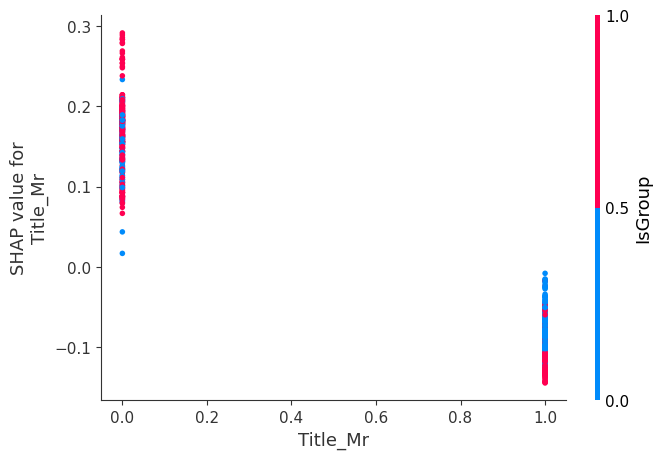

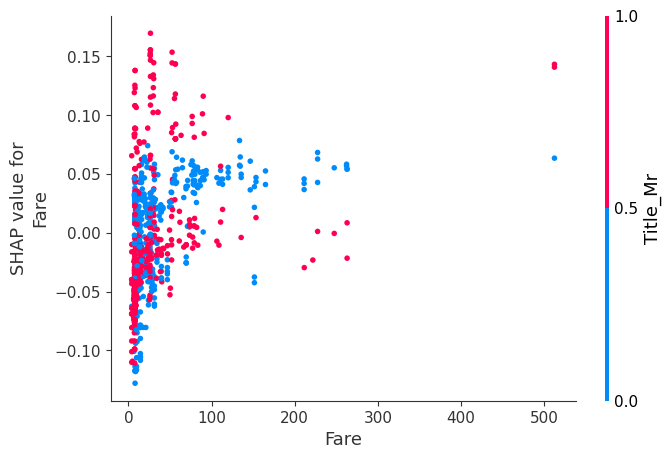

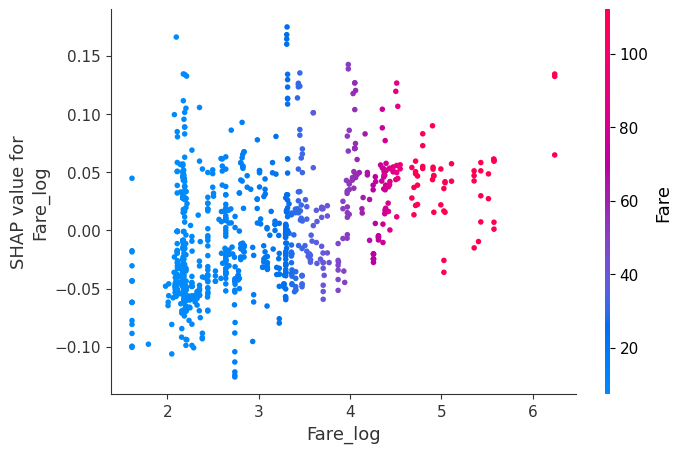

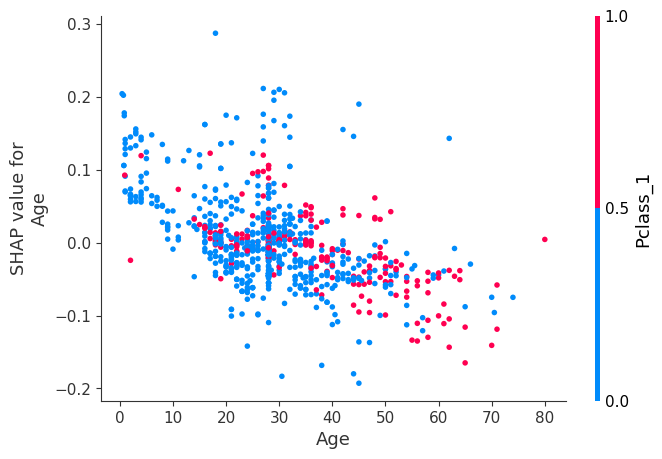

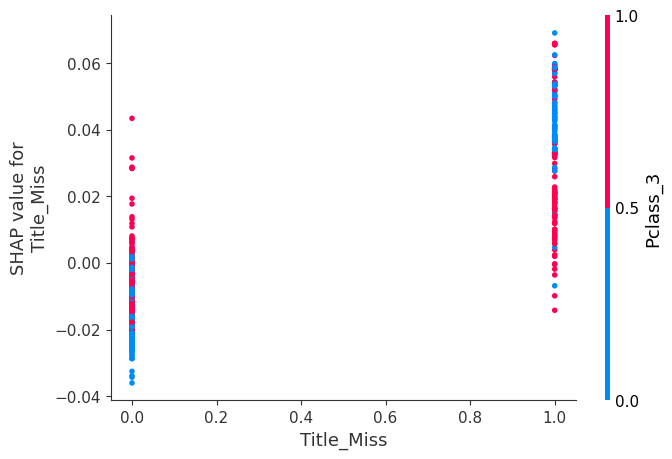

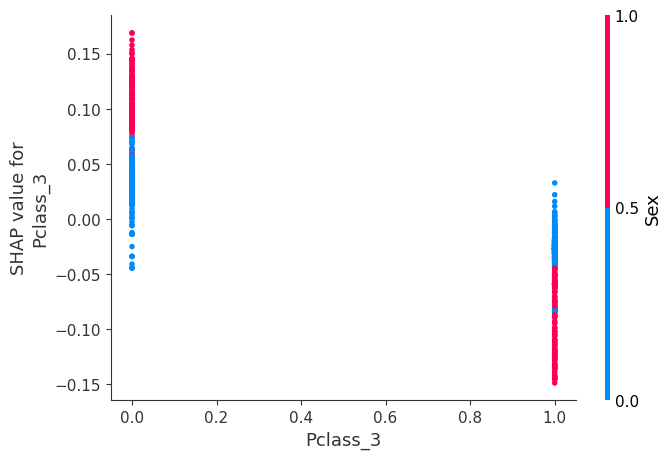

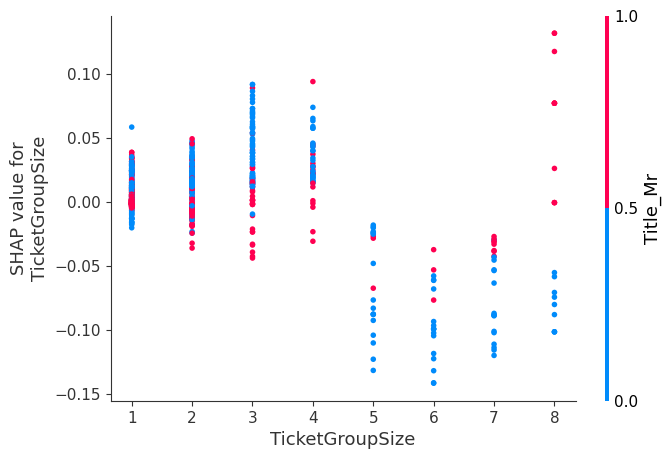

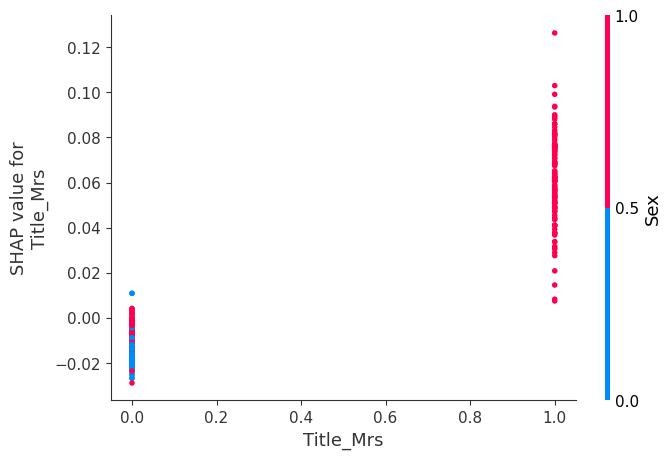

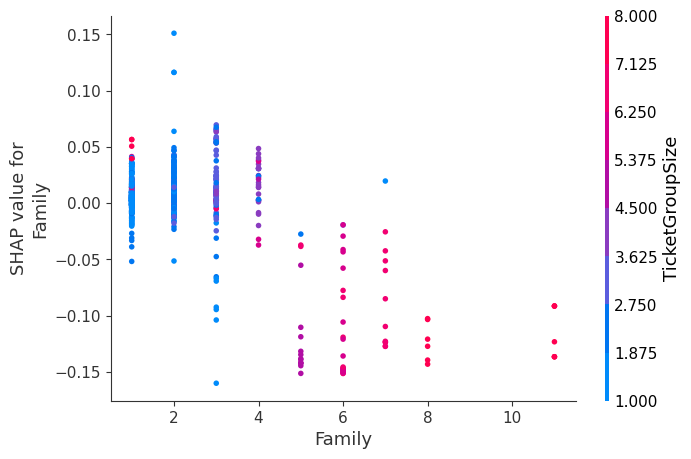

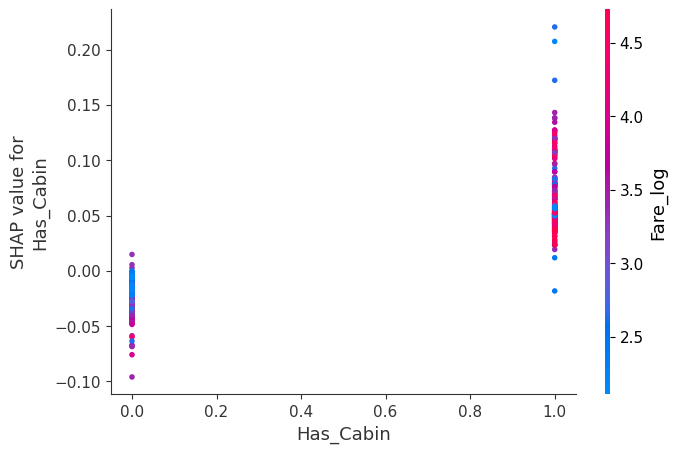

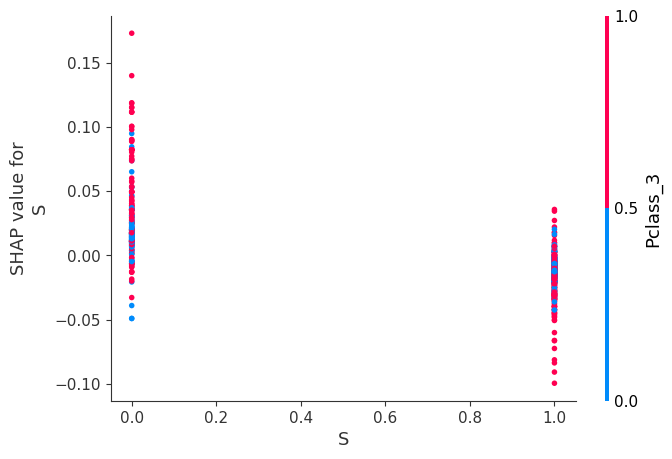

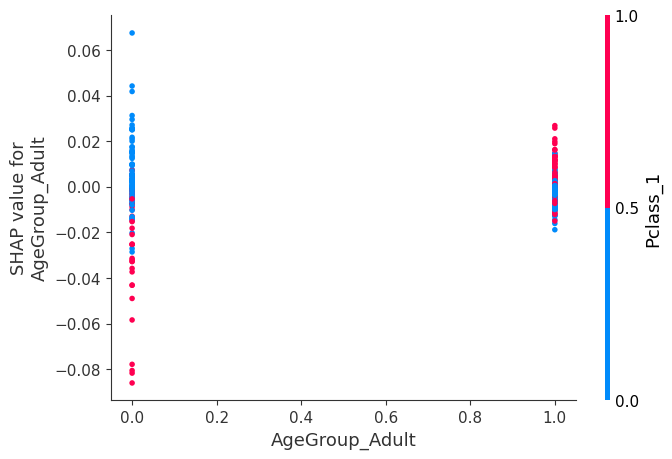

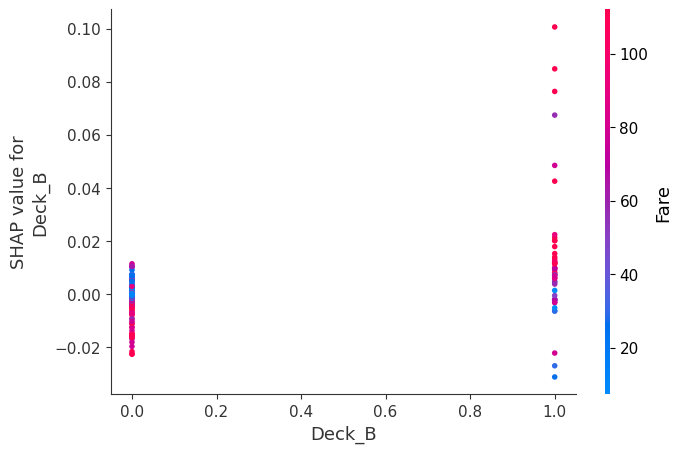

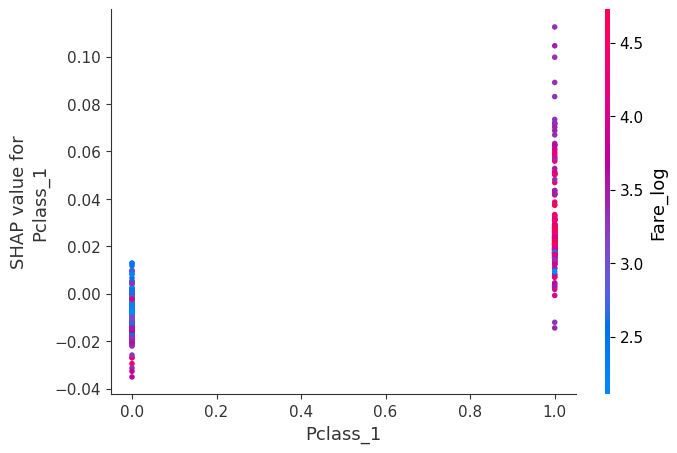

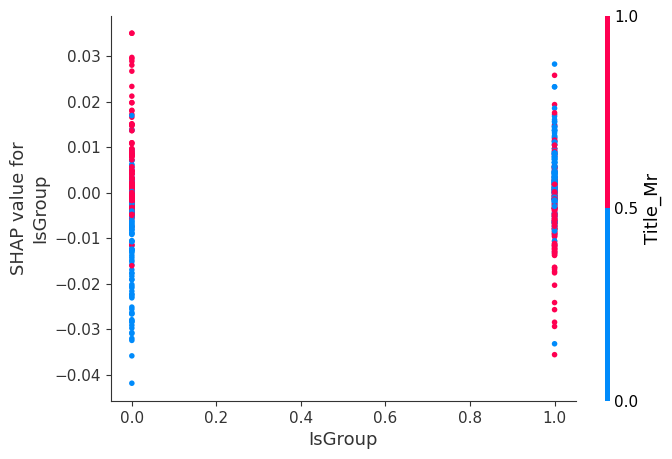

In [ ]:
# Extract only SHAP values for class 1 (Survived=1)
# クラス1（生存=1）に対するSHAP値だけを抽出
class1_shap = shap_values[..., 1]

# Create dependence plots for each feature in extended_features
# extended_features に含まれる各特徴量について、SHAP依存プロットを作成
for feat in extended_features:
    shap.dependence_plot(
        feat,                         # Feature name / 特徴量名
        shap_values=class1_shap.values,  # SHAP values for class 1 / クラス1のSHAP値
        features=X_extended_df,          # Original input features / 元の特徴量データ
        feature_names=X_extended_df.columns  # Feature names / 特徴量名リスト
    )

### Interaction Effects Observed / 観察された特徴量の相互作用効果

- **Sex × Pclass_3**: Males in 3rd class have relatively higher survival rates compared to others.  
  This indicates that the **interaction between gender and passenger class** strongly influences the prediction.

- **Title_Mr × Family**: Females with family members present tend to have lower survival rates.  
  This suggests a strong **interaction between title (gender/age) and family presence** affecting survival predictions.

---


- **性別 × 3等客室（Sex × Pclass_3）**: 3等客室の男性は他と比べて比較的生存率が高い傾向があります。  
  これは、**性別と客室階級の相互作用**が予測に強く影響していることを示しています。

- **敬称Mr × 家族の有無（Title_Mr × Family）**: 家族がいる女性は生存率が低い傾向が見られます。  
  これは、**敬称（性別や年齢）と家族の有無の相互作用**が生存予測に大きな影響を与えていることを示唆しています。


## 4.24.5 SHAP Dependence of Family by Title / タイトル別の家族特徴量のSHAP依存関係

We plotted the SHAP values of the 'Family' feature separately for passengers with titles Mr, Mrs, and Miss.  
This allows us to compare how family size affects survival predictions differently depending on age and gender group.

家族の特徴量（Family）のSHAP値を、敬称（Title）がMr、Mrs、Missの乗客別に分けて描画しました。  
これにより、年齢・性別の異なるグループで家族構成が生存予測にどのように影響するかを比較できます。


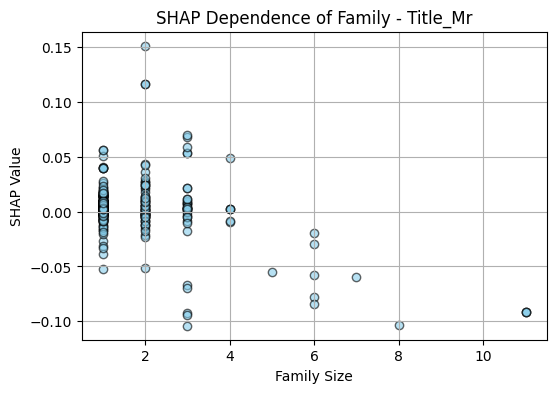

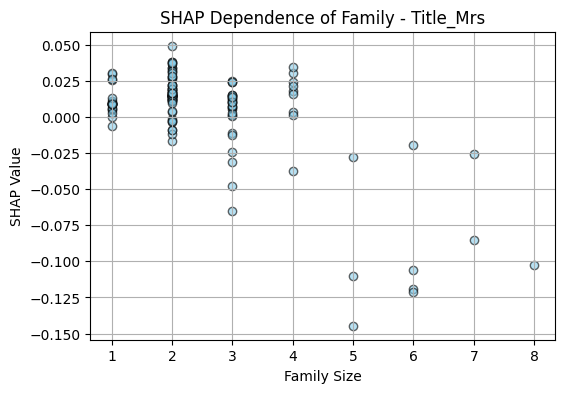

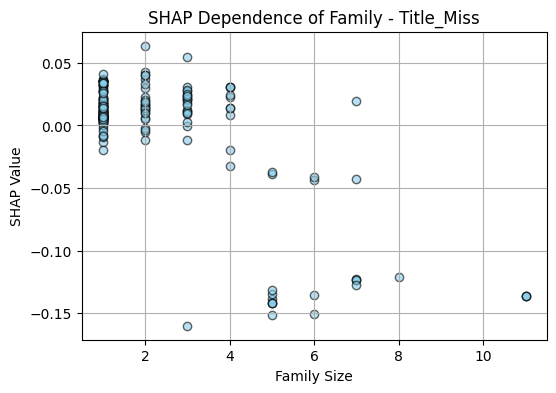

In [ ]:
for title in ['Title_Mr', 'Title_Mrs', 'Title_Miss']:
    mask = X_extended_df[title] == 1  # Filter samples by title / 敬称でフィルタ
    plt.figure(figsize=(6,4))
    plt.scatter(
        X_extended_df.loc[mask, 'Family'],  # x: Family size / x軸：家族人数
        class1_shap.values[mask, X_extended_df.columns.get_loc('Family')],  # y: SHAP value for Family / y軸：FamilyのSHAP値
        alpha=0.6,
        c='skyblue',  # 色を統一すると見やすい
        edgecolor='k'
    )
    plt.title(f'SHAP Dependence of Family - {title}')  # タイトル
    plt.xlabel('Family Size')     # x軸ラベル
    plt.ylabel('SHAP Value')      # y軸ラベル
    plt.grid(True)
    plt.show()

### Observed Trends in Family Size SHAP Values by Title / タイトル別の家族サイズSHAP値の傾向

- For **Mr**, family sizes between 1 and 3 are most common and have higher SHAP values than family sizes 4 to 10.  
- For **Mrs**, family sizes between 1 and 4 are most common and have higher SHAP values than family sizes 5 to 10.  
- For **Miss**, family sizes between 1 and 4 are most common and have higher SHAP values than family sizes 5 to 10.  

This suggests that smaller family sizes tend to contribute more positively to survival predictions across these titles.  

---

- **Mr**では、家族人数が1〜3のグループが多く、4〜10のグループよりも高いSHAP値を示しています。  
- **Mrs**では、家族人数が1〜4のグループが多く、5〜10のグループより高いSHAP値です。  
- **Miss**でも、家族人数1〜4のグループが多く、5〜10より高いSHAP値の傾向があります。  

これは、これらの敬称の乗客において、家族人数が少ない方が生存予測によりポジティブに寄与しやすいことを示唆しています。  

## 4.25 Combined Feature: Sex_Pclass / 性別とPclassの組み合わせ特徴量

We created a new categorical feature by combining `Sex` and `Pclass`, named `Sex_Pclass` (e.g., `female_P1`, `male_P3`).  
This feature captures the interaction between gender and passenger class, which is known to be strongly related to survival probability on the Titanic.  
To evaluate its effectiveness, we examined the prediction accuracy for each group and found noticeable differences.

性別 (`Sex`) とチケットクラス (`Pclass`) を組み合わせて、新たなカテゴリ変数 `Sex_Pclass`（例: `female_P1`, `male_P3`）を作成しました。  
この特徴量は、性別と社会階級の相互作用を表現しており、タイタニック号における生存率と強く関連していると考えられます。  
有効性を評価するために、各グループの予測正解率を調べたところ、顕著な違いが確認できました。


In [ ]:
# Create a combined categorical feature 'Sex_Pclass' by combining Sex and Pclass
# 性別とチケットクラスを組み合わせて、新しいカテゴリ変数 'Sex_Pclass' を作成
df_valid['Sex_Pclass'] = df_valid['Sex_str'] + '_P' + df_valid['Pclass'].astype(str)

# Calculate the accuracy (percentage of correct predictions) for each Sex_Pclass group
# 各 'Sex_Pclass' グループごとに予測の正解率（Correct列の平均）を算出
group_accuracy = df_valid.groupby('Sex_Pclass')['Correct'].mean().sort_values()

# Display the sorted accuracy by group
# グループごとの正解率を昇順で表示
print(group_accuracy)

Sex_Pclass
male_P1      0.613636
female_P3    0.658537
female_P2    0.814815
male_P3      0.887755
male_P2      0.960000
female_P1    1.000000
Name: Correct, dtype: float64


##4.26 Heatmap: Accuracy by Sex and Pclass / 性別とPclassごとの正解率ヒートマップ  
To visualize the overall pattern, we created a heatmap showing accuracy across Sex and Pclass.

次に、全体の傾向を視覚的に確認するため、性別とPclassごとの正解率をヒートマップで可視化しました。

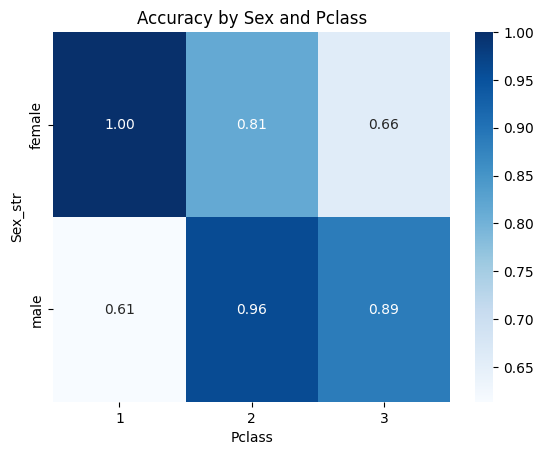

In [ ]:
heatmap_df = df_valid.pivot_table(index='Sex_str', columns='Pclass', values='Correct', aggfunc='mean')

sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap="Blues")
plt.title("Accuracy by Sex and Pclass")
plt.show()

### Observations on Prediction Accuracy by Sex_Pclass / Sex_Pclassごとの正解率に関する考察

The prediction accuracy varies significantly depending on the combination of Sex and Pclass:

- `female_P1`: **100% accuracy**, suggesting the model perfectly predicts survival for first-class female passengers.
- `male_P2`: **96% accuracy**, which is surprisingly high for male passengers, indicating that second-class males may have clearer survival patterns in the data.
- `male_P3`: **88.8% accuracy**, indicating good performance even in third class.
- `female_P2`: **81.5% accuracy**, still quite strong, possibly due to both gender and class advantages.
- `female_P3`: **65.9% accuracy**, showing that third-class females are harder to predict correctly.
- `male_P1`: **61.4% accuracy**, the lowest among all groups, suggesting that first-class males have less consistent survival patterns from the model's perspective.

These results show that the combination of gender and class has a strong influence on the model's ability to make accurate predictions. Particularly, female passengers in higher classes are the most predictable, while male passengers in first class are the least.

---

性別とPclassを組み合わせた `Sex_Pclass` によって、モデルの予測正解率には大きな差があることがわかります。

- `female_P1` は **100%の正解率** で、1等船室の女性に対してモデルが非常に強く学習できていることを示しています。
- `male_P2` は **96%の正解率** で、男性としては非常に高い精度で予測されています。2等船室の男性は比較的予測しやすい傾向があると考えられます。
- `male_P3` も **88.8%** と高精度で、予測が安定していることがわかります。
- `female_P2` は **81.5%** で、性別・クラス両方の影響を受けていると考えられます。
- `female_P3` は **65.9%** とやや低めで、3等船室の女性の予測はやや難しい傾向があります。
- `male_P1` は **61.4%** と最も低く、1等船室の男性はデータ上で生存・非生存の傾向がはっきりしないのかもしれません。

これらの結果から、**性別とクラスの組み合わせはモデルの予測精度に大きな影響を与えている**ことがわかります。特に高等クラスの女性は予測しやすく、1等船室の男性は最も難しいグループであるといえます。


## 4.27 Prediction Accuracy by Title_Mr × Family Size / Mr敬称と家族人数の組み合わせによる予測正解率

To explore whether family size affects prediction performance differently for male passengers (Title = Mr),  
we created a new combined categorical feature: `Title_Family`, which concatenates the `Title_Mr` flag (1 if Mr, 0 otherwise) and the number of family members.  
We then calculated the prediction accuracy for each group defined by this combined feature.

男性乗客（敬称がMr）の予測精度が家族人数によって異なるかを調べるため、  
`Title_Mr`（Mrであれば1、それ以外は0）と`Family`（家族人数）を結合した交差特徴量 `Title_Family` を作成しました。

次に、この新しい組み合わせ特徴量ごとに予測の正解率を算出しました。

In [ ]:
# Create a new categorical feature 'Title_Family' by combining Title_Mr (1 or 0) and Family size
# Title_Mr（敬称がMrかどうか）とFamily（家族人数）を組み合わせて、新しいカテゴリ変数 'Title_Family' を作成
df_valid['Title_Family'] = df_valid['Title_Mr'].astype(str) + '_F' + df_valid['Family'].astype(str)

# Calculate prediction accuracy (mean of 'Correct') for each Title_Family group
# 各 'Title_Family' グループごとに予測の正解率（Correct列の平均）を算出
group_accuracy = df_valid.groupby('Title_Family')['Correct'].mean().sort_values()

# Display the accuracy by group in ascending order
# グループごとの正解率を昇順で表示
print(group_accuracy)

Title_Family
1_F4    0.500000
0_F3    0.708333
0_F7    0.750000
1_F2    0.764706
0_F1    0.782609
0_F5    0.833333
1_F1    0.840336
0_F2    0.848485
0_F6    1.000000
0_F4    1.000000
1_F3    1.000000
1_F5    1.000000
1_F6    1.000000
Name: Correct, dtype: float64


## 4.28 Misclassification Rate (Bar Plot) / 誤分類率の棒グラフ

To better understand which Title-Family groups are most challenging for the model,  
we calculated and visualized the **misclassification rate** (1 - accuracy) for each `Title_Family` category.  
This visualization clearly highlights where the model is struggling the most.  

どの `Title_Family`（敬称Mrと家族人数の組み合わせ）グループがモデルにとって難しいかを明確にするために、  
各グループの**誤分類率（1 - 正解率）**を算出し、棒グラフで可視化しました。  
この可視化により、モデルがどのグループの予測に最も苦戦しているかが一目でわかります。

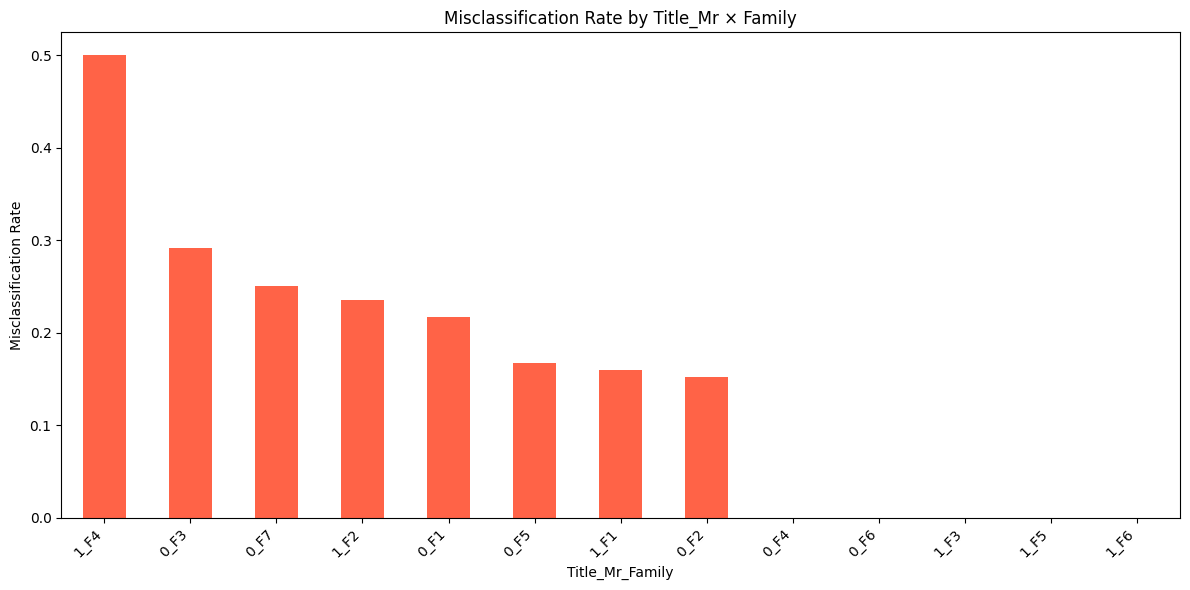

In [ ]:
# Calculate misclassification rate for each group
# グループごとの誤分類率を計算
title_family_error = 1 - df_valid.groupby('Title_Family')['Correct'].mean()

# Sort by misclassification rate in descending order
# 誤分類率が高い順にソート
title_family_error = title_family_error.sort_values(ascending=False)

# Visualize the misclassification rates with a bar plot
# 誤分類率を棒グラフで可視化
plt.figure(figsize=(12, 6))
title_family_error.plot(kind='bar', color='tomato')
plt.title('Misclassification Rate by Title_Mr × Family')
plt.ylabel('Misclassification Rate')
plt.xlabel('Title_Mr_Family')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

### Observations / 考察

- The group **`1_F4`** (Mr with 4 family members) had the **highest misclassification rate (50%)**,  
  suggesting that this group may have more ambiguous or mixed survival signals.
- Other Mr groups like `1_F2` and `1_F1` also showed moderate misclassification rates,  
  indicating that male passengers with small families are more prone to incorrect predictions.
- In contrast, non-Mr groups (`0_F4`, `0_F6`, etc.) generally had **very low error rates**,  
  further supporting the idea that male title groups are harder for the model to classify.  

This kind of group-wise error analysis helps identify areas where the model might need additional features, adjustments, or focused attention.

---

- **`1_F4`**（家族4人のMr）が**誤分類率50%**と最も高く、  
  このグループの生存パターンは曖昧で、モデルにとって難しいと考えられます。
- 他にも、`1_F2`, `1_F1` などの少人数のMrグループでも誤分類率がやや高く、  
  小規模な家族を持つ男性乗客の予測が難しい傾向があります。
- 一方で、`0_F4`, `0_F6` などの**非Mrグループは誤分類率が非常に低く**、  
  やはり**男性乗客の分類が相対的に難しい**ことが確認されました。  
  
このようなグループごとの誤分類分析は、モデルの改善余地や追加の特徴量設計のヒントを与えてくれます。

## 🔷 4.29 Feature Selection for Final Model / 最終モデルに向けた特徴量選定

To build a more interpretable and efficient model, we reduce the feature set to only the most impactful ones.

モデルの解釈性と効率性を高めるため、使用する特徴量を**影響の大きいもののみに絞り込み**ます。

---

### Step 1: Top Features Based on SHAP / SHAPによる主要特徴量の選定

We start by selecting the top **~80% of cumulative importance** from SHAP values and/or feature importances.  
This forms the core of our model, containing features with the strongest direct impact on prediction.

まず、SHAP値や特徴量重要度に基づいて、累積で約**上位80%**を占める主要な特徴量を選定します。  
これがモデルの基盤となり、**予測に直接的な影響を与える特徴**を中心に構成されます。

---

### Step 2: Add Selected High-Impact Interaction Features / 効果的な組合せ特徴の追加

In addition to the top features, we add a **small number of carefully chosen interaction features**,  
based on their effectiveness observed in misclassification analysis and SHAP dependence plots.
Examples of these include:

- `Sex_Pclass_male_1`: 1st class males with distinct survival patterns  
- `Sex_Pclass_female_3`: 3rd class females with lower survival accuracy  
- `Title_Mr_Family_4`: Mr passengers with 4 family members – a high-error group

By doing this, we preserve the model's simplicity while still incorporating insights from deeper error analysis.  

また、SHAP依存プロットや誤分類分析で**効果的だった交差特徴量**の中から、  
**特に強い傾向が見られた少数の組み合わせ**だけを選抜して追加します。

追加された具体例：

- `Sex_Pclass_male_1`：明確な生存パターンを持つ1等男性  
- `Sex_Pclass_female_3`：生存予測が難しかった3等女性  
- `Title_Mr_Family_4`：誤分類率が特に高かった、家族4人のMr  

このようにすることで、**シンプルなモデル構造を維持しながら、誤分類や相互作用の分析結果を適切に反映**することができます。  


In [ ]:
# =========================
# 1. 特徴量セットをコピーして構築開始
# =========================
df_fe5 = df_fe4.copy()
df_fe5_test = df_fe4_test.copy()

# 学習・テスト結合（特徴量整合のため）
df_fe5_all = pd.concat([df_fe5, df_fe5_test], axis=0).reset_index(drop=True)

# =========================
# 2. 相互作用特徴量の追加
# =========================
df_fe5_all['male_1_flag'] = ((df_fe5_all['Sex'] == 0) & (df_fe5_all['Pclass_1'] == 1)).astype(int)
df_fe5_all['female_3_flag'] = ((df_fe5_all['Sex'] == 1) & (df_fe5_all['Pclass_3'] == 1)).astype(int)
df_fe5_all['mr_family_4_flag'] = ((df_fe5_all['Title_Mr'] == 1) & (df_fe5_all['Family'] == 4)).astype(int)

# =========================
# 3. 使用する特徴量の定義
# =========================
selected_features = [
    'Sex', 'Title_Mr', 'Fare', 'Fare_log', 'Age',
    'Title_Miss', 'Pclass_3', 'TicketGroupSize', 'Title_Mrs',
    'Family', 'Has_Cabin'
]

new_features = [
    'S', 'AgeGroup_Adult', 'Deck_B', 'Pclass_1', 'IsGroup',
    'male_1_flag', 'female_3_flag', 'mr_family_4_flag'
]

final_features = list(dict.fromkeys(selected_features + new_features))

# =========================
# 4. データ再分割
# =========================
df_fe5 = df_fe5_all.iloc[:len(df_fe4)].reset_index(drop=True)
df_fe5_test = df_fe5_all.iloc[len(df_fe4):].reset_index(drop=True)

X_selected_plus = df_fe5[final_features]
y_selected_plus = df_fe5['Survived']

# =========================
# 5. StratifiedKFold の定義
# =========================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# =========================
# 6. ハイパーパラメータグリッド定義
# =========================
param_grid_rf_plus = {
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}

# =========================
# 7. GridSearchCV セットアップ
# =========================
grid_search_rf_plus = GridSearchCV(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    param_grid=param_grid_rf_plus,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# =========================
# 8. モデル学習（グリッドサーチ）
# =========================
grid_search_rf_plus.fit(X_selected_plus, y_selected_plus)

# =========================
# 9. 最良モデルとパラメータ取得
# =========================
best_model_rf_plus = grid_search_rf_plus.best_estimator_
best_params_rf_plus = grid_search_rf_plus.best_params_

# =========================
# 10. モデル評価（Accuracy / ROC-AUC）
# =========================
def evaluate_model_cv(model, X, y, cv):
    accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()
    roc_auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc').mean()
    return {'accuracy': accuracy, 'roc_auc': roc_auc}

scores_rf_plus = evaluate_model_cv(best_model_rf_plus, X_selected_plus, y_selected_plus, cv)

# =========================
# 11. クロスバリデーション予測 & レポート出力
# =========================
y_pred_cv_rf_plus = cross_val_predict(best_model_rf_plus, X_selected_plus, y_selected_plus, cv=cv)
class_report_rf_plus = classification_report(y_selected_plus, y_pred_cv_rf_plus)

# =========================
# 12. 結果の出力
# =========================
print("📌 Best Parameters (with interaction features):", best_params_rf_plus)
print("📈 Mean CV Accuracy:", scores_rf_plus['accuracy'])
print("📈 Mean CV ROC AUC:", scores_rf_plus['roc_auc'])
print("📝 Classification Report (CV predictions):\n", class_report_rf_plus)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
📌 Best Parameters (with interaction features): {'max_depth': 7, 'min_samples_leaf': 4}
📈 Mean CV Accuracy: 0.8417362375243236
📈 Mean CV ROC AUC: 0.8767807429749286
📝 Classification Report (CV predictions):
               precision    recall  f1-score   support

         0.0       0.85      0.91      0.88       549
         1.0       0.83      0.74      0.78       342

    accuracy                           0.84       891
   macro avg       0.84      0.82      0.83       891
weighted avg       0.84      0.84      0.84       891



## Insights / 考察

### 1. Recall for Survived Class is Relatively Low  
- The recall for survivors (class 1) is 0.74, meaning about 26% of survivors are misclassified as non-survivors.  
- This may be caused by class imbalance or insufficient feature representation.

### 1. 生存者クラスのリコールがやや低い  
- 生存者のリコールが0.74で、約26%の生存者が非生存と誤分類されています。  
- クラスの不均衡や特徴量の不足が原因の可能性があります。

---

### 2. High Precision and Recall for Non-Survived Class  
- The model detects non-survivors well, with precision 0.85 and recall 0.91.  
- It is effective at minimizing false negatives for the non-survivor class.

### 2. 非生存者クラスの精度・再現率は高い  
- 非生存者の精度が0.85、再現率が0.91と高く、誤って生存者と判定するケースが少ないことを示します。

---

### 3. Excellent ROC AUC  
- The ROC AUC of 0.8768 indicates strong discrimination between survivors and non-survivors.  
- Adding interaction features improved the model’s ability to distinguish classes.

### 3. ROC AUCが非常に優秀  
- ROC AUC 0.8768 は、生存者と非生存者をよく識別できていることを示します。  
- 交差特徴量の追加が判別能力を向上させました。

---

## Overall Strengths and Areas for Improvement / 強みと改善点

| Strengths (強み)                          | Areas for Improvement (改善点)            |
|-----------------------------------------|-----------------------------------------|
| ✅ High discrimination power (高い識別能力・AUCが高い) | 🔺 Recall for survivors can be improved (生存者クラスのリコール改善が課題) |
| ✅ Effective use of interaction features (交差特徴量の効果的な活用) | 🔺 Consider exploring more auxiliary features (さらなる補助特徴量の探索が必要) |


In [ ]:
# =============================================
# 1. Create dictionary of model results
#    モデルの結果を辞書形式で定義
# =============================================

results = {
    "Model": [
        "Top 80% Features Only",              # 上位80%の特徴量のみ使用したモデル
        "Top 80% + Interaction Features"       # 上位80% + 交差特徴量を使用したモデル
    ],
    "Best Parameters": [
        best_params_rf_sel,                    # 上位80%モデルの最適パラメータ
        best_params_rf_plus                    # Interaction特徴追加モデルの最適パラメータ
    ],
    "Mean CV Accuracy": [
        scores_rf_sel['accuracy'],             # 上位80%モデルのCV平均Accuracy
        scores_rf_plus['accuracy']             # Interaction追加モデルのCV平均Accuracy
    ],
    "Mean CV ROC AUC": [
        scores_rf_sel['roc_auc'],              # 上位80%モデルのCV平均ROC AUC
        scores_rf_plus['roc_auc']              # Interaction追加モデルのCV平均ROC AUC
    ]
}

# =============================================
# 2. Convert dictionary to DataFrame
#    結果をDataFrame形式に変換
# =============================================

comparison_df = pd.DataFrame(results)

# =============================================
# 3. Display comparison table
#    比較表を表示
# =============================================

print("🔍 Model Comparison Table / モデル比較表：\n")
print(comparison_df)

🔍 Model Comparison Table / モデル比較表：

                            Model                          Best Parameters  \
0           Top 80% Features Only  {'max_depth': 7, 'min_samples_leaf': 4}   
1  Top 80% + Interaction Features  {'max_depth': 7, 'min_samples_leaf': 4}   

   Mean CV Accuracy  Mean CV ROC AUC  
0          0.847342         0.876013  
1          0.841736         0.876781  


### Analysis / 考察

- Both models achieved similar hyperparameters, indicating that model complexity optimality did not change with the addition of interaction features.
- The "Top 80% Features Only" model showed a slightly higher mean CV accuracy (84.7%) compared to the model with interaction features (84.2%), suggesting that interaction features did not improve accuracy in this case.
- However, the model with interaction features achieved a marginally better mean CV ROC AUC (0.8768 vs 0.8760), which indicates a slight improvement in the model’s ability to discriminate between classes.
- This implies that while interaction features might not boost overall accuracy, they can help the model better rank predictions by confidence, potentially improving decision thresholds.
- Further feature engineering or tuning might be needed to better exploit the potential of interaction terms for accuracy gains.

---

- 両モデルは同じ最適ハイパーパラメータを示しており、交差特徴量の追加によってモデルの複雑さの最適解が変わらなかったことを示しています。
- 「上位80%の特徴量のみ」モデルはわずかに高い平均CV精度（約84.7%）を示し、交差特徴量を追加したモデル（約84.2%）より精度が若干良好でした。つまり、今回の条件下では交差特徴量が精度向上にはつながらなかった可能性があります。
- 一方で、交差特徴量を追加したモデルは平均CV ROC AUCがわずかに高く（0.8768 vs 0.8760）、クラス間の判別力は少し向上していることを示しています。
- これは、交差特徴量が全体の精度向上には寄与しなくとも、予測の信頼度のランク付けには役立ち、閾値設定などの調整で性能改善につながる可能性があることを示唆しています。
- 今後は、さらに特徴量の工夫やモデルチューニングを行い、交差特徴量の効果をより引き出すアプローチが望まれます。

## 4.30 Evaluating Contribution of Additional Features / 追加特徴量の貢献度評価

We evaluated the impact of each newly added feature by removing them one at a time  
and measuring the change in validation accuracy compared to the baseline model.

新たに追加した各特徴量について、1つずつ除外してバリデーション精度の変化を確認し、  
モデルへの貢献度を定量的に評価しました。

In [ ]:
y_fe5 = df_fe5['Survived'] # Target variable　/ 目的変数

# Split the data into training and validation sets / データを訓練用と検証用に分割
X_train, X_valid, y_train, y_valid = train_test_split(df_fe5[final_features], y_fe5, test_size=0.3, random_state=42)

# Baseline model using all features / すべての特徴量を使ったベースラインモデルの作成
base_model = RandomForestClassifier(
    n_estimators=100,          # Number of trees in the forest / 森の木の数
    max_depth=None,            # No limit on the depth of the trees / 木の最大深さは制限なし
    max_features='sqrt',       # Number of features to consider at each split / 分割時に考慮する特徴量の数
    min_samples_leaf=3,        # Minimum samples required at leaf nodes / 葉に必要な最小サンプル数
    min_samples_split=2,       # Minimum samples required to split a node / 分割に必要な最小サンプル数
    random_state=42            # Random seed for reproducibility / 再現性のための乱数シード
)
base_model.fit(X_train, y_train)  # Train the model / モデルを訓練
base_score = accuracy_score(y_valid, base_model.predict(X_valid))  # Calculate accuracy on validation set / 検証データで精度を計算

# List of newly added handcrafted features / 新しく追加した手作り特徴量のリスト
new_features = [
    'S', 'AgeGroup_Adult', 'Deck_B', 'Pclass_1', 'IsGroup',
    'male_1_flag','female_3_flag', 'mr_family_4_flag'
]

# Compare accuracy by removing one new feature at a time
# 1つずつ新しい特徴量を除外して精度を比較
results = []

for feature in new_features:
    # Features excluding the current one / 現在除外中の特徴量以外を選択
    reduced_features = [f for f in final_features if f != feature]
    X_train_reduced = X_train[reduced_features]
    X_valid_reduced = X_valid[reduced_features]

    # Train model on reduced feature set / 除外した特徴量なしでモデル訓練
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        max_features='sqrt',
        min_samples_leaf=3,
        min_samples_split=2,
        random_state=42
    )
    model.fit(X_train_reduced, y_train)
    score = accuracy_score(y_valid, model.predict(X_valid_reduced))  # Evaluate accuracy / 精度評価
    results.append((feature, score, score - base_score))  # Save feature name, accuracy, and difference from baseline / 結果を保存

# Display the results sorted by difference from baseline (descending)
# ベースラインとの差分でソートして結果を表示
results_df = pd.DataFrame(results, columns=["Removed Feature", "Accuracy", "Difference"])
print(results_df.sort_values(by="Difference", ascending=False))

    Removed Feature  Accuracy  Difference
1    AgeGroup_Adult  0.824627    0.033582
7  mr_family_4_flag  0.817164    0.026119
3          Pclass_1  0.809701    0.018657
2            Deck_B  0.809701    0.018657
6     female_3_flag  0.809701    0.018657
5       male_1_flag  0.809701    0.018657
0                 S  0.802239    0.011194
4           IsGroup  0.802239    0.011194


### Feature Selection and Model Performance Analysis / 特徴量選択とモデル性能の分析

We tested adding several handcrafted features suggested by SHAP and misclassification analysis,  
but the validation accuracy decreased compared to using only the top 80% of features selected by feature importance.

Removing features one by one showed that some new features, including `AgeGroup_Adult` and `mr_family_4_flag`,  
actually decreased model accuracy, suggesting that not all handcrafted features contribute positively.

These results indicate that adding too many candidate features may introduce noise or redundancy,  
and careful feature selection focusing on the most important features leads to better model performance.

Therefore, we decided to use only the top 80% features selected by importance for the final model.

---

SHAPや誤分類分析で示唆された複数の手作り特徴量を追加して検証しましたが、  
特徴量重要度で選んだ上位80%の特徴量だけを使用した場合と比べて、検証精度は低下しました。

特徴量を一つずつ除外しながら検証した結果、`AgeGroup_Adult`や`mr_family_4_flag`などの新しい特徴量は  
モデルの精度を下げており、すべての手作り特徴量が効果的であるとは限らないことがわかりました。

このことから、多くの候補特徴量を追加するとノイズや冗長性が増え、  
重要な特徴量に絞って選択することがより良いモデル性能につながると考えられます。

よって、最終的なモデルには特徴量重要度で選んだ上位80%の特徴量のみを使うことに決めました。

## 📌 4.31 Feature Selection by Feature Importance / 特徴量重要度による特徴選択の検証
We tested a simple incremental feature selection strategy: starting from the most important feature and adding one at a time based on the feature importances from a Random Forest model.
The goal was to observe how validation accuracy changes as more features are introduced.

We trained a model with 1 to all features, recorded the validation accuracy at each step, and plotted the results.
This approach can help determine an optimal number of features based solely on their importance scores.

ランダムフォレストの特徴量重要度に基づいて、もっとも重要な特徴量から1つずつ追加し、検証用データでの精度がどう変化するかを確認しました。
1個から全特徴量まで段階的にモデルを学習し、それぞれの正解率を記録して可視化しました。

この方法により、重要度ベースで選んだ場合に最もパフォーマンスの良い特徴量数がどのあたりかを判断できます。

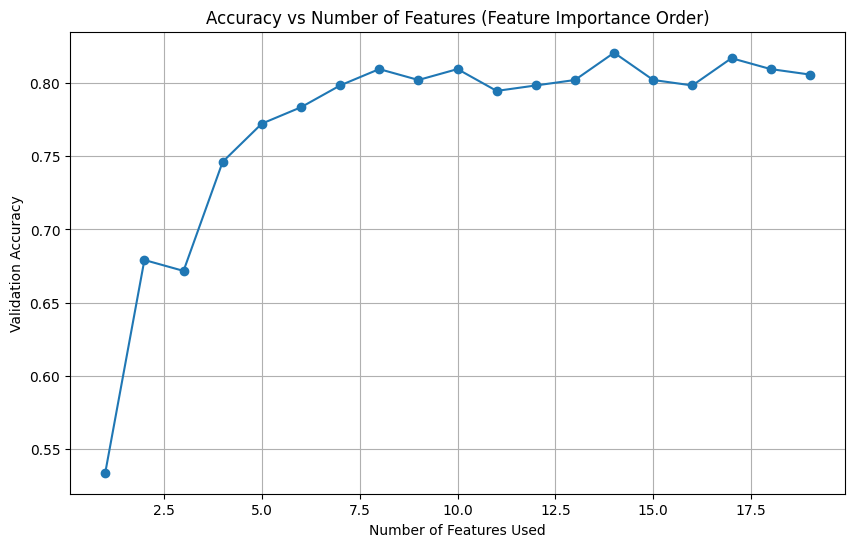

In [ ]:
# Define features and target variable / 特徴量とターゲット変数を定義
X = df_fe5[final_features]
y = y_fe5

# Train a Random Forest to get initial feature importances
# 初期の特徴量重要度を得るためにランダムフォレストを学習
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Sort features by their importance (from highest to lowest) / 特徴量を重要度の高い順にソート
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
sorted_features = feat_importances.sort_values(ascending=False).index.tolist()

# Fix the train/validation split to ensure consistency / 一貫性のある比較のために学習データと検証データの分割を固定
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

# Prepare to record accuracy as we increase the number of features / 特徴量数を増やしながら精度を記録するリストを準備
num_features_list = []
accuracy_list = []

# Loop through 1 to all features and evaluate model accuracy
# 1個から全ての特徴量まで段階的にモデルを学習し、精度を評価
for i in range(1, len(sorted_features) + 1):
    selected_feats = sorted_features[:i]  # Use top i features / 上位i個の特徴量を使用
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train[selected_feats], y_train)  # Train model / モデルを学習
    y_pred = model.predict(X_valid[selected_feats])  # Predict on validation set / 検証データで予測
    acc = accuracy_score(y_valid, y_pred)  # Calculate accuracy / 精度を算出
    num_features_list.append(i)  # Number of features used / 使用した特徴量の数
    accuracy_list.append(acc)    # Accuracy result / 精度の結果

# Plot the accuracy as a function of number of features used / 使用する特徴量数ごとの精度をプロット
plt.figure(figsize=(10, 6))
plt.plot(num_features_list, accuracy_list, marker='o')  # Line plot with markers / マーカー付き折れ線グラフ
plt.xlabel("Number of Features Used")  # X軸ラベル：使用した特徴量の数
plt.ylabel("Validation Accuracy")     # Y軸ラベル：検証精度
plt.title("Accuracy vs Number of Features (Feature Importance Order)")  # タイトル：特徴量数と精度の関係
plt.grid(True)
plt.show()

## 4.32 Best Accuracy and Number of Features Used / 最高精度と使用した特徴量の数  
In this section, we identify the number of features and the corresponding accuracy that achieved the highest performance as we gradually increased the number of features. This is an important step in finding the optimal number of features, which helps in understanding which feature set maximizes the model's performance.  

このセクションでは、特徴量数を増やしていく過程で得られた精度結果から、最高精度を達成した特徴量の数とその精度を特定しています。これは、最適な特徴量数を見つけるための重要なステップであり、どの特徴量数がモデルのパフォーマンスを最大化するかを理解するために役立ちます。

In [ ]:
# Find the highest accuracy from the recorded accuracies
# 記録した精度リストから最も高い精度を見つける
best_acc = max(accuracy_list)

# Find the number of features corresponding to the highest accuracy
# 最高精度が出たときの特徴量の数を取得する
best_num_feats = num_features_list[accuracy_list.index(best_acc)]

# Print the best accuracy and the number of features used
# ベストな精度とその時の特徴量の数を表示する
print(f"✅ Best Accuracy: {best_acc:.4f} at {best_num_feats} features")

✅ Best Accuracy: 0.8209 at 14 features


### Best Accuracy and Number of Features Used / 最高精度と使用した特徴量の数

### Discussion / 考察

In this section, we identified the optimal number of features for the model based on the highest validation accuracy achieved. The best accuracy of **0.8209** was obtained when **14 features** were used. This suggests that **14 features** strike the best balance between model complexity and predictive performance.

- **Key Insights:**
  - The model's accuracy increased as more features were added, but after a certain point, the addition of new features did not lead to a significant improvement.
  - Using **14 features** appears to provide the best predictive performance, indicating that these features contain the most relevant information for predicting the target variable.
  - This finding suggests that using more than **14 features** could lead to overfitting or unnecessarily increased complexity without adding meaningful improvements to model performance.  

The optimal number of features, based on the highest achieved accuracy, is **14**. By selecting these top features, we can achieve a more efficient and effective model without unnecessarily increasing the computational cost or risk of overfitting.  

---

このセクションでは、特徴量数を増やしていく過程で得られた精度結果から、最高精度を達成した特徴量の数とその精度を特定しました。最適な精度 **0.8209** は **14個の特徴量** で得られました。これは、**14個の特徴量** がモデルの複雑さと予測精度のバランスを最適化することを示しています。

- **重要なインサイト:**
  - 特徴量を追加することでモデルの精度は向上しましたが、一定の特徴量数を超えると、精度向上はほとんど見られませんでした。
  - **14個の特徴量** は予測精度を最も高めるため、これらの特徴量がターゲット変数を予測するために最も関連性のある情報を含んでいると考えられます。
  - この結果は、**14個以上の特徴量** を使用すると、過学習や不必要に複雑化する可能性があり、モデル性能の改善にはつながらないことを示唆しています。

### 結論
最適な特徴量数は、最高精度を達成した **14個の特徴量** です。この特徴量を選定することで、計算コストや過学習のリスクを抑えながら、効率的で効果的なモデルを構築することができます。


### 4.33 Train and evaluate a Random Forest model using the top 14 features by importance / 特徴量重要度上位14個を用いたランダムフォレストモデルの学習と評価  
We trained a model using the top 14 features based on feature importance, and compared it with a model using the top 80% of cumulative importance to examine how different selection strategies affect predictive performance.  

特徴量重要度の上位14個を用いたモデルを構築し、累積重要度ベースで選んだ上位80%の特徴量によるモデルと比較することで、選択方法の違いが予測性能に与える影響を検証しました。。


In [ ]:
# Use the top 14 features selected based on feature importance for training the model.
# 特徴量重要度で選ばれた上位14個の特徴量を使ってモデルを学習。
top14_features = sorted_features[:14]
print(top14_features)

# =====================================================
# 1. Define features and target variable / 上位14個の特徴量だけを特徴量に含める
# =====================================================
X_top14 = df_fe5[top14_features]
y_top14 = df_fe5['Survived']

# =====================================================
# 2. Define StratifiedKFold CV / StratifiedKFoldの定義（shuffleあり）
# =====================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# =====================================================
# 3. Hyperparameter grid / ハイパーパラメータの候補設定
# =====================================================
param_grid_rf_top14 = {
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}

# =====================================================
# 4. Grid Search with cross-validation / クロスバリデーション付きグリッドサーチ
# =====================================================
grid_search_rf_top14 = GridSearchCV(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    param_grid=param_grid_rf_top14,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# =====================================================
# 5. Fit on all data / 全データで学習（グリッドサーチで最適パラメータ探索）
# =====================================================
grid_search_rf_top14.fit(X_top14, y_top14)

# =====================================================
# 6. Get best estimator and parameters / 最良モデルとパラメータ取得
# =====================================================
best_model_rf_top14 = grid_search_rf_top14.best_estimator_
best_params_rf_top14 = grid_search_rf_top14.best_params_

# =====================================================
# 7. Evaluation function definition / クロスバリデーション評価関数定義
# =====================================================
def evaluate_model_cv(model, X, y, cv):
    accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()
    roc_auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc').mean()
    return {'accuracy': accuracy, 'roc_auc': roc_auc}

# =====================================================
# 8. Evaluate model with cross-validation / クロスバリデーションによる性能評価
# =====================================================
scores_rf_top14 = evaluate_model_cv(best_model_rf_top14, X_top14, y_top14, cv)

# =====================================================
# 9. Classification report with cross-validated predictions / CV予測を使った分類レポート
# =====================================================
y_pred_cv_rf_top14 = cross_val_predict(best_model_rf_top14, X_top14, y_top14, cv=cv)
class_report_rf_top14 = classification_report(y_top14, y_pred_cv_rf_top14)

# =====================================================
# 10. Output results / 結果の出力
# =====================================================
print("📌 Best Parameters (RF selected features):", best_params_rf_top14)
print("📈 Mean CV Accuracy:", scores_rf_top14['accuracy'])
print("📈 Mean CV ROC AUC:", scores_rf_top14['roc_auc'])
print("📝 Classification Report (CV predictions):\n", class_report_rf_top14)

# =============================================
# 11. Create dictionary of model results
#    モデルの結果を辞書形式で定義
# =============================================

results = {
    "Model": [
        "Top 80% Features",              # 上位80%の特徴量のみ使用したモデル
        "Top14　 Features"                     # 上位14の特徴量を使用したモデル
    ],
    "Best Parameters": [
        best_params_rf_sel,                    # 上位80%モデルの最適パラメータ
        best_params_rf_top14                    # Interaction特徴追加モデルの最適パラメータ
    ],
    "Mean CV Accuracy": [
        scores_rf_sel['accuracy'],             # 上位80%モデルのCV平均Accuracy
        scores_rf_top14['accuracy']             # Interaction追加モデルのCV平均Accuracy
    ],
    "Mean CV ROC AUC": [
        scores_rf_sel['roc_auc'],              # 上位80%モデルのCV平均ROC AUC
        scores_rf_top14['roc_auc']              # Interaction追加モデルのCV平均ROC AUC
    ]
}

# =============================================
# 12. Convert dictionary to DataFrame
#    結果をDataFrame形式に変換
# =============================================
comparison_df = pd.DataFrame(results)

# =============================================
# 13. Display comparison table
#    比較表を表示
# =============================================

print("🔍 Model Comparison Table / モデル比較表：\n")
print(comparison_df)

['Age', 'Fare', 'Fare_log', 'Title_Mr', 'Sex', 'TicketGroupSize', 'Family', 'Pclass_3', 'Title_Miss', 'Title_Mrs', 'Has_Cabin', 'S', 'female_3_flag', 'Pclass_1']
Fitting 5 folds for each of 9 candidates, totalling 45 fits
📌 Best Parameters (RF selected features): {'max_depth': 7, 'min_samples_leaf': 2}
📈 Mean CV Accuracy: 0.8439897056054233
📈 Mean CV ROC AUC: 0.8757557484320196
📝 Classification Report (CV predictions):
               precision    recall  f1-score   support

         0.0       0.85      0.91      0.88       549
         1.0       0.83      0.74      0.79       342

    accuracy                           0.84       891
   macro avg       0.84      0.82      0.83       891
weighted avg       0.84      0.84      0.84       891

🔍 Model Comparison Table / モデル比較表：

              Model                          Best Parameters  \
0  Top 80% Features  {'max_depth': 7, 'min_samples_leaf': 4}   
1   Top14　 Features  {'max_depth': 7, 'min_samples_leaf': 2}   

   Mean CV Accuracy 

###🔍 Model Comparison and Evaluation / モデル比較と評価
Feature Set: Top 80% Features vs Top 14 Features  
特徴量セット：上位80%特徴量 vs 上位14特徴量  

| Model / モデル      | Mean CV Accuracy | Mean CV ROC AUC | Best Parameters / 最適パラメータ         |
| ---------------- | ---------------- | --------------- | --------------------------------- |
| Top 80% Features | **0.8473**       | **0.8760**      | `max_depth=7, min_samples_leaf=4` |
| Top 14 Features  | 0.8440           | 0.8758          | `max_depth=7, min_samples_leaf=2` |

- The Top 80% Features model slightly outperformed the Top 14 model in both accuracy and ROC AUC.

- The classification report also showed a marginally higher recall for the Top 80% model.

- 上位80%特徴量モデルは、精度とROC AUCの両方で上位14特徴量モデルをわずかに上回りました。

- 分類レポートでは、生存者クラスの recall（再現率）も上位80%モデルの方がやや高い傾向が見られました。  

###💡 Considerations / 考察

- The **Top14 model** uses 14 features selected by descending feature importance, which is more than the **Top 80% model (11 features)**.
- However, based on cross-validation, the **Top14 model performed slightly worse** in both accuracy (0.844 vs 0.847) and ROC-AUC.
- This suggests that **the additional lower-importance features (12–14) may have introduced noise**, slightly reducing generalization performance.
- In contrast, the **Top 80% model achieved higher accuracy with fewer features**, indicating a more efficient use of relevant information and better regularization.
- The fact that `min_samples_leaf=4` was optimal for the Top 80% model further supports the idea that **stronger regularization helped prevent overfitting with fewer features**.

✅ In conclusion, while the Top14 model is still solid, the **Top 80% model offers better performance with fewer features**, making it a more practical and robust choice.


- **Top14モデル**は、特徴量重要度の高い順に14個使用したモデルであり、**上位80%モデル（11個）よりも多くの特徴量を使っています**。
- しかし、交差検証の結果、**Top14モデルは若干精度が劣り（Accuracy: 0.844 vs 0.847）**、**ROC-AUCもわずかに低くなりました**。
- これは、**追加された下位の特徴量（12〜14位）がノイズになってしまい、モデルの汎化性能をわずかに損なった可能性**を示しています。
- 一方、**上位80%モデルは少ない特徴量でより高い精度**を達成しており、**必要な情報を効率よく捉えつつ過学習を防いでいる**と考えられます。
- また、最適なハイパーパラメータとして `min_samples_leaf=4` が選ばれたことも、**特徴量が少ない分、より強めの正則化が効果的だった**可能性を示唆しています。

✅ 結論として、**Top14は性能が悪いわけではないが、Top 80%モデルの方が少ない特徴量でより高精度かつ安定した結果**を出しており、より実用的であると評価できます。



## 4.34 Feature Selection and Model Accuracy Evaluation / 特徴量選択とモデル精度の評価  
1. 📌 Initial Feature Selection (Cumulative Importance)  
We initially selected features based on cumulative contribution using SHAP values and feature importance scores from a Random Forest model. We set the threshold at 80% of cumulative importance, which resulted in the best validation accuracy of 84.73%.

2. 🧪 Testing Handcrafted Features  
We then introduced handcrafted features inspired by domain knowledge and misclassification analysis—such as male_1_flag, female_3_flag, and mr_family_4_flag.
However, when we added all these features to the base model, validation accuracy slightly decreased.

3. 🧮 Evaluating Top 14 Features by Importance  
We also tested a model using the top 14 features ranked by Random Forest's feature importance. The validation accuracy was 84.4%, close to the best but still slightly below the cumulative importance model.

4. ✅ Conclusion and Final Feature Set  
Based on both predictive performance and model simplicity, we selected the feature set derived from the top 80% cumulative importance as our final choice.
This approach avoids unnecessary complexity and potential overfitting introduced by less effective handcrafted features.

---
1. 📌 初期選択（累積重要度ベース）  
まず、SHAP値やランダムフォレストによる特徴量重要度に基づき、累積重要度が80％に達するまでの特徴量を選択しました。この特徴量セットが、84.73％の最高検証精度を記録しました。

2. 🧪 手作り特徴量の追加と検証  
次に、ドメイン知識や誤分類パターンに着想を得て作成した手作り特徴量（例：male_1_flag, female_3_flag, mr_family_4_flag）を追加しました。
しかし、これらをすべて加えた場合、モデルの検証精度はわずかに低下しました。

3. 🧮 特徴量重要度上位14個によるモデルの評価  
さらに、ランダムフォレストの特徴量重要度で上位14個を選んだモデルも評価しました。こちらの精度は84.4％と、かなり高かったものの、累積重要度ベースのモデルにはわずかに届きませんでした。

4. ✅ 結論と最終的な特徴量選択  
予測精度とモデルのシンプルさのバランスを考慮し、累積重要度80％に基づく特徴量セットを最終モデルとして採用しました。
この選択により、効果の不確かな特徴量を排除し、過学習や複雑化を回避できます。

# 🤖 5. Model Comparison / モデル比較
In this section, we compared several machine learning models using the final feature set (based on the top 80% cumulative importance).
We tried each model one by one with hyperparameter tuning, and evaluated their performance using accuracy, AUC, and classification report on the validation set.

このセクションでは、最終的な特徴量セット（累積重要度上位80％）を用いて、複数のモデルを段階的に比較しました。
それぞれのモデルでハイパーパラメータ調整を行い、精度（Accuracy）、AUCスコア、および分類レポート（Classification Report）を用いて検証データでの性能を評価しました。

##🧪 5.1 Models Tried / 試したモデル一覧
✅ Random Forest (RF)
→ This model was already tested during feature engineering.  / 特徴量エンジニアリングの過程で既に使用・検証済み

1.🔶 XGBoost  
 A powerful gradient boosting algorithm known for its performance in structured data.
構造化データに強く、コンペティションでも定番のブースティングモデル。

2.🔷 LightGBM  
A lightweight and fast gradient boosting framework developed by Microsoft.
高速で軽量な勾配ブースティングフレームワーク。XGBoostより高速なことも。

3.🔸 Support Vector Machine (SVM)  
Effective in high-dimensional spaces. Requires careful feature scaling.
高次元空間に強いが、特徴量のスケーリングが重要。

4.🔺 Voting Classifier (Hard Voting)  
An ensemble method combining multiple base models using majority rule.
複数の基本モデルを組み合わせて多数決で予測を決定するアンサンブル手法。

5.🔰 Stacking Classifier (with RF, XGB, LightGBM, SVM.)  
A meta-model that learns to combine the predictions of several base models (RF, XGB, LightGBM, SVM).
複数のモデル（RF, XGB, LightGBM, SVM）の出力をメタモデルで統合する高度なアンサンブル手法。

### ⚙️ **5.2 Evaluation Metrics / 評価指標**

To evaluate and compare the performance of each machine learning model, we used the following metrics calculated through **cross-validation (CV)**:

- **CV Accuracy**: The average proportion of correct predictions across all folds. This gives an estimate of the model’s generalization performance.
- **CV ROC AUC (Receiver Operating Characteristic - Area Under the Curve)**: Measures the model’s ability to distinguish between the two classes (Survived / Not Survived) across CV folds. This is especially important when the class distribution is imbalanced.
- **Classification Report (based on CV predictions)**: Reports class-specific metrics such as precision, recall, and F1-score. This helps evaluate how well the model performs on each class (0 = Not Survived, 1 = Survived), beyond overall accuracy.

これらのモデルの性能を評価・比較するため、以下の指標を**交差検証（CV）**に基づいて使用しました：

- **CV Accuracy（交差検証の正解率）**：各分割での正解率の平均を算出し、モデルの汎化性能を評価しました。
- **CV ROC AUC（交差検証におけるROC曲線下面積）**：生存者・非生存者の識別性能を評価する指標であり、クラス不均衡がある場面でも有効です。
- **分類レポート（CV予測に基づく）**：各クラス（0 = 非生存、1 = 生存）ごとに、**適合率（Precision）**、**再現率（Recall）**、**F1スコア**を出力し、単なる精度では見えにくいモデルの偏りやクラスごとの性能を詳細に分析しました。


## 5.3 Model Training and Evaluation / モデル学習と評価  
### 5.3.1 XGBoost (Before Hyperparameter Tuning) / ハイパーパラメータ調整前のXGBoost

We started by training an XGBoost classifier using its default hyperparameters, except for two settings:
- `use_label_encoder=False` (to suppress the deprecation warning)
- `eval_metric='logloss'` (for binary classification)

初期段階では、XGBoostのデフォルト設定を使用しつつ、以下の2点のみ明示的に指定しました：
- `use_label_encoder=False`（非推奨警告を回避するため）  
- `eval_metric='logloss'`（2値分類のための評価指標）  


In [ ]:
# =====================================================
# 1. Define features and target variable / 特徴量とターゲット変数を定義
# =====================================================
X_selected = df_fe4[selected_features]  # Use top 80% important features / 上位80%重要度の特徴量を使用
y_selected = df_fe4['Survived']         # Target variable: Survived / 目的変数：生存者

# =====================================================
# 2. Define Stratified K-Fold CV / StratifiedKFoldクロスバリデーションを定義（層化抽出）
# =====================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# =====================================================
# 3. Initialize XGBoost classifier (Before Hyperparameter Tuning) / ハイパーパラメータ調整前のXGBoost初期化
# =====================================================
model_xgb = XGBClassifier(
    use_label_encoder=False,  # Suppress deprecation warning / 非推奨警告を抑制
    eval_metric='logloss',    # Use logloss for binary classification / 2値分類の損失関数としてloglossを指定
    random_state=42           # Ensure reproducibility / 結果の再現性を確保するため乱数シードを設定
)

# =====================================================
# 4. Evaluate model with cross-validation / 交差検証でモデル評価（AccuracyとROC AUC）
# =====================================================
accuracy = cross_val_score(model_xgb, X_selected, y_selected, cv=cv, scoring='accuracy').mean()
roc_auc = cross_val_score(model_xgb, X_selected, y_selected, cv=cv, scoring='roc_auc').mean()

print(f"📌 Default XGBoost Evaluation")
print(f"📈 Mean CV Accuracy: {accuracy:.4f}")  # 平均正解率を表示
print(f"📈 Mean CV ROC AUC: {roc_auc:.4f}")    # 平均ROC AUCを表示

# =====================================================
# 5. Get cross-validated predictions and classification report / 交差検証予測値を取得し分類レポートを表示
# =====================================================
y_pred = cross_val_predict(model_xgb, X_selected, y_selected, cv=cv)
print("📝 Classification Report:\n", classification_report(y_selected, y_pred))

📌 Default XGBoost Evaluation
📈 Mean CV Accuracy: 0.8260
📈 Mean CV ROC AUC: 0.8741
📝 Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86       549
           1       0.78      0.76      0.77       342

    accuracy                           0.83       891
   macro avg       0.82      0.81      0.81       891
weighted avg       0.83      0.83      0.83       891



### Analysis of Default XGBoost Performance / デフォルトXGBoostの性能に関する考察

The default XGBoost classifier achieves a strong performance on this dataset, with a mean cross-validated accuracy of 82.6% and a ROC AUC score of 0.8741. These results indicate that the model is effective at distinguishing between the classes.

Looking at the classification report:
- Precision and recall are balanced fairly well between the classes, with class 0 (majority class) showing slightly higher precision and recall (0.85 and 0.87) compared to class 1 (minority class) with precision 0.78 and recall 0.76.
- The F1-scores, which balance precision and recall, also reflect this trend (0.86 for class 0 and 0.77 for class 1).
- Overall, the model shows robust predictive performance, but there is still room for improvement, especially for the minority class (class 1), which tends to have lower recall.

These results provide a solid baseline before hyperparameter tuning and further optimization.

---

このデフォルトのXGBoost分類器は、交差検証で平均正解率82.6%、ROC AUCスコア0.8741と良好な性能を示しています。モデルはクラスの識別に効果的であることがわかります。

分類レポートを見ると：
- クラス0（多数派クラス）は精度（0.85）と再現率（0.87）がやや高いのに対し、クラス1（少数派クラス）は精度0.78、再現率0.76となっています。
- 精度と再現率のバランスを示すF1スコアも同様に、クラス0は0.86、クラス1は0.77です。
- 全体的に堅牢な予測性能を持っていますが、特に少数派クラスに対する再現率向上の余地があります。

これらの結果は、ハイパーパラメータ調整やさらなる最適化を行う前の良いベースラインとなります。


### 📈 5.3.2 XGBoost (After Hyperparameter Tuning) / ハイパーパラメータ調整後のXGBoost

We improved the XGBoost model by performing grid search over several hyperparameters, including tree depth, learning rate, regularization terms, and `scale_pos_weight` to handle class imbalance.

XGBoostモデルの性能を向上させるために、木の深さ・学習率・正則化項・`scale_pos_weight`（クラス不均衡対応）などのハイパーパラメータについてグリッドサーチを行いました。

In [ ]:
# =====================================================
# 1. Define features and target variable / 特徴量とターゲット変数を定義
# =====================================================
X_selected = df_fe4[selected_features]  # Use top 80% important features / 上位80%重要度の特徴量を使用
y_selected = df_fe4['Survived']         # Target variable: Survived / 目的変数：生存者

# =====================================================
# 2. Define Stratified K-Fold CV / StratifiedKFoldの定義（層化抽出）
# =====================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# =====================================================
# 3. Initialize XGBoost classifier / XGBoost分類器を初期化
# =====================================================
model_xgb = XGBClassifier(
    use_label_encoder=False,  # Suppress warning / 非推奨警告を抑制
    eval_metric='logloss',    # Binary classification metric / 2値分類の損失関数
    random_state=42           # Seed for reproducibility / 再現性確保のため乱数シード設定
)

# =====================================================
# 4. Define hyperparameter grid including scale_pos_weight / ハイパーパラメータグリッドを定義
# =====================================================
param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7],
    'colsample_bytree': [0.7],
    'gamma': [0, 1],
    'scale_pos_weight': [1, 2]
}

# =====================================================
# 5. Perform Grid Search with cross-validation / グリッドサーチで最適化（交差検証）
# =====================================================
xgb_gs_fe4 = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid,
    scoring='roc_auc',       # Optimize ROC AUC / ROC AUCで最適化
    cv=cv,
    n_jobs=-1,               # Use all processors / 並列処理
    verbose=1
)

# =====================================================
# 6. Fit the model with GridSearchCV / 全データでグリッドサーチ実行
# =====================================================
xgb_gs_fe4.fit(X_selected , y_selected )  # Train with hyperparameter tuning / 学習＋チューニング実行

# =====================================================
# 7. Get best estimator and parameters / 最良モデルとパラメータを取得
# =====================================================
best_model_xgb = xgb_gs_fe4.best_estimator_  # Best model after grid search / グリッドサーチ後の最良モデル
best_params_xgb = xgb_gs_fe4.best_params_    # Best hyperparameters / 最良ハイパーパラメータ
xgb_best_cv_acc = xgb_gs_fe4.best_score_     # Best cross-validation accuracy / 最良交差検証精度

# =====================================================
# 8. Evaluation function (shared with XGBoost) / 評価関数（XGBoostと共通化）
# =====================================================
def evaluate_model_cv(model, X, y, cv):
    """
    Evaluate model performance using cross-validation.
    モデルの性能を交差検証で評価する関数
    """
    accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()  # Accuracy score / 精度スコア
    roc_auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc').mean()    # ROC AUC score / ROC AUCスコア
    return {'accuracy': accuracy, 'roc_auc': roc_auc}  # Return mean scores / 平均スコアを返す

# =====================================================
# 9. Evaluate best LGBM model with CV / クロスバリデーションによる性能評価
# =====================================================
scores_xgb = evaluate_model_cv(best_model_xgb, X_selected, y_selected, cv)  # Evaluate the best LightGBM model / 最良LightGBMモデルの評価

# =====================================================
# 10. Classification report with cross-validated predictions / CV予測による分類レポート
# =====================================================
y_pred_cv_xgb = cross_val_predict(best_model_xgb, X_selected, y_selected, cv=cv)  # CV予測（予測値を取得）
class_report_xgb = classification_report(y_selected, y_pred_cv_xgb)  # Classification report / 分類レポートの作成

# =====================================================
# 11. Output results / 結果の出力
# =====================================================
print("📌 Best Parameters (LGBM):", best_params_xgb)  # Best parameters output / 最良パラメータの表示
print("📈 Mean CV Accuracy:", scores_xgb['accuracy'])  # Mean CV accuracy output / 平均CV精度の表示
print("📈 Mean CV ROC AUC:", scores_xgb['roc_auc'])  # Mean CV ROC AUC output / 平均CV ROC AUCの表示
print("📝 Classification Report (CV predictions):\n", class_report_xgb)  # Classification report output / 分類レポートの表示

Fitting 5 folds for each of 16 candidates, totalling 80 fits
📌 Best Parameters (LGBM): {'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 0.7}
📈 Mean CV Accuracy: 0.8394827694432239
📈 Mean CV ROC AUC: 0.8868331328252375
📝 Classification Report (CV predictions):
               precision    recall  f1-score   support

           0       0.86      0.89      0.87       549
           1       0.81      0.76      0.78       342

    accuracy                           0.84       891
   macro avg       0.83      0.83      0.83       891
weighted avg       0.84      0.84      0.84       891



### 📊 Model Performance Comparison / モデルの性能比較（XGBoost）

| Evaluation Metric / 評価指標            | ① Default XGBoost / デフォルト設定 | ② Tuned XGBoost / チューニング後 |
| ----------------------------------- | --------------------------- | ------------------------- |
| 📈 Mean CV Accuracy / 平均正解率         | 0.8260                      | **0.8395**                |
| 📈 Mean CV ROC AUC / 平均ROC AUC      | 0.8741                      | **0.8868**                |
| 🧮 Precision (Class 1) / 適合率（クラス1）  | 0.78                        | **0.81**                     |
| 🧮 Recall (Class 1) / 再現率（クラス1）     | 0.76                        | 0.76                      |
| 🧮 F1-score (Class 1) / F1スコア（クラス1） | 0.77                        | **0.78**    


### 📌 XGBoost Performance Comparison / XGBoostの性能比較

**English:**After tuning the XGBoost hyperparameters using Grid Search with a reduced parameter grid (16 combinations), we observed improvements in both the mean cross-validation accuracy (from 0.8260 to 0.8395) and the ROC AUC (from 0.8741 to 0.8868). The F1-score for the minority class (class 1) also slightly improved, indicating better overall balance in classification performance. The gain in precision for class 1 (from 0.78 to 0.81) suggests reduced false positives.


XGBoostのハイパーパラメータを（組み合わせ数を絞って）グリッドサーチで調整した結果、平均正解率は0.8260から0.8395に、ROC AUCは0.8741から0.8868に向上しました。特に、クラス1（生存者）のF1スコアと適合率がわずかに改善しており、モデルがよりバランスよくクラス分類できていることを示しています。誤分類（False Positive）の減少も期待されます。

### 5.3.3 LightGBM (Before Hyperparameter Tuning) / ハイパーパラメータ調整前のLightGBM  
Before tuning, we trained a basic LightGBM model with fixed parameters to establish a performance baseline.  
Although these are not the full defaults (e.g., `max_depth=3`, `learning_rate=0.2`), no tuning was performed and the setup was consistent with our initial XGBoost test.

チューニング前のベースラインとして、LightGBMモデルをシンプルなパラメータ構成で学習しました。  
ここでは `max_depth=3` や `learning_rate=0.2` など一部の設定はしていますが、チューニングは行っていません。XGBoostの初期設定と同様の条件で評価することが目的です。

In [ ]:
# =====================================================
# 1. Define features and target variable / 特徴量と目的変数を定義
# =====================================================
X_selected = df_fe4[selected_features]  # Use selected features / 選択された特徴量を使用
y_selected = df_fe4['Survived']         # Target variable / 目的変数

# =====================================================
# 2. Define Stratified K-Fold CV / StratifiedKFoldの定義（層化抽出）
# =====================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# =====================================================
# 3. Initialize LightGBM classifier with basic parameters / LightGBM分類器を初期化（基本的なパラメータ設定)
# =====================================================
model_lgb = lgb.LGBMClassifier(
    max_depth=3,               # Tree max depth / 木の最大深さ
    learning_rate=0.2,         # Learning rate / 学習率
    n_estimators=100,          # Number of trees / 木の数
    random_state=42            # 再現性を確保
)

# =====================================================
# 4. Evaluate model with cross-validation (Accuracy and ROC AUC) / 交差検証でモデル評価（正解率とROC AUC）
# =====================================================
accuracy = cross_val_score(model_lgb, X_selected, y_selected, cv=cv, scoring='accuracy').mean()
roc_auc = cross_val_score(model_lgb, X_selected, y_selected, cv=cv, scoring='roc_auc').mean()

print(f"Mean CV Accuracy: {accuracy:.4f}")  # 平均正解率を表示
print(f"Mean CV ROC AUC: {roc_auc:.4f}")    # 平均ROC AUCを表示

# =====================================================
# 5. Get cross-validated predictions and classification report / 交差検証予測値を取得し、分類レポートを表示
# =====================================================
y_pred = cross_val_predict(model_lgb, X_selected, y_selected, cv=cv)
print("Classification Report:\n", classification_report(y_selected, y_pred))

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 323
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

### 📝 Observations / 考察  
Even without hyperparameter tuning, the model achieved solid performance with ~80.6% accuracy.

Class 1 (survived) had slightly lower recall, a common issue in imbalanced datasets.

ハイパーパラメータを調整していない段階でも、80%を超える精度を達成。

生存者クラス（1）の再現率はやや低いが、今後のチューニングで改善の余地あり。

### 5.3.4 LightGBM (After Hyperparameter Tuning) / ハイパーパラメータ調整後のLightGBM  
To improve LightGBM’s performance, we conducted a grid search over multiple hyperparameters including tree depth, learning rate, and sampling strategies. Additionally, `scale_pos_weight` was tuned to mitigate class imbalance.

LightGBMの性能を最大化するため、木の深さ、学習率、サンプリングの戦略など、複数のハイパーパラメータについてグリッドサーチを行いました。また、クラスの不均衡に対応するため `scale_pos_weight` も調整対象としました。

In [ ]:
# =====================================================
# 1. Define features and target variable / 特徴量とターゲット変数を定義
# =====================================================
X_selected = df_fe4[selected_features]  # Use top 80% important features / 上位80%重要度の特徴量を使用
y_selected = df_fe4['Survived']         # Target variable: Survived / 目的変数：生存者

# =====================================================
# 2. Define StratifiedKFold CV / StratifiedKFoldの定義（シャッフルあり）
# =====================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# 5分割交差検証（シャッフルあり）：データを5つに分け、各部分で訓練と検証を行います。
# シャッフルにより、データがランダムに分割され、モデル評価のバイアスを減少させます。

# =====================================================
# 3. Define hyperparameter grid for LightGBM / LightGBMのハイパーパラメータ設定
# =====================================================
lgb_param_grid = {
    'max_depth': [3, 5, 7],               # Depth of the trees / 木の深さ
    'learning_rate': [0.05, 0.1, 0.2],    # Learning rate / 学習率
    'n_estimators': [50, 100, 200],       # Number of trees / 木の数
    'subsample': [0.8, 1.0],               # Fraction of samples used per tree / 各木の学習に使用するサンプルの割合
    'colsample_bytree': [0.8, 1.0],        # Fraction of features used per tree / 各木で使用する特徴量の割合
    'scale_pos_weight': [1, 5, 10]         # Weight for positive class (class imbalance adjustment) / 正のクラスの重み（不均衡調整）
}

# =====================================================
# 4. Initialize LightGBM model / モデルの初期化
# =====================================================
lgb_model_fe4 = LGBMClassifier(random_state=42)  # LightGBMのモデル初期化（再現性のためrandom_stateを設定）

# =====================================================
# 5. Grid Search with CV / グリッドサーチ（交差検証付き）
# =====================================================

lgb_gs_fe4 = GridSearchCV(
    estimator=lgb_model_fe4,              # Estimator / モデル
    param_grid=lgb_param_grid,             # Hyperparameter grid / ハイパーパラメータの探索範囲
    cv=cv,                                 # Cross-validation strategy / クロスバリデーション戦略
    scoring='accuracy',                    # Evaluation metric: Accuracy / 評価指標：精度
    n_jobs=-1,                             # Use all available CPUs / 利用可能なCPUをすべて使用
    verbose=1,                             # Show progress of grid search / グリッドサーチの進捗を表示
    error_score='raise'                    # Raise error if any occurs / エラーが発生した場合はエラーを表示
)

# =====================================================
# 6. Fit the model with GridSearchCV / 全データでグリッドサーチ実行
# =====================================================
lgb_gs_fe4.fit(X_selected, y_selected)  # Fit the model using grid search / グリッドサーチを用いてモデルを学習

# =====================================================
# 7. Get best estimator and parameters / 最良モデルとパラメータを取得
# =====================================================
best_model_lgb = lgb_gs_fe4.best_estimator_  # Best model after grid search / グリッドサーチ後の最良モデル
best_params_lgb = lgb_gs_fe4.best_params_    # Best hyperparameters / 最良ハイパーパラメータ
lgb_best_cv_acc = lgb_gs_fe4.best_score_     # Best cross-validation accuracy / 最良交差検証精度

# =====================================================
# 8. Evaluation function (shared with XGBoost) / 評価関数（XGBoostと共通化）
# =====================================================
def evaluate_model_cv(model, X, y, cv):
    """
    Evaluate model performance using cross-validation.
    モデルの性能を交差検証で評価する関数
    """
    accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()  # Accuracy score / 精度スコア
    roc_auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc').mean()    # ROC AUC score / ROC AUCスコア
    return {'accuracy': accuracy, 'roc_auc': roc_auc}  # Return mean scores / 平均スコアを返す

# =====================================================
# 9. Evaluate best LGBM model with CV / クロスバリデーションによる性能評価
# =====================================================
scores_lgb = evaluate_model_cv(best_model_lgb, X_selected, y_selected, cv)  # Evaluate the best LightGBM model / 最良LightGBMモデルの評価

# =====================================================
# 10. Classification report with cross-validated predictions / CV予測による分類レポート
# =====================================================
y_pred_cv_lgb = cross_val_predict(best_model_lgb, X_selected, y_selected, cv=cv)  # CV予測（予測値を取得）
class_report_lgb = classification_report(y_selected, y_pred_cv_lgb)  # Classification report / 分類レポートの作成

# =====================================================
# 11. Output results / 結果の出力
# =====================================================
print("📌 Best Parameters (LGBM):", best_params_lgb)  # Best parameters output / 最良パラメータの表示
print("📈 Mean CV Accuracy:", scores_lgb['accuracy'])  # Mean CV accuracy output / 平均CV精度の表示
print("📈 Mean CV ROC AUC:", scores_lgb['roc_auc'])  # Mean CV ROC AUC output / 平均CV ROC AUCの表示
print("📝 Classification Report (CV predictions):\n", class_report_lgb)  # Classification report output / 分類レポートの表示

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 364
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

### 📋 LightGBM Performance Comparison Table / LightGBM性能比較表   

| Evaluation Metric / 評価指標         | Before Tuning / 調整前 | After Tuning / 調整後 |
| -------------------------------- | ------------------- | ------------------ |
| Mean CV Accuracy / 平均精度          | 0.8316              | 0.8384             |
| Mean ROC AUC / 平均ROC AUC         | 0.8798              | 0.8803             |
| Precision (Class 1) / 適合率（クラス1）  | 0.79                | 0.81               |
| Recall (Class 1) / 再現率（クラス1）     | 0.76                | 0.76               |
| F1-score (Class 1) / F1スコア（クラス1） | 0.79                | 0.78               |




### 📊 LightGBM Performance Comparison (Before vs After Hyperparameter Tuning) / LightGBMの性能比較（ハイパーパラメータ調整 前後）  


After hyperparameter tuning, LightGBM showed a slight improvement in performance:

- Mean CV Accuracy improved from 0.8316 to 0.8384

- Mean ROC AUC increased slightly from 0.8798 to 0.8803

- F1-score for class 1 (survivors) remained steady at 0.78, but precision improved (from 0.79 to 0.81)

These results suggest that the tuning helped the model make more confident and accurate predictions for the positive class, especially by slightly reducing false positives.

Overall, the performance gain is modest but meaningful, especially considering class imbalance. The optimized model maintains strong performance for both classes.  

---

ハイパーパラメータ調整後のLightGBMは、わずかに性能が向上しました：

- Mean CV Accuracyは 0.8316 → 0.8384 に改善

- Mean ROC AUCも 0.8798 → 0.8803 に微増

- クラス1（生存者）のF1スコアは 0.78で安定しているものの、precisionは0.79 → 0.81と改善

これらの結果から、モデルが クラス1の予測において、より確信をもって正しく判定できるようになった（偽陽性の減少） と考えられます。

全体として、改善幅は小さいながらも意味のあるものであり、不均衡データにおいても安定した性能を維持していることがわかります。

### 5.3.5 Default SVM Model Evaluation / デフォルトSVMモデルの性能確認

To evaluate the baseline performance of a Support Vector Machine (SVM), we trained a default SVM model using selected features. Because SVMs are sensitive to feature scales, we standardized all numerical variables (Fare_log, Age, Family, TicketGroupSize) using StandardScaler.

SVMの基本性能を確認するために、選択された特徴量を用いてデフォルト設定のSVMモデルを学習しました。  
SVMは特徴量のスケールに敏感であるため、数値特徴量（Fare_log, Age, Family, TicketGroupSize）をStandardScalerで標準化しました。  


In [ ]:
# =====================================================
# 1. Define features and target variable / 特徴量と目的変数を定義
# =====================================================
X_selected = df_fe4[selected_features]  # Use selected features / 選択された特徴量を使用
y_selected = df_fe4['Survived']         # Target variable / 目的変数

# =====================================================
# 2. Define numerical and categorical features / 数値特徴量とカテゴリ特徴量を分類
# =====================================================
numerical_features = ['Fare','Fare_log', 'Age', 'Family', 'TicketGroupSize']  # Numerical features / 数値特徴量
categorical_features = [col for col in X_selected.columns if col not in numerical_features]  # Categorical features / カテゴリ特徴量

# =====================================================
# 3. Create ColumnTransformer to scale only numerical features / 数値特徴量のみを標準化（カテゴリはそのまま通す）
# =====================================================
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),   # Apply StandardScaler to numerical features / 数値特徴量にStandardScalerを適用
        ('cat', 'passthrough', categorical_features)     # Leave categorical features unchanged / カテゴリ特徴量はそのまま
    ]
)

# =====================================================
# 4. Set up Stratified K-Fold Cross-Validation / StratifiedKFoldの設定（クラスの割合を保つ）
# =====================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold CV with shuffling / シャッフルありの5分割交差検証

# =====================================================
# 5. Create pipeline with LinearSVC / LinearSVCを使ったパイプラインの作成
# =====================================================
pipeline_linear_svc = Pipeline([
    ('preprocessor', preprocessor),                         # Preprocessing step / 前処理（標準化＋パススルー）
    ('linear_svc', LinearSVC(random_state=42, max_iter=10000))  # LinearSVC classifier / 線形SVM分類器
])

# =====================================================
# 6. Define evaluation function / モデル評価関数の定義
# =====================================================
def evaluate_model_cv(model, X, y, cv):
    accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()  # Mean accuracy / 平均正解率
    roc_auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc').mean()    # Mean ROC AUC / 平均ROC AUCスコア
    return {'accuracy': accuracy, 'roc_auc': roc_auc}

# =====================================================
# 7. Evaluate LinearSVC with cross-validation / LinearSVCを交差検証で評価
# =====================================================
scores_linear_svc = evaluate_model_cv(pipeline_linear_svc, X_selected, y_selected, cv)

# =====================================================
# 8. Get CV predictions and generate classification report / 交差検証の予測値から分類レポートを生成
# =====================================================
y_pred_cv_linear_svc = cross_val_predict(pipeline_linear_svc, X_selected, y_selected, cv=cv)  # Cross-validated predictions / 交差検証予測値
report_linear_svc = classification_report(y_selected, y_pred_cv_linear_svc)                   # Generate report / 分類レポート作成

# =====================================================
# 9. Output evaluation results / 評価結果を出力
# =====================================================
print("\n==== Default LinearSVC ====")
print("📈 Mean CV Accuracy:", scores_linear_svc['accuracy'])  # Mean accuracy score / 平均正解率
print("📈 Mean CV ROC AUC:", scores_linear_svc['roc_auc'])    # Mean ROC AUC score / 平均ROC AUC
print("📝 Classification Report:\n", report_linear_svc)       # Classification report / 分類レポート


==== Default LinearSVC ====
📈 Mean CV Accuracy: 0.8148138848785388
📈 Mean CV ROC AUC: 0.8656900269263886
📝 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85       549
           1       0.77      0.73      0.75       342

    accuracy                           0.81       891
   macro avg       0.81      0.80      0.80       891
weighted avg       0.81      0.81      0.81       891



## 📌 Default SVM Evaluation (Pipeline) - Consideration / 考察

The default LinearSVC model achieved a mean cross-validated accuracy of approximately 81.5% and a ROC AUC score of about 0.87. These results indicate a strong performance for this baseline model on the Titanic dataset.

Looking at the classification report, the model shows balanced precision and recall for both classes. The precision and recall for the non-survivor class (class 0) are particularly high, suggesting the model is effective at identifying passengers who did not survive. For the survivor class (class 1), precision and recall are slightly lower but still satisfactory, indicating the model reasonably predicts survivors.

Given these results, the default LinearSVC provides a reliable baseline. Future improvements may come from hyperparameter tuning. Overall, this model can serve as a solid foundation for further experiments.

---

デフォルトのLinearSVCモデルは、交差検証で約81.5％の正解率とROC AUCスコア約0.87を達成しました。これらの結果は、Titanicデータセットにおけるベースラインモデルとして十分な性能を示しています。

分類レポートを見ると、非生存者クラス（クラス0）に対しては精度と再現率が高く、このクラスの識別に優れていることがわかります。一方で、生存者クラス（クラス1）については精度・再現率がやや低いものの、妥当な予測ができています。

この結果から、デフォルトのLinearSVCは信頼できるベースラインモデルと言えます。今後はハイパーパラメータの調整を通じて、さらなる性能向上が期待できます。全体として、本モデルは次の実験の良い出発点となります。

## 5.3.6 SVM with Class Weight Adjustment / クラス重み調整付きSVM
To mitigate the effects of class imbalance in the Titanic dataset, we added class_weight='balanced' as one of the parameters during hyperparameter tuning of the SVM model.
This setting instructs the model to automatically assign higher weights to minority classes, such as survivors, which helps improve recall and F1-score for that class.
We compared models with and without class weight adjustment using GridSearchCV and selected the best-performing configuration based on cross-validation accuracy.

タイタニックデータのクラス不均衡（生存者と非生存者の比率の差）に対処するため、SVMのハイパーパラメータチューニング時に class_weight='balanced' を候補として追加しました。
この設定により、少数派クラス（生存者など）に自動で重みが与えられ、再現率やF1スコアの改善が期待できます。
GridSearchCV によって重みの有無を含めた複数の設定を比較し、クロスバリデーションの精度に基づいて最良モデルを選択しました。  


In [ ]:
# =====================================================
# 1. Define features and target variable / 特徴量と目的変数を定義
# =====================================================
X_selected = df_fe4[selected_features]  # Use selected features for training / 選択した特徴量を使用
y_selected = df_fe4['Survived']         # Target variable: survival status / 目的変数：生存の有無

# =====================================================
# 2. Define numerical and categorical features / 数値特徴量とカテゴリ特徴量を分類
# =====================================================
numerical_features = ['Fare','Fare_log', 'Age', 'Family', 'TicketGroupSize'] # 数値特徴量（標準化対象）
categorical_features = [col for col in X_selected.columns if col not in numerical_features]  # その他をカテゴリ扱い

# =====================================================
# 3. ColumnTransformer (only scale numerical features) / 数値特徴量のみスケーリング
# =====================================================
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),     # 数値特徴量にStandardScalerを適用
    ('cat', 'passthrough', categorical_features)       # カテゴリ特徴量はそのまま通す
])

# =====================================================
# 4. Define Stratified K-Fold / StratifiedKFold を定義
# =====================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 層化5分割交差検証（シャッフルあり）

# =====================================================
# 5. Define LinearSVC pipeline / LinearSVC パイプライン（高速モデル）
# =====================================================
pipeline_linsvc = Pipeline([
    ('preprocessor', preprocessor),                             # 前処理（標準化＋カテゴリ通過）
    ('svm', LinearSVC(random_state=42, max_iter=5000))          # LinearSVC モデル
])

# =====================================================
# 6. Define hyperparameter grid / ハイパーパラメータの範囲を定義
# =====================================================
param_grid_linsvc = {
    'svm__C': [0.1, 1, 10],                      # 正則化パラメータC
    'svm__class_weight': [None, 'balanced']      # クラス重みの有無（不均衡対策）
}

# =====================================================
# 7. Grid Search with ROC AUC scoring / グリッドサーチ（ROC AUCで評価）
# =====================================================
grid_linsvc = GridSearchCV(
    pipeline_linsvc,
    param_grid=param_grid_linsvc,
    cv=cv,
    scoring='roc_auc',     # ROC AUC を指標に最適化
    n_jobs=-1,             # CPUすべて使う
    verbose=1              # 進捗表示あり
)

# =====================================================
# 8. Fit GridSearchCV / グリッドサーチ実行
# =====================================================
grid_linsvc.fit(X_selected, y_selected)  # 最適パラメータを探索しながら学習

# =====================================================
# 9. Evaluate best model / 最良モデルの性能評価
# =====================================================
best_model_svm = grid_linsvc.best_estimator_   # 最良モデル
best_params_svm = grid_linsvc.best_params_     # 最適パラメータ

# =====================================================
# 10. Evaluation function / 評価関数
# =====================================================
def evaluate_model_cv(model, X, y, cv):
    """
    モデルの性能を交差検証で評価する関数
    """
    accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()  # Accuracy
    roc_auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc').mean()    # ROC AUC
    return {'accuracy': accuracy, 'roc_auc': roc_auc}

# 評価スコアを取得
cv_results = evaluate_model_cv(best_model_svm, X_selected, y_selected, cv=cv)
cv_accuracy_svm = cv_results['accuracy']
cv_roc_auc_svm = cv_results['roc_auc']

# =====================================================
# 11. Classification report / 分類レポート（交差検証予測を用いて）
# =====================================================
y_pred_cv = cross_val_predict(best_model_svm, X_selected, y_selected, cv=cv)
report_svm = classification_report(y_selected, y_pred_cv)

# =====================================================
# 12. Output results / 結果の出力
# =====================================================
print("📌 Tuned LinearSVC Evaluation")
print("📌 Best Parameters:", best_params_svm)               # 最適パラメータ表示
print("📈 Mean CV Accuracy:", cv_accuracy_svm)              # 平均Accuracy
print("📈 Mean CV ROC AUC:", cv_roc_auc_svm)                # 平均ROC AUC
print("📝 Classification Report (CV predictions):\n", report_svm)  # 分類レポート

Fitting 5 folds for each of 6 candidates, totalling 30 fits
📌 Tuned LinearSVC Evaluation
📌 Best Parameters: {'svm__C': 1, 'svm__class_weight': 'balanced'}
📈 Mean CV Accuracy: 0.8114430983616849
📈 Mean CV ROC AUC: 0.8666861682120721
📝 Classification Report (CV predictions):
               precision    recall  f1-score   support

           0       0.86      0.83      0.84       549
           1       0.74      0.78      0.76       342

    accuracy                           0.81       891
   macro avg       0.80      0.81      0.80       891
weighted avg       0.81      0.81      0.81       891



### 📋 SVM Performance Comparison Table / SVM性能比較表  

| Evaluation Metric / 評価指標             | Before Tuning / 調整前 | After Tuning / 調整後 |
| ------------------------------------ | ------------------- | ------------------ |
| **Mean CV Accuracy / 平均精度**          | 0.8148              | 0.8114             |
| **Mean ROC AUC / 平均ROC AUC**         | 0.8657              | 0.8667             |  
| **Precision (Class 1) / 適合率（クラス1）**  | 0.77                | 0.74               |
| **Recall (Class 1) / 再現率（クラス1）**     | 0.73                | 0.78               |
| **F1-score (Class 1) / F1スコア（クラス1）** | 0.75                | 0.76               |


###🔍 Interpretation / 考察
- Specifying class_weight='balanced' improved recall for the minority class (Class 1: survivors).

- While the overall accuracy remained nearly the same, the F1-score for Class 1 increased, indicating better sensitivity to the minority class.

- The ROC AUC score also improved slightly, showing a more balanced overall discrimination ability of the model.  

- class_weight='balanced' を指定したことで、少数派クラス（クラス1：生存者）の再現率が向上しました。

- 全体の精度（accuracy）はほぼ同じでしたが、クラス1のF1スコアが改善しており、少数派クラスへの感度が高まりました。

- また、ROC AUC スコアもわずかに改善しており、モデル全体の識別性能がよりバランスの取れたものになっています。

### Tuned SVM Performance Summary / チューニング後のSVMモデルの性能

By adjusting the class weight, the model becomes more sensitive to the minority class. Although accuracy slightly dropped, recall and F1-score for the survivors improved, which is crucial in imbalanced classification tasks like this one.

クラス重みを調整したことで、生存者クラスに対する感度が高まり、再現率・F1スコアが改善しました。わずかな精度の低下は許容範囲内であり、少数クラスの誤判定を減らせたことは実用上重要です。


##5.3.7 Ensemble Models: Voting & Stacking / アンサンブルモデル：VotingとStacking
To enhance prediction performance, we implemented two ensemble learning methods: Voting and Stacking.

- Voting combines predictions from multiple base models (e.g., SVM, Random Forest) using majority voting or averaged predicted probabilities.

- Stacking is a method that uses the output predictions from base models as input features for a meta-model, which makes the final prediction. In this study, we compared four types of meta-models: (1) Logistic Regression, (2) Random Forest, (3) XGBoost, and (4) LightGBM.

Since tree-based models such as Random Forest, XGBoost, and LightGBM are not affected by feature scaling, we applied standardization only to the SVM model via a pipeline. This allowed us to maintain consistency across models while preserving optimal preprocessing for each algorithm.

予測性能の向上を目的として、Voting および Stacking の2種類のアンサンブル手法を実装しました。

- Voting は、複数のベースモデル（例：SVM、ランダムフォレスト）の予測を、多数決または確率の平均により統合する方法です。

- Stacking は、ベースモデルの出力結果を特徴量としてメタモデルに入力し、最終的な予測を行う手法です。今回、メタモデルとして（1）ロジスティック回帰、（2）ランダムフォレスト（3）XGBoost、(4)LightGBM の4種類を比較しました。

ランダムフォレスト、XGBoost、LightGBMなどの決定木系モデルは、特徴量のスケーリングに影響されないため、SVMモデルのみに標準化処理を適用したパイプラインを使用しました。これにより、各モデルの特性に応じた前処理を行いつつ、アンサンブル全体としての整合性を確保しました。

### 5.3.8 🧠 Voting Ensemble (Soft Voting with Standardized SVM)
To fairly combine SVM with tree-based models (RF, XGBoost, LGBM), standardization was applied only to the SVM model using a pipeline. The final prediction is made by averaging the predicted probabilities (soft voting).

ツリーベースのモデル（RF、XGBoost、LGBM）とSVMを適切に統合するため、SVMのみに標準化処理を施したパイプラインを使用しています。最終的な予測は、各モデルの予測確率の平均（ソフト投票）によって行います。


In [ ]:
# =====================================================
# 1. Feature and Target Setup / 特徴量と目的変数の準備
# =====================================================
# Define numerical and categorical features
# 数値特徴量とカテゴリ特徴量を定義
numerical_features = ['Fare','Fare_log', 'Age', 'Family', 'TicketGroupSize']
categorical_features = [col for col in X_selected.columns if col not in numerical_features]

# Select features and target from preprocessed DataFrame
# 前処理済みデータフレームから特徴量と目的変数を抽出
X_selected = df_fe4[selected_features]
y_selected = df_fe4['Survived']

# =====================================================
# 2. Calibrated LinearSVC Pipeline / キャリブレーション付き SVM パイプライン
# =====================================================
# Build a preprocessing pipeline:
# 数値特徴量は標準化し、カテゴリ特徴量はそのまま使う
preprocessor_svm = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),   # Apply standardization to numerical features / 数値特徴量に標準化を適用
    ('cat', 'passthrough', categorical_features)     # Use categorical features as is / カテゴリ特徴量はそのまま通過
])

# Build a pipeline with Calibrated LinearSVC
# CalibratedClassifierCV で SVM に確率出力を付加（必要：VotingClassifier の soft voting 対応）
svm_pipeline_calibrated = Pipeline([
    ('preprocessor', preprocessor_svm),  # Preprocessing pipeline / 前処理パイプライン
    ('svc', CalibratedClassifierCV(      # Calibration wrapper for probability estimates / 確率推定用のラッパー
        LinearSVC(random_state=42, max_iter=5000),  # Base model: LinearSVC / 線形サポートベクターマシン
        method='sigmoid',                           # Sigmoid calibration / シグモイド関数によるキャリブレーション
        cv=5                                        # Inner CV for calibration / キャリブレーション用の内部交差検証
    ))
])

# =====================================================
# 3. VotingClassifier (Soft Voting) / アンサンブル学習（ソフト投票）
# =====================================================
# Combine pre-trained and optimized models using soft voting
# 最適化済みのモデルをソフト投票で結合し、アンサンブル学習を構築
voting_clf = VotingClassifier(
    estimators=[
        ('rf', best_model_rf_sel),             # Random Forest model / ランダムフォレストモデル
        ('xgb', best_model_xgb),               # XGBoost model / XGBoost モデル
        ('lgb', best_model_lgb),               # LightGBM model / LightGBM モデル
        ('svm', svm_pipeline_calibrated)       # Calibrated SVM pipeline / キャリブレーション済みSVM
    ],
    voting='soft',   # Soft voting: use predicted probabilities / ソフト投票（確率で平均化）
    n_jobs=-1        # Use all CPU cores / 全CPUコア使用
)

# =====================================================
# 4. Define Cross-Validation and Evaluation / 交差検証と評価関数の定義
# =====================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Stratified 5-fold CV / 層化5分割交差検証

def evaluate_model_cv(model, X, y, cv):
    """
    Evaluate model performance using cross-validation.
    モデルの性能を交差検証で評価する関数
    """
    accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()     # Accuracy / 精度
    roc_auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc').mean()       # ROC AUC / AUCスコア
    return {'accuracy': accuracy, 'roc_auc': roc_auc}

# =====================================================
# 5. Run Evaluation / モデルの評価を実行
# =====================================================
scores_voting = evaluate_model_cv(voting_clf, X_selected, y_selected, cv)

# =====================================================
# 6. Generate Classification Report / 分類レポートの作成
# =====================================================
# Generate predictions using cross-validation / 交差検証を用いた予測を取得
y_pred_voting = cross_val_predict(voting_clf, X_selected, y_selected, cv=cv)

# Create classification report / 分類レポートを作成
report_voting = classification_report(y_selected, y_pred_voting)

# =====================================================
# 7. Output Results / 結果の出力
# =====================================================
print("📌 VotingClassifier with Calibrated LinearSVC")
print("📈 CV Accuracy (mean):", scores_voting['accuracy'])  # 平均精度
print("📈 CV ROC AUC (mean):", scores_voting['roc_auc'])    # 平均ROC AUC
print("📝 Classification Report (CV predictions):\n", report_voting)  # 分類レポートの表示

📌 VotingClassifier with Calibrated LinearSVC
📈 CV Accuracy (mean): 0.8417299604544599
📈 CV ROC AUC (mean): 0.8816373068065388
📝 Classification Report (CV predictions):
               precision    recall  f1-score   support

           0       0.86      0.89      0.87       549
           1       0.82      0.76      0.79       342

    accuracy                           0.84       891
   macro avg       0.84      0.83      0.83       891
weighted avg       0.84      0.84      0.84       891



### Voting Ensemble Model Evaluation / Votingアンサンブルモデルの評価と考察


The VotingClassifier with Calibrated LinearSVC achieved strong performance with a mean cross-validated accuracy of approximately 84.2% and a ROC AUC of 0.88. This indicates the model effectively distinguishes between survivors and non-survivors in the Titanic dataset.

The classification report shows:
- High precision and recall for the majority class (non-survivors), with an F1-score of 0.87.
- Reasonably good performance on the minority class (survivors), with a precision of 0.82 and recall of 0.76, resulting in an F1-score of 0.79.

Overall, the model balances well between sensitivity and specificity, providing reliable predictions for both classes. This suggests that the ensemble approach combining Random Forest, XGBoost, LightGBM, and calibrated SVM successfully leverages complementary strengths of each model.

---


VotingClassifier（キャリブレーション済みLinearSVCを含む）は、平均交差検証精度約84.2％、ROC AUCは0.88と高い性能を示しました。これはタイタニックの生存者予測において、良好にクラスを識別できていることを意味します。

分類レポートからは以下が読み取れます：
- 非生存者（多数クラス）に対して高い精度と再現率を持ち、F1スコアは0.87。
- 生存者（少数クラス）に対しても比較的良い性能で、精度0.82、再現率0.76、F1スコアは0.79でした。

全体として、感度（再現率）と特異度（精度）のバランスが良く、両クラスに対して信頼できる予測が可能です。このことから、Random Forest、XGBoost、LightGBM、キャリブレーション済みSVMを組み合わせたアンサンブル手法は、それぞれのモデルの強みを効果的に活かしていると考えられます。


### 📚 5.4.9 Stacking Ensemble (Meta-model: Logistic Regression, passthrough=False) / スタッキングアンサンブル（メタモデル：ロジスティック回帰、元特徴量は使用しない）

In this stacking approach, the predictions of base models (Random Forest, XGBoost, LightGBM, SVM with standardization) are used as inputs to a logistic regression meta-model. The original raw features are not passed to the meta-model (passthrough=False), so the meta-model relies purely on the outputs of the base learners. This setup helps focus learning on the interactions among model predictions rather than original feature values.

このスタッキングでは、各ベースモデル（RF、XGBoost、LGBM、標準化済みSVM）の予測結果のみをロジスティック回帰のメタモデルに入力し、最終予測を行います。passthrough=False により、生の特徴量はメタモデルに渡されず、ベースモデルの出力のみに基づいて学習が行われます。これは、生特徴量のノイズの影響を避けつつ、各モデルの予測の関係性を活かす構成です。

In [ ]:
# =====================================================
# 1. Define features and target variable / 特徴量と目的変数を定義
# =====================================================
X_selected = df_fe4[selected_features]  # Use selected features / 選択した特徴量を使用
y_selected = df_fe4['Survived']         # Target variable / 目的変数：生存か否か

# =====================================================
# 2. Define numerical and categorical features / 数値特徴量とカテゴリ特徴量の分類
# =====================================================
numerical_features = ['Fare','Fare_log', 'Age', 'Family', 'TicketGroupSize']  # Numerical features (to be standardized) / 数値特徴量（標準化対象）
categorical_features = [col for col in X_selected.columns if col not in numerical_features]  # Categorical features / 残りはカテゴリ特徴量とする

# =====================================================
# 3. Define pipeline for SVM (with preprocessing) / SVM用の前処理付きパイプラインを定義
# =====================================================
preprocessor_svm = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),   # Standardize numerical features / 数値特徴量に標準化を適用
    ('cat', 'passthrough', categorical_features)     # Pass categorical features without transformation / カテゴリ特徴量はそのまま通す
])

svm_pipeline_calibrated = Pipeline([
    ('preprocessor', preprocessor_svm),  # Preprocessing step / 前処理ステップ
    ('svc', CalibratedClassifierCV(      # Calibration wrapper for probability output / 確率出力用のキャリブレーションラッパー
        LinearSVC(random_state=42, max_iter=5000),  # Linear SVM model / 線形SVMモデル
        method='sigmoid',                           # Sigmoid calibration / シグモイドキャリブレーション
        cv=5                                        # Inner CV for calibration / キャリブレーション用の内部CV
    ))
])

# =====================================================
# 4. Define base learners / ベース学習器を定義
# =====================================================
estimators = [
    ('rf', best_model_rf_sel),             # Random Forest / ランダムフォレスト
    ('xgb', best_model_xgb),               # XGBoost / XGBoost
    ('lgb', best_model_lgb),               # LightGBM / LightGBM
    ('svm', svm_pipeline_calibrated)       # Calibrated SVM pipeline / キャリブレーション済みSVM
]

# =====================================================
# 5. Define meta-model / メタモデルを定義
# =====================================================
final_model = LogisticRegression(max_iter=1000, random_state=42)  # Meta-model: Logistic Regression / メタモデル：ロジスティック回帰

# =====================================================
# 6. Create StackingClassifier / スタッキング分類器の構築
# =====================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Stratified 5-Fold Cross Validation / 層化5分割交差検証

stacking_LR_clf = StackingClassifier(
    estimators=estimators,          # Base models / ベースモデル群
    final_estimator=final_model,    # Meta-model / メタモデル
    passthrough=False,              # Do not pass raw features / 生の特徴量は渡さない
    cv=cv,
    n_jobs=-1
)

# =====================================================
# 7. Evaluation function / 評価用関数
# =====================================================
def evaluate_model_cv(model, X, y, cv):
    """
    Evaluate model using cross-validation / モデルの性能を交差検証で評価
    """
    accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()     # Mean accuracy / 平均正解率
    roc_auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc').mean()       # Mean ROC AUC / 平均ROC AUC
    return {'accuracy': accuracy, 'roc_auc': roc_auc}

# =====================================================
# 8. Run evaluation / 評価の実行
# =====================================================
scores_stacking_LR = evaluate_model_cv(stacking_LR_clf, X_selected, y_selected, cv)

# =====================================================
# 9. Generate classification report / 分類レポートの作成
# =====================================================
y_pred_stacking_LR = cross_val_predict(stacking_LR_clf, X_selected, y_selected, cv=cv)  # Cross-validated predictions / 交差検証予測
report_stacking_LR = classification_report(y_selected, y_pred_stacking_LR)              # Create report / レポート作成

# =====================================================
# 10. Output results / 結果の出力
# =====================================================
print("📌 StackingClassifier with Calibrated LinearSVC (Logistic Regression meta-model)")
print("📈 CV Accuracy (mean):", scores_stacking_LR['accuracy'])   # Print mean accuracy / 平均正解率の表示
print("📈 CV ROC AUC (mean):", scores_stacking_LR['roc_auc'])     # Print mean ROC AUC / 平均ROC AUCの表示
print("📝 Classification Report:\n", report_stacking_LR)          # Print classification report / 分類レポートの表示

📌 StackingClassifier with Calibrated LinearSVC (Logistic Regression meta-model)
📈 CV Accuracy (mean): 0.8406126420187057
📈 CV ROC AUC (mean): 0.882066276813514
📝 Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87       549
           1       0.82      0.75      0.78       342

    accuracy                           0.84       891
   macro avg       0.84      0.82      0.83       891
weighted avg       0.84      0.84      0.84       891



### 🔍 Analysis: Stacking with Logistic Regression (passthrough=False)

The stacking ensemble using a logistic regression meta-model and calibrated LinearSVC as one of the base learners achieved a mean cross-validated accuracy of about 84.1% and an ROC AUC of approximately 0.88. This indicates strong overall predictive performance.

Looking at the classification report, the model shows slightly better precision and recall for the majority class (label 0), achieving 0.85 precision and 0.90 recall, while for the minority class (label 1), precision is 0.82 and recall is 0.75. This suggests the model is more confident and accurate at identifying non-survivors but still performs well in detecting survivors.

The macro-averaged F1 score of 0.83 confirms a balanced performance across classes, making this stacking approach effective in leveraging complementary strengths of different base models.

---

ロジスティック回帰のメタモデルとキャリブレーション付きLinearSVCを含むスタッキングアンサンブルは、平均交差検証精度が約84.1％、ROC AUCが約0.88と高い予測性能を示しました。

分類レポートを見ると、多数クラス（0）の精度と再現率はそれぞれ0.85と0.90であり、少数クラス（1）は精度0.82、再現率0.75となっています。これはモデルが生存しなかった人（クラス0）をより確実に識別できている一方で、生存者（クラス1）も十分に検出できていることを意味します。

マクロ平均のF1スコア0.83はクラス間のバランスの良い性能を示しており、多様なベースモデルの強みを効果的に組み合わせたスタッキング手法の有効性が確認できます。

### 🔧 5.4.10 Tuned Logistic Regression Meta-Model for Stacking Ensemble / チューニング後のロジスティック回帰メタモデル（スタッキングアンサンブル）

This section implements a stacking ensemble model using multiple base learners—including a calibrated linear SVM (LinearSVC)—and tunes a logistic regression model as the meta-learner using GridSearchCV. The base models are pre-trained and already tuned individually, and their predictions are stacked and passed to the logistic regression meta-model.
The pipeline includes preprocessing for numerical features and handles categorical features directly. Cross-validation is used both for stacking and evaluation.

このセクションでは、キャリブレーション済みの線形SVM（LinearSVC）を含む複数のベース学習器を用いたスタッキングアンサンブルを構築し、ロジスティック回帰をメタ学習器として GridSearchCV でチューニングします。
各ベースモデルは個別にチューニング済みで、それらの予測結果を統合してロジスティック回帰に渡します。数値特徴量には前処理（標準化）を施し、カテゴリ特徴量はそのまま処理します。評価には交差検証を用います。


In [ ]:
# =====================================================
# 1. Define features and target variable
#    特徴量と目的変数を定義
# =====================================================
X_selected = df_fe4[selected_features]
y_selected = df_fe4['Survived']

# =====================================================
# 2. Separate numerical and categorical features
#    数値特徴量とカテゴリ特徴量を分類
# =====================================================
numerical_features = ['Fare','Fare_log', 'Age', 'Family', 'TicketGroupSize']  # Numerical features (to be standardized) / 数値特徴量（標準化対象）
categorical_features = [col for col in X_selected.columns if col not in numerical_features]  # Categorical features / 残りはカテゴリ特徴量とする

# =====================================================
# 3. Define preprocessing and calibrated SVM pipeline
#    前処理とCalibrated SVMパイプラインを定義
# =====================================================
preprocessor_svm = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),      # Standardize numerical features / 数値特徴量の標準化
    ('cat', 'passthrough', categorical_features)        # Pass categorical features / カテゴリ特徴量はそのまま通す
])

svm_pipeline_calibrated = Pipeline([
    ('preprocessor', preprocessor_svm),                 # Preprocessing step / 前処理ステップ
    ('svc', CalibratedClassifierCV(
        LinearSVC(random_state=42, max_iter=5000),      # Linear SVC model / 線形SVMモデル
        method='sigmoid',                               # Use sigmoid calibration / シグモイドキャリブレーション
        cv=5                                             # Use 5-fold CV for calibration / キャリブレーション用CV
    ))
])

# =====================================================
# 4. Define base models for stacking
#    スタッキング用のベースモデルを定義
# =====================================================
estimators = [
    ('rf', best_model_rf_sel),             # Random Forest / ランダムフォレスト
    ('xgb', best_model_xgb),               # XGBoost / XGBoost
    ('lgb', best_model_lgb),               # LightGBM / LightGBM
    ('svm', svm_pipeline_calibrated)       # Calibrated LinearSVC / キャリブレーション済みLinearSVC
]

# =====================================================
# 5. Define meta-model
#    メタモデルを定義（ロジスティック回帰）
# =====================================================
final_model = LogisticRegression(max_iter=1000, random_state=42)

# =====================================================
# 6. Build StackingClassifier
#    スタッキング分類器を構築
# =====================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

stacking_LR_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=final_model,
    passthrough=False,             # Do not use original features / 生の特徴量は使わない
    cv=cv,
    n_jobs=-1
)

# =====================================================
# 7. Tune hyperparameters using GridSearchCV
#    GridSearchCVでハイパーパラメータをチューニング
# =====================================================
param_grid = {
    'final_estimator__C': [0.01, 0.1, 1, 10],
    'final_estimator__penalty': ['l2'],
    'final_estimator__solver': ['lbfgs']
}

grid_stacking_stacking_LR = GridSearchCV(stacking_LR_clf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_stacking_stacking_LR.fit(X_selected, y_selected)

# =====================================================
# 8. Use best estimator from GridSearchCV
#    GridSearchCVで得た最良モデルを使用
# =====================================================
best_model_stacking_LR_tuned = grid_stacking_stacking_LR.best_estimator_

# =====================================================
# 9. Define evaluation function
#    評価用関数を定義（交差検証で性能確認）
# =====================================================
def evaluate_model_cv(model, X, y, cv):
    accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()     # Mean accuracy / 平均精度
    roc_auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc').mean()       # Mean ROC AUC / 平均ROC AUC
    return {'accuracy': accuracy, 'roc_auc': roc_auc}

# =====================================================
# 10. Evaluate the best stacking model
#     最良スタッキングモデルを評価
# =====================================================
scores_stacking_LR_tuned = evaluate_model_cv(best_model_stacking_LR_tuned, X_selected, y_selected, cv=cv)

y_pred_stacking_LR_tuned = cross_val_predict(best_model_stacking_LR_tuned, X_selected, y_selected, cv=cv)
report_stacking_LR_tuned = classification_report(y_selected, y_pred_stacking_LR_tuned)

# =====================================================
# 11. Output results
#     結果を出力
# =====================================================
print("📌 Tuned StackingClassifier with Calibrated LinearSVC (Logistic Regression meta-model)")
print("✅ Best Parameters:", grid_stacking_stacking_LR.best_params_)
print("📈 CV Accuracy (mean):", scores_stacking_LR_tuned['accuracy'])
print("📈 CV ROC AUC (mean):", scores_stacking_LR_tuned['roc_auc'])
print("📝 Classification Report:\n", report_stacking_LR_tuned)

📌 Tuned StackingClassifier with Calibrated LinearSVC (Logistic Regression meta-model)
✅ Best Parameters: {'final_estimator__C': 0.1, 'final_estimator__penalty': 'l2', 'final_estimator__solver': 'lbfgs'}
📈 CV Accuracy (mean): 0.8406189190885694
📈 CV ROC AUC (mean): 0.881800447161495
📝 Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87       549
           1       0.82      0.74      0.78       342

    accuracy                           0.84       891
   macro avg       0.84      0.82      0.83       891
weighted avg       0.84      0.84      0.84       891



### 🔍 Model Comparison / モデル比較結果

| Evaluation Metric / 評価指標             | Before Tuning / 調整前 | After Tuning / 調整後 |
| ------------------------------------ | ------------------- | ------------------ |
| **Mean CV Accuracy / 平均精度**          | 0.8406              | 0.8406             |
| **Mean ROC AUC / 平均ROC AUC**         | 0.8821              | 0.8818             |
| **Precision (Class 1) / 適合率（クラス1）**  | 0.82                | 0.82               |
| **Recall (Class 1) / 再現率（クラス1）**     | 0.75                | 0.74               |
| **F1-score (Class 1) / F1スコア（クラス1）** | 0.78                | 0.78               |


### 🧠 🔍 Analysis: Tuned Stacking with Logistic Regression (passthrough=False) / チューニング済みスタッキング（ロジスティック回帰、passthrough=False）

### Discussion

- **Minimal difference in performance:**  
  The accuracy and ROC AUC values are almost identical before and after tuning, indicating stable performance.

- **Limited impact of hyperparameter tuning:**  
  Tuning the logistic regression meta-model's parameters brought only marginal improvements, suggesting the default settings were already effective.

- **Base learners are already well-optimized:**  
  Since the base models perform strongly, fine-tuning the meta-model yields little gain. Exploring different meta-models or feature engineering may help improve performance further.

- **Practical stability:**  
  Both models demonstrate robust and reliable results suitable for practical use.

---

### 1. チューニング前モデル  
- CV精度とROC AUCはそれぞれ約0.84、0.88で安定している。  
- クラス0のリコールは高く、クラス1はやや低めである。  

### 2. チューニング後モデル  
- ベストパラメータはC=0.1のL2正則化、solverはlbfgsと決定。  
- 精度・ROC AUCともにチューニング前とほぼ変わらない。  
- クラス1のリコールがわずかに下がったが、ほぼ同等の結果。

### 総合考察  
- ハイパーパラメータのチューニングは性能に大きな影響を与えず、モデルは安定している。  
- ベースモデルがすでに良くチューニングされているため、メタモデルの調整効果は限定的。  
- 性能向上を狙うには、別のメタモデルの導入や特徴量改善の検討が有効と思われる。  
- 実務上はどちらのモデルも十分実用的で信頼できる。

以上より、今回のチューニングは大幅な性能改善には繋がらなかったが、モデルの安定性を再確認できたと言える。


###🌲 5.4.11 Stacking with Random Forest as Meta-Model / メタモデルにランダムフォレストを用いたスタッキング
To explore the effect of non-linear meta-models in stacking, we replaced the logistic regression with a Random Forest classifier as the final estimator.
This approach allows the stacking model to learn complex interactions among base model predictions, potentially improving classification performance.

スタッキングのメタモデルにおいて、線形モデルであるロジスティック回帰の代わりに、非線形の学習が可能なランダムフォレストを採用しました。
この変更により、各ベースモデルの予測出力に含まれる複雑な相互作用を学習し、より高い予測性能を引き出すことを目指しました。  

In [ ]:
# =====================================================
# 1. Define features and target variable / 特徴量と目的変数を定義
# =====================================================
X_selected = df_fe4[selected_features]
y_selected = df_fe4['Survived']

# =====================================================
# 2. Separate numerical and categorical features / 数値特徴量とカテゴリ特徴量を分類
# =====================================================
numerical_features = ['Fare','Fare_log', 'Age', 'Family', 'TicketGroupSize']  # Numerical features (to be standardized) / 数値特徴量（標準化対象）
categorical_features = [col for col in X_selected.columns if col not in numerical_features]  # Categorical features / 残りはカテゴリ特徴量とする

# =====================================================
# 3. Define preprocessing and Calibrated SVM pipeline / SVM用の前処理＋パイプラインを定義
# =====================================================
preprocessor_svm = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', 'passthrough', categorical_features)
])

svm_pipeline_calibrated = Pipeline([
    ('preprocessor', preprocessor_svm),
    ('svc', CalibratedClassifierCV(
        LinearSVC(random_state=42, max_iter=5000),
        method='sigmoid',
        cv=5
    ))
])

# =====================================================
# 4. Define base models / ベースモデルを定義
# =====================================================
estimators = [
    ('rf', best_model_rf_sel),
    ('xgb', best_model_xgb),
    ('lgb', best_model_lgb),
    ('svm', svm_pipeline_calibrated)
]

# =====================================================
# 5. Define meta-model (Random Forest) / メタモデルを定義（ランダムフォレスト）
# =====================================================
final_model_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,           # 過学習抑制のため適度に制限
    random_state=42,
    n_jobs=-1
)

# =====================================================
# 6. Build StackingClassifier / スタッキング分類器を構築
# =====================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

stacking_RF_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=final_model_rf,
    passthrough=False,
    cv=cv,
    n_jobs=-1
)

# =====================================================
# 7. Define evaluation function / 評価関数を定義
# =====================================================
def evaluate_model_cv(model, X, y, cv):
    accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()
    roc_auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc').mean()
    return {'accuracy': accuracy, 'roc_auc': roc_auc}

# =====================================================
# 8. Run evaluation / 評価の実行
# =====================================================
scores_stacking_RF = evaluate_model_cv(stacking_RF_clf, X_selected, y_selected, cv)

# =====================================================
# 9. Generate classification report / 分類レポートの作成
# =====================================================
y_pred_stacking_RF = cross_val_predict(stacking_RF_clf, X_selected, y_selected, cv=cv)
report_stacking_RF = classification_report(y_selected, y_pred_stacking_RF)

# =====================================================
# 10. Output results / 結果の出力
# =====================================================
print("🌲 StackingClassifier with Calibrated LinearSVC (Random Forest meta-model)")
print("📈 CV Accuracy (mean):", scores_stacking_RF['accuracy'])
print("📈 CV ROC AUC (mean):", scores_stacking_RF['roc_auc'])
print("📝 Classification Report:\n", report_stacking_RF)

🌲 StackingClassifier with Calibrated LinearSVC (Random Forest meta-model)
📈 CV Accuracy (mean): 0.8383591739376058
📈 CV ROC AUC (mean): 0.8762842276918745
📝 Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87       549
           1       0.80      0.77      0.78       342

    accuracy                           0.84       891
   macro avg       0.83      0.82      0.83       891
weighted avg       0.84      0.84      0.84       891



###  Interpretation / 考察

- **Solid Overall Performance**  
  The model achieves strong and balanced performance, with high accuracy and a good ROC AUC, indicating reliable discrimination between classes.

- **Class 1 (Survived) Detection**  
  While slightly behind in recall compared to class 0, the precision (0.80) and F1-score (0.78) for class 1 show that the model handles minority class prediction reasonably well.

- **Effectiveness of Random Forest as Meta-Model**  
  Using a shallow Random Forest as the meta-learner captures non-linear relationships among base model outputs, without significantly increasing overfitting.

---

- **堅実なモデル性能**  
  精度・ROC AUC ともに高く、ベースモデルの出力をうまく活かしたスタッキングが機能していることがわかります。

- **クラス1（生存者）の識別**  
  Recall（再現率）はやや低め（0.77）ですが、Precision（適合率）0.80、F1スコア0.78と、バランスの取れた結果を示しています。

- **メタモデルにランダムフォレストを採用した効果**  
  Logistic Regression よりも柔軟にベースモデルの非線形な関係を捉えることができ、浅い深さで過学習も抑えています。

---

###🌲 5.4.12 Stacking with Tuned Random Forest as Meta-Model / チューニング済みランダムフォレストを用いたスタッキング  
To enhance the flexibility of the stacking ensemble, we replaced the logistic regression meta-model with a Random Forest and applied hyperparameter tuning. This approach allows the meta-model to learn non-linear relationships among base model outputs, potentially improving performance on complex decision boundaries.

スタッキングアンサンブルの柔軟性を高めるため、メタモデルにランダムフォレストを採用し、ハイパーパラメータのチューニングを行いました。これにより、ベースモデルの出力間にある非線形な関係性を捉え、より複雑な判別境界での性能向上が期待されます。  


In [ ]:
# =====================================================
# 1. Define features and target variable / 特徴量と目的変数を定義
# =====================================================
X_selected = df_fe4[selected_features]  # Use selected features / 選択した特徴量を使用
y_selected = df_fe4['Survived']         # Target variable / 目的変数：生存か否か

# =====================================================
# 2. Define numerical and categorical features / 数値特徴量とカテゴリ特徴量を分類
# =====================================================
numerical_features = ['Fare','Fare_log', 'Age', 'Family', 'TicketGroupSize']  # Numerical features (to be standardized) / 数値特徴量（標準化対象）
categorical_features = [col for col in X_selected.columns if col not in numerical_features]  # Categorical features / 残りはカテゴリ特徴量とする

# =====================================================
# 3. Define pipeline for SVM (with preprocessing) / SVM用の前処理付きパイプラインを定義
# =====================================================
preprocessor_svm = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),   # Standardize numerical features / 数値特徴量に標準化を適用
    ('cat', 'passthrough', categorical_features)     # Pass categorical features without transformation / カテゴリ特徴量はそのまま通す
])

svm_pipeline_calibrated = Pipeline([
    ('preprocessor', preprocessor_svm),  # Preprocessing step / 前処理ステップ
    ('svc', CalibratedClassifierCV(      # Calibration wrapper for probability output / 確率出力用のキャリブレーションラッパー
        LinearSVC(random_state=42, max_iter=5000),  # Linear SVM model / 線形SVMモデル
        method='sigmoid',                           # Sigmoid calibration / シグモイドキャリブレーション
        cv=5                                        # Inner CV for calibration / キャリブレーション用の内部CV
    ))
])

# =====================================================
# 4. Define base learners / ベース学習器を定義
# =====================================================
estimators = [
    ('rf', best_model_rf_sel),             # Random Forest / ランダムフォレスト
    ('xgb', best_model_xgb),               # XGBoost / XGBoost
    ('lgb', best_model_lgb),               # LightGBM / LightGBM
    ('svm', svm_pipeline_calibrated)       # Calibrated SVM pipeline / キャリブレーション済みSVM
]

# =====================================================
# 5. Define meta-model (Random Forest) / メタモデルを定義（ランダムフォレスト）
# =====================================================
final_model_rf_tuned = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

# =====================================================
# 6. Create StackingClassifier / スタッキング分類器の構築
# =====================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Stratified 5-Fold CV / 層化5分割交差検証

stacking_RF_clf_tuned = StackingClassifier(
    estimators=estimators,          # Base models / ベースモデル群
    final_estimator=final_model_rf_tuned,  # Meta-model: Random Forest / メタモデル：ランダムフォレスト
    passthrough=False,              # Do not pass raw features / 生の特徴量は渡さない
    cv=cv,
    n_jobs=-1
)

# =====================================================
# 7. Hyperparameter tuning using GridSearchCV / ハイパーパラメータチューニング
# =====================================================
param_grid_rf = {
    'final_estimator__n_estimators': [50],   # Number of trees / 木の数
    'final_estimator__max_depth': [5, None],     # Max depth of trees / 木の深さ制限
    'final_estimator__min_samples_split': [5, 10],  # Minimum samples to split node / 分割の最小サンプル数
    'final_estimator__min_samples_leaf': [1, 2]     # Minimum samples at leaf node / 葉ノードの最小サンプル数
}

grid_stacking_RF = GridSearchCV(
    stacking_RF_clf_tuned,
    param_grid_rf,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_stacking_RF.fit(X_selected, y_selected)

# =====================================================
# 8. Use best estimator from GridSearchCV / 最良モデルを取得
# =====================================================
best_model_stacking_RF_tuned = grid_stacking_RF.best_estimator_

# =====================================================
# 9. Define evaluation function / 評価用関数を定義
# =====================================================
def evaluate_model_cv(model, X, y, cv):
    """
    Evaluate model performance using cross-validation.
    モデルを交差検証で評価する関数
    """
    accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()   # 平均正解率
    roc_auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc').mean()     # 平均ROC AUC
    return {'accuracy': accuracy, 'roc_auc': roc_auc}

# =====================================================
# 10. Evaluate the best tuned stacking model / チューニング済みモデルを評価
# =====================================================
scores_stacking_RF_tuned = evaluate_model_cv(best_model_stacking_RF_tuned, X_selected, y_selected, cv)

y_pred_stacking_RF_tuned = cross_val_predict(best_model_stacking_RF_tuned, X_selected, y_selected, cv=cv)
report_stacking_RF_tuned = classification_report(y_selected, y_pred_stacking_RF_tuned)

# =====================================================
# 11. Output results / 結果を出力
# =====================================================
print("🌲 Tuned StackingClassifier with Calibrated LinearSVC (Random Forest meta-model)")
print("✅ Best Parameters:", grid_stacking_RF.best_params_)
print("📈 CV Accuracy (mean):", scores_stacking_RF_tuned['accuracy'])
print("📈 CV ROC AUC (mean):", scores_stacking_RF_tuned['roc_auc'])
print("📝 Classification Report:\n", report_stacking_RF_tuned)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
🌲 Tuned StackingClassifier with Calibrated LinearSVC (Random Forest meta-model)
✅ Best Parameters: {'final_estimator__max_depth': 5, 'final_estimator__min_samples_leaf': 1, 'final_estimator__min_samples_split': 5, 'final_estimator__n_estimators': 50}
📈 CV Accuracy (mean): 0.832741196409516
📈 CV ROC AUC (mean): 0.8697827580101919
📝 Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.87       549
           1       0.79      0.77      0.78       342

    accuracy                           0.83       891
   macro avg       0.82      0.82      0.82       891
weighted avg       0.83      0.83      0.83       891



### 🔍 Model Comparison / モデル比較結果

| 🧪 Evaluation Metric / 評価指標                   | 🔹 Before Tuning / 調整前 | 🔸 After Tuning / 調整後 |
|--------------------------------------------------|---------------------------|--------------------------|
| ✅ Mean CV Accuracy / 平均精度                   | 0.8384                    | 0.8327                   |
| 📈 Mean ROC AUC / 平均ROC AUC                    | 0.8763                    | 0.8698                   |
| 🎯 Precision (Class 1) / 適合率（クラス1）       | 0.80                      | 0.79                     |
| 🔁 Recall (Class 1) / 再現率（クラス1）          | 0.77                      | 0.77                     |
| 🧮 F1-score (Class 1) / F1スコア（クラス1）      | 0.78                      | 0.78                     |

---


## 📊 Discussion

The results show that tuning the Random Forest meta-model slightly reduced the overall accuracy and ROC AUC, though class-level metrics remained stable. In particular:

- **Performance Trade-off**:  
  After tuning, accuracy dropped marginally by ~0.0056 and ROC AUC by ~0.0065. This small decrease may result from the constraints introduced (e.g., limiting `max_depth=5`) to improve generalization.

- **Class-wise Stability**:  
  Precision, recall, and F1-score remained almost identical for both classes. This indicates that tuning didn’t significantly impact how well the model distinguished between survivors and non-survivors.

- **Interpretability vs. Performance**:  
  The tuned model might generalize better to unseen data, despite slightly lower CV metrics. Simplifying the meta-model (via controlled depth and split criteria) enhances interpretability and reduces overfitting risk.

---

### 📌 Summary

While tuning led to a minor decrease in performance metrics, the model’s stability across classes and potential for improved generalization make the trade-off acceptable—especially when interpretability and robustness are priorities.

---

### 📊 考察

結果から見ると、ランダムフォレストのメタモデルをチューニングしたことで、全体の正解率およびROC AUCがやや低下しましたが、クラスごとの指標には大きな変化はありませんでした。

- **性能のトレードオフ**：  
  精度は約0.0056、ROC AUCは約0.0065低下しました。これは、`max_depth=5`などの制限によって過学習を防ぎ、汎化性能を向上させたことによると考えられます。

- **クラス単位での安定性**：  
  クラス0・1それぞれのF1スコアは変わらず（0.87 / 0.78）、分類性能自体に大きな変動は見られませんでした。

- **解釈性と性能のバランス**：  
  木の深さなどを制限したことで、モデルの解釈性が向上し、未知データに対する頑健性も期待できます。わずかな精度の低下を受け入れてでも、過学習を抑えるメリットは大きいです。

---

### ✅ 総括

パフォーマンスは微減したものの、モデルの安定性と汎化性の向上が期待され、実務的には有効なチューニングといえます。特に、解釈性や過学習対策を重視する場合には、有力なアプローチとなるでしょう。


### 🌟 5.4.13 Stacking with XGBoost Meta-Model (Default Settings) / XGBoost をメタモデルに用いたスタッキング（デフォルト設定）  

To explore the effect of a powerful non-linear meta-model, we replaced the logistic regression with XGBoost in the stacking ensemble. This setup aims to capture complex interactions among the base model outputs without any hyperparameter tuning.

強力な非線形メタモデルの効果を確認するため、スタッキングのメタモデルとしてロジスティック回帰の代わりに XGBoost を使用しました。この構成では、ハイパーパラメータの調整を行わず、ベースモデルの出力間に存在する複雑な相互作用の学習を狙います。

In [ ]:
# =====================================================
# 1. Define features and target variable / 特徴量と目的変数を定義
# =====================================================
X_selected = df_fe4[selected_features]
y_selected = df_fe4['Survived']

# =====================================================
# 2. Separate numerical and categorical features / 数値特徴量とカテゴリ特徴量を分類
# =====================================================
numerical_features = ['Fare','Fare_log', 'Age', 'Family', 'TicketGroupSize']
categorical_features = [col for col in X_selected.columns if col not in numerical_features]

# =====================================================
# 3. Define preprocessing and Calibrated SVM pipeline / SVM用の前処理＋パイプラインを定義
# =====================================================
preprocessor_svm = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', 'passthrough', categorical_features)
])

svm_pipeline_calibrated = Pipeline([
    ('preprocessor', preprocessor_svm),
    ('svc', CalibratedClassifierCV(
        LinearSVC(random_state=42, max_iter=5000),
        method='sigmoid',
        cv=5
    ))
])

# =====================================================
# 4. Define base models / ベースモデルを定義
# =====================================================
estimators = [
    ('rf', best_model_rf_sel),
    ('xgb', best_model_xgb),
    ('lgb', best_model_lgb),
    ('svm', svm_pipeline_calibrated)
]

# =====================================================
# 5. Define meta-model (XGBoost) / メタモデルを定義（XGBoost）
# =====================================================
final_model_xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# =====================================================
# 6. Build StackingClassifier / スタッキング分類器を構築
# =====================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

stacking_XGB_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=final_model_xgb,
    passthrough=False,
    cv=cv,
    n_jobs=-1
)

# =====================================================
# 7. Define evaluation function / 評価関数を定義
# =====================================================
def evaluate_model_cv(model, X, y, cv):
    accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()
    roc_auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc').mean()
    return {'accuracy': accuracy, 'roc_auc': roc_auc}

# =====================================================
# 8. Run evaluation / 評価の実行
# =====================================================
scores_stacking_XGB = evaluate_model_cv(stacking_XGB_clf, X_selected, y_selected, cv)

# =====================================================
# 9. Generate classification report / 分類レポートの作成
# =====================================================
y_pred_stacking_XGB = cross_val_predict(stacking_XGB_clf, X_selected, y_selected, cv=cv)
report_stacking_XGB = classification_report(y_selected, y_pred_stacking_XGB)

# =====================================================
# 10. Output results / 結果の出力
# =====================================================
print("⚡ StackingClassifier with Calibrated LinearSVC (XGBoost meta-model)")
print("📈 CV Accuracy (mean):", scores_stacking_XGB['accuracy'])
print("📈 CV ROC AUC (mean):", scores_stacking_XGB['roc_auc'])
print("📝 Classification Report:\n", report_stacking_XGB)

⚡ StackingClassifier with Calibrated LinearSVC (XGBoost meta-model)
📈 CV Accuracy (mean): 0.8293766869625259
📈 CV ROC AUC (mean): 0.8718896857071146
📝 Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.86       549
           1       0.79      0.76      0.77       342

    accuracy                           0.83       891
   macro avg       0.82      0.82      0.82       891
weighted avg       0.83      0.83      0.83       891



### Insight (Pre-Tuning Stage) / 考察（チューニング前）

The StackingClassifier using XGBoost as a meta-model showed comparable results to those using logistic regression or random forest in terms of precision (0.79) and F1-score (0.77).
However, its recall (0.76) was slightly lower.

This means the model is more conservative when predicting positive cases (i.e., predicting someone survived). It avoids making incorrect positive predictions (i.e., calling someone "survived" when they didn't), which helps reduce false positives.
But as a result, it ends up missing some actual survivors, increasing the number of false negatives.

In practical terms, the model is careful when saying "this person survived", but might miss some who actually did.

---

XGBoost をメタモデルとしたスタッキング分類器は、**適合率（0.79）やF1スコア（0.77）**ではロジスティック回帰やランダムフォレストと同等の性能を示しました。
しかし、**再現率（0.76）**がわずかに低下しました。

これは、モデルが「この人は生存した」と判断する際に、より慎重な姿勢を取っていることを意味します。つまり、誤って「生存」と予測する（偽陽性）ことを避ける一方で、実際には生存していた人を「死亡」と予測してしまう（偽陰性）ケースが増える可能性があります。

実際には生き延びた人を一部見逃してしまうリスクがあるものの、「生存」と予測した人の精度は高い、という保守的な予測スタイルを持っています。

### 🧪 5.4.14 Stacking with Tuned XGBoost Meta-Model / スタッキング（XGBoostメタモデル、チューニング付き）  
This section demonstrates how to build a stacking ensemble classifier using multiple base learners and an XGBoost model as the meta-model. The XGBoost meta-model undergoes hyperparameter tuning to optimize its performance. The tuning process leverages cross-validation to find the best combination of parameters, improving the overall predictive accuracy and robustness of the stacking ensemble.  
  
本節では、複数のベース学習器を組み合わせ、メタモデルにXGBoostを用いたスタッキング分類器の構築方法を示します。XGBoostのメタモデルはハイパーパラメータのチューニングを実施し、クロスバリデーションを用いて最適なパラメータの組み合わせを探索します。これにより、スタッキング全体の予測精度とモデルの安定性を向上させます。

In [ ]:
# =====================================================
# 1. Define features and target variable / 特徴量と目的変数を定義
# =====================================================
X_selected = df_fe4[selected_features]
y_selected = df_fe4['Survived']

# =====================================================
# 2. Define numerical and categorical features / 数値特徴量とカテゴリ特徴量を分類
# =====================================================
numerical_features = ['Fare','Fare_log', 'Age', 'Family', 'TicketGroupSize']
categorical_features = [col for col in X_selected.columns if col not in numerical_features]

# =====================================================
# 3. Define pipeline for SVM (with preprocessing) / SVM用の前処理付きパイプライン
# =====================================================
preprocessor_svm = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', 'passthrough', categorical_features)
])

svm_pipeline_calibrated = Pipeline([
    ('preprocessor', preprocessor_svm),
    ('svc', CalibratedClassifierCV(
        LinearSVC(random_state=42, max_iter=5000),
        method='sigmoid',
        cv=5
    ))
])

# =====================================================
# 4. Define base learners / ベースモデル群を定義
# =====================================================
estimators = [
    ('rf', best_model_rf_sel),
    ('xgb', best_model_xgb),
    ('lgb', best_model_lgb),
    ('svm', svm_pipeline_calibrated)
]

# =====================================================
# 5. Define meta-model (XGBoost) / メタモデルにXGBoostを設定
# =====================================================
final_model_xgb_tuned = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',  # 警告回避のために設定
    n_jobs=-1
)

# =====================================================
# 6. Create StackingClassifier / スタッキング分類器を構築
# =====================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

stacking_XGB_clf_tuned = StackingClassifier(
    estimators=estimators,
    final_estimator=final_model_xgb_tuned,
    passthrough=False,
    cv=cv,
    n_jobs=-1
)

# =====================================================
# 7. Define hyperparameter grid for XGBoost meta-model / ハイパーパラメータグリッド
# =====================================================
param_grid_xgb = {
    'final_estimator__n_estimators': [50, 100],
    'final_estimator__max_depth': [3, 5],
    'final_estimator__learning_rate': [0.01, 0.1],
    'final_estimator__subsample': [0.7, 1.0],
    'final_estimator__colsample_bytree': [0.7, 1.0]
}

# =====================================================
# 8. Run GridSearchCV for tuning / GridSearchCVでチューニング実行
# =====================================================
grid_stacking_XGB = GridSearchCV(
    stacking_XGB_clf_tuned,
    param_grid_xgb,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_stacking_XGB.fit(X_selected, y_selected)

# =====================================================
# 9. Get best estimator from tuning / 最良モデルを取得
# =====================================================
best_model_stacking_XGB_tuned = grid_stacking_XGB.best_estimator_

# =====================================================
# 10. Define evaluation function / 評価関数を定義
# =====================================================
def evaluate_model_cv(model, X, y, cv):
    accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()
    roc_auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc').mean()
    return {'accuracy': accuracy, 'roc_auc': roc_auc}

# =====================================================
# 11. Evaluate tuned model / チューニング済みモデルの評価
# =====================================================
scores_stacking_XGB_tuned = evaluate_model_cv(best_model_stacking_XGB_tuned, X_selected, y_selected, cv)

y_pred_stacking_XGB_tuned = cross_val_predict(best_model_stacking_XGB_tuned, X_selected, y_selected, cv=cv)
report_stacking_XGB_tuned = classification_report(y_selected, y_pred_stacking_XGB_tuned)

# =====================================================
# 12. Output results / 結果を出力
# =====================================================
print("🌲 Tuned StackingClassifier with Calibrated LinearSVC (XGBoost meta-model)")
print("✅ Best Parameters:", grid_stacking_XGB.best_params_)
print("📈 CV Accuracy (mean):", scores_stacking_XGB_tuned['accuracy'])
print("📈 CV ROC AUC (mean):", scores_stacking_XGB_tuned['roc_auc'])
print("📝 Classification Report:\n", report_stacking_XGB_tuned)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
🌲 Tuned StackingClassifier with Calibrated LinearSVC (XGBoost meta-model)
✅ Best Parameters: {'final_estimator__colsample_bytree': 0.7, 'final_estimator__learning_rate': 0.01, 'final_estimator__max_depth': 3, 'final_estimator__n_estimators': 100, 'final_estimator__subsample': 0.7}
📈 CV Accuracy (mean): 0.8361182599962337
📈 CV ROC AUC (mean): 0.8743136543880345
📝 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87       549
           1       0.82      0.73      0.77       342

    accuracy                           0.84       891
   macro avg       0.83      0.82      0.82       891
weighted avg       0.84      0.84      0.83       891



### 🔍 Model Comparison / モデル比較結果

| 🧪 Evaluation Metric / 評価指標         | 🔹 Before Tuning / 調整前 | 🔸 After Tuning / 調整後 |
| ----------------------------------- | ---------------------- | --------------------- |
| ✅ Mean CV Accuracy / 平均精度           | 0.829                  | 0.836                 |
| 📈 Mean ROC AUC / 平均ROC AUC         | 0.872                  | 0.874                 |
| 🎯 Precision (Class 1) / 適合率（クラス1）  | 0.79                   | 0.82                  |
| 🔁 Recall (Class 1) / 再現率（クラス1）     | 0.76                   | 0.73                  |
| 🧮 F1-score (Class 1) / F1スコア（クラス1） | 0.77                   | 0.77                  |
            |


### Model Performance After Tuning / チューニング後のモデル性能

After tuning, the XGBoost meta-model achieved slightly higher accuracy and ROC AUC, along with improved precision for the positive class (0.82).
However, recall dropped from 0.76 to 0.73, meaning the model became more conservative in predicting survivors—it makes fewer false positives, but misses more actual survivors.

This reflects a trade-off:

🔼 Better precision (more correct "survived" predictions)

🔽 Lower recall (more missed survivors)

Thus, the model is more cautious in predicting survival, which may be preferable if the cost of a false positive (incorrectly predicting survival) is higher.

---
チューニング後のXGBoostメタモデルは、精度とROC AUCがわずかに向上し、クラス1（生存者）の適合率も 0.79 → 0.82 に改善されました。
一方で、再現率は 0.76 → 0.73 に低下し、生存者を「死亡」と誤分類する割合がやや増加しました。

これは、モデルが「生存」と判断する際により慎重になり、偽陽性（誤って生存と判断）を減らす一方で、**偽陰性（実際には生存していた人を見逃す）**が増えることを意味します。

つまり、次のようなトレードオフが見られます：

🔼 適合率の向上（「生存」と予測した人の正確性が高い）

🔽 再現率の低下（実際に生存した人の見逃しが増える）

これは、誤って「生存」と予測するリスクを減らしたいケースでは有効ですが、すべての生存者を確実に見つけたいケースでは再現率の低下に注意が必要です。


### 🔆5.4.15 Stacking with LightGBM as Meta-Model / メタモデルに LightGBM を用いたスタッキング  
To assess the performance of a more expressive meta-model, we constructed a stacking classifier using LightGBM as the final estimator. LightGBM is a gradient boosting framework that can capture complex non-linear relationships in the base model predictions. This approach is aimed at leveraging the strengths of both ensemble methods and boosting for improved generalization.

より表現力の高いメタモデルの性能を評価するために、スタッキング分類器のメタ推定器として LightGBM を採用しました。LightGBM は勾配ブースティングに基づくフレームワークであり、ベースモデルの予測に含まれる複雑な非線形関係を捉えることが可能です。このアプローチにより、アンサンブルとブースティングの両方の強みを活かし、より高い汎化性能を目指します。

In [ ]:
# =====================================================
# 1. Define features and target variable / 特徴量と目的変数を定義
# =====================================================
X_selected = df_fe4[selected_features]
y_selected = df_fe4['Survived']

# =====================================================
# 2. Separate numerical and categorical features / 数値特徴量とカテゴリ特徴量を分類
# =====================================================
numerical_features = ['Fare','Fare_log', 'Age', 'Family', 'TicketGroupSize']
categorical_features = [col for col in X_selected.columns if col not in numerical_features]

# =====================================================
# 3. Define preprocessing and Calibrated SVM pipeline / SVM用の前処理＋パイプラインを定義
# =====================================================
preprocessor_svm = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', 'passthrough', categorical_features)
])

svm_pipeline_calibrated = Pipeline([
    ('preprocessor', preprocessor_svm),
    ('svc', CalibratedClassifierCV(
        LinearSVC(random_state=42, max_iter=5000),
        method='sigmoid',
        cv=5
    ))
])

# =====================================================
# 4. Define base models / ベースモデルを定義
# ※ best_model_rf_sel, best_model_xgb, best_model_lgb は既にチューニング済みとします
# =====================================================
estimators = [
    ('rf', best_model_rf_sel),
    ('xgb', best_model_xgb),
    ('lgb', best_model_lgb),
    ('svm', svm_pipeline_calibrated)
]

# =====================================================
# 5. Define meta-model (LightGBM) / メタモデルを定義（LightGBM）
# =====================================================
final_model_lgb = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    n_jobs=-1
)

# =====================================================
# 6. Build StackingClassifier / スタッキング分類器を構築
# =====================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

stacking_LGB_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=final_model_lgb,
    passthrough=False,
    cv=cv,
    n_jobs=-1
)

# =====================================================
# 7. Define evaluation function / 評価関数を定義
# =====================================================
def evaluate_model_cv(model, X, y, cv):
    accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()
    roc_auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc').mean()
    return {'accuracy': accuracy, 'roc_auc': roc_auc}

# =====================================================
# 8. Run evaluation / 評価の実行
# =====================================================
scores_stacking_LGB = evaluate_model_cv(stacking_LGB_clf, X_selected, y_selected, cv)

# =====================================================
# 9. Generate classification report / 分類レポートの作成
# =====================================================
y_pred_stacking_LGB = cross_val_predict(stacking_LGB_clf, X_selected, y_selected, cv=cv)
report_stacking_LGB = classification_report(y_selected, y_pred_stacking_LGB)

# =====================================================
# 10. Output results / 結果の出力
# =====================================================
print("💡 StackingClassifier with Calibrated LinearSVC (LightGBM meta-model)")
print("📈 CV Accuracy (mean):", scores_stacking_LGB['accuracy'])
print("📈 CV ROC AUC (mean):", scores_stacking_LGB['roc_auc'])
print("📝 Classification Report:\n", report_stacking_LGB)

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 951
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

### Default LightGBM Stacking Model Results / デフォルトLightGBMスタッキングモデルの結果

The LightGBM meta-model achieved decent performance (CV Accuracy: 0.8249, ROC AUC: 0.8668). However, compared to other meta-models like Random Forest and XGBoost, it showed slightly lower recall for the positive class (0.75). This means that the model was slightly more conservative in predicting survivors, possibly leading to more false negatives.

Despite having the same precision (0.79) and F1-score (0.77) as XGBoost before tuning, its lower recall indicates it may miss some true survivors. Therefore, while LightGBM is computationally efficient, it might not be the best choice if the goal is to minimize missed survivors.

---

LightGBM をメタモデルに使用したスタッキング分類器は、まずまずの性能（平均精度 0.8249、ROC AUC 0.8668）を示しました。ただし、他のメタモデル（特にランダムフォレストやXGBoost）と比較すると、陽性（生存）クラスの再現率（0.75）がやや低くなっています。

これは、LightGBMが生存者を予測する際にやや慎重な傾向を持ち、偽陽性を抑えつつも、真の生存者を見逃す可能性（偽陰性の増加）があることを意味します。精度やF1スコアはXGBoost（調整前）と同等ですが、再現率が低いため、「生存者の見逃しを減らす」ことが重要なタスクにおいては、最適な選択ではないかもしれません。

### 5.4.16 Tuned LightGBM Meta-Model for Stacking Ensemble / チューニング後のLightGBMメタモデル（スタッキングアンサンブル）

This section focuses on the implementation and evaluation of the LightGBM meta-model used as the final estimator in the stacking ensemble after hyperparameter tuning. By optimizing the LightGBM parameters, we aim to enhance the overall predictive performance of the ensemble, particularly improving metrics like accuracy and ROC AUC.

このセクションでは、ハイパーパラメータの調整を経たLightGBMメタモデルをスタッキングアンサンブルの最終推定器として実装・評価します。LightGBMのパラメータを最適化することで、精度やROC AUCなどの指標向上を目指し、アンサンブル全体の予測性能を高めます。  

In [ ]:
# =====================================================
# 1. Define features and target variable / 特徴量と目的変数を定義
# =====================================================
X_selected = df_fe4[selected_features]
y_selected = df_fe4['Survived']

# =====================================================
# 2. Define numerical and categorical features / 数値特徴量とカテゴリ特徴量を分類
# =====================================================
numerical_features = ['Fare','Fare_log', 'Age', 'Family', 'TicketGroupSize']
categorical_features = [col for col in X_selected.columns if col not in numerical_features]

# =====================================================
# 3. Define pipeline for SVM (with preprocessing) / SVM用の前処理付きパイプライン
# =====================================================
preprocessor_svm = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', 'passthrough', categorical_features)
])

svm_pipeline_calibrated = Pipeline([
    ('preprocessor', preprocessor_svm),
    ('svc', CalibratedClassifierCV(
        LinearSVC(random_state=42, max_iter=5000),
        method='sigmoid',
        cv=5
    ))
])

# =====================================================
# 4. Define base learners / ベースモデル群を定義
# =====================================================
estimators = [
    ('rf', best_model_rf_sel),
    ('xgb', best_model_xgb),
    ('lgb', best_model_lgb),
    ('svm', svm_pipeline_calibrated)
]

# =====================================================
# 5. Define meta-model (LightGBM) / メタモデルにLightGBMを設定
# =====================================================
final_model_lgb = LGBMClassifier(
    objective='binary',
    random_state=42,
    n_jobs=-1
)

# =====================================================
# 6. Create StackingClassifier / スタッキング分類器を構築
# =====================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

stacking_LGB_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=final_model_lgb,
    passthrough=False,
    cv=cv,
    n_jobs=-1
)

# =====================================================
# 7. Define hyperparameter grid for LightGBM meta-model / LightGBMのハイパーパラメータグリッド
# =====================================================
param_grid_lgb = {
    'final_estimator__n_estimators': [100],
    'final_estimator__learning_rate': [0.1],
    'final_estimator__max_depth': [3, 5],
    'final_estimator__num_leaves': [15, 31],
    'final_estimator__subsample': [0.7],
    'final_estimator__colsample_bytree': [0.7, 1.0]
}

# =====================================================
# 8. Run GridSearchCV for tuning / GridSearchCVでチューニング実行
# =====================================================
grid_stacking_LGB = GridSearchCV(
    stacking_LGB_clf,
    param_grid_lgb,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_stacking_LGB.fit(X_selected, y_selected)

# =====================================================
# 9. Get best estimator from tuning / 最良モデルを取得
# =====================================================
best_model_stacking_LGB_tuned = grid_stacking_LGB.best_estimator_

# =====================================================
# 10. Define evaluation function / 評価関数を定義
# =====================================================
def evaluate_model_cv(model, X, y, cv):
    accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()
    roc_auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc').mean()
    return {'accuracy': accuracy, 'roc_auc': roc_auc}

# =====================================================
# 11. Evaluate tuned model / チューニング済みモデルの評価
# =====================================================
scores_stacking_LGB_tuned = evaluate_model_cv(best_model_stacking_LGB_tuned, X_selected, y_selected, cv)

y_pred_stacking_LGB_tuned = cross_val_predict(best_model_stacking_LGB_tuned, X_selected, y_selected, cv=cv)
report_stacking_LGB_tuned = classification_report(y_selected, y_pred_stacking_LGB_tuned)

# =====================================================
# 12. Output results / 結果を出力
# =====================================================
print("🌿 Tuned StackingClassifier with Calibrated LinearSVC (LightGBM meta-model)")
print("✅ Best Parameters:", grid_stacking_LGB.best_params_)
print("📈 CV Accuracy (mean):", scores_stacking_LGB_tuned['accuracy'])
print("📈 CV ROC AUC (mean):", scores_stacking_LGB_tuned['roc_auc'])
print("📝 Classification Report:\n", report_stacking_LGB_tuned)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

### 🔍 Model Comparison / モデル比較結果

| 🧪 Evaluation Metric / 評価指標         | 💡 Before Tuning / 調整前 | 🌿 After Tuning / 調整後 |
| ----------------------------------- | ---------------------- | --------------------- |
| ✅ Mean CV Accuracy / 平均精度           | 0.8249                 | 0.8249                |
| 📈 Mean ROC AUC / 平均ROC AUC         | 0.8668                 | 0.8668                |
| 🎯 Precision (Class 1) / 適合率（クラス1）  | 0.79                   | 0.79                  |
| 🔁 Recall (Class 1) / 再現率（クラス1）     | 0.75                   | 0.75                  |
| 🧮 F1-score (Class 1) / F1スコア（クラス1） | 0.77                   | 0.77                  |



## 📝 Interpretation / 考察

There was no change in performance after tuning the LightGBM meta-model. All key metrics — accuracy, ROC AUC, precision, recall, and F1-score — remained the same. This suggests that either:

The initial hyperparameters were already near-optimal, or

The tuning grid did not explore a significantly better combination.

---

LightGBM メタモデルのチューニング後も、すべての評価指標に変化はありませんでした。精度・ROC AUC・適合率・再現率・F1スコアはいずれもチューニング前と同じです。
このことは以下のいずれかを示唆しています：

初期のハイパーパラメータがすでにほぼ最適だった

チューニングの際に使用したパラメータ範囲が不十分だった


# 6 📊 Evaluation & Comparison / モデル評価と比較
In this section, I evaluate multiple models using cross-validation.
Key metrics such as accuracy, F1 score, ROC AUC, and training/prediction time are measured.
Additionally, I compare the cross-validation results with Kaggle leaderboard scores to assess generalization.

このセクションでは、交差検証を用いて複数のモデルを評価します。
評価指標として 正解率（Accuracy）、F1スコア、ROC AUC に加え、学習・推論時間も測定します。
また、交差検証によるスコアとKaggle提出時のスコアを比較し、モデルの汎化性能についても検討します。

## 6.1  ✅ Model Evaluation Summary / モデル評価サマリー

以下の表は、複数の機械学習モデルについて、精度（Accuracy）、F1スコア、ROC AUCスコア、学習時間および推論時間を比較したものです。  
各モデルは5分割の層化交差検証(Stratified K-Fold CV)を用いて評価されており、  
分類性能と計算コストの両面から総合的な比較を行っています。

This table summarizes the evaluation of multiple machine learning models in terms of accuracy, F1 score, ROC AUC, training time, and prediction time.  
All models were assessed using 5-fold Stratified Cross-Validation, allowing a comprehensive comparison of classification performance and computational cost.


In [ ]:
# ===============================================
# Function to evaluate model and measure time
# モデルの評価と時間測定のための関数
# ===============================================
def evaluate_model_with_timing(model, X, y, cv, model_name="model"):
    result = {}  # Dictionary to store results / 結果を格納する辞書
    result['Model'] = model_name  # Store model name / モデル名を格納

    # Measure training time (explicitly fit the model) / 学習時間（明示的にfit）
    start_train = time.time()
    model.fit(X, y)
    end_train = time.time()
    result['Train Time (s)'] = end_train - start_train  # Calculate training time / 学習時間を計算

    # Measure prediction time (using cross-validation) / 推論時間（cross_val_predict）
    start_pred = time.time()
    y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)  # Prediction (with cross-validation) / 推論（予測）
    end_pred = time.time()
    result['Predict Time (s)'] = end_pred - start_pred  # Calculate prediction time / 推論時間を計算

    # Evaluation metrics / 評価指標
    result['Accuracy'] = accuracy_score(y, y_pred)  # Accuracy / 正解率
    result['F1 Score'] = f1_score(y, y_pred)  # F1 Score / F1スコア
    result['ROC AUC'] = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1).mean()  # ROC AUC
    result['Classification Report'] = classification_report(y, y_pred, output_dict=False)  # Classification report / 分類レポート

    return result  # Return the result / 結果を返す

# ===============================================
# Define models to compare
# 比較するモデルを定義
# ===============================================
models = {
    'Random Forest': best_model_rf_sel,  # Random Forest / ランダムフォレスト
    'XGBoost': best_model_xgb,  # XGBoost / XGBoost
    'LightGBM': best_model_lgb,  # LightGBM / LightGBM
    'Calibrated LinearSVC': svm_pipeline_calibrated,  # Calibrated LinearSVC / キャリブレーションしたLinearSVC
    'Voting': voting_clf,  # Voting Classifier (ensemble) / アンサンブル（投票）
    'Stacking (LR meta)': best_model_stacking_LR_tuned,  # Stacking (LR meta) / スタッキング（LRメタ）
    'Stacking (RF meta)': best_model_stacking_RF_tuned,  # Stacking (RF meta) / スタッキング（RFメタ）
    'Stacking (XGB meta)': best_model_stacking_XGB_tuned,  # Stacking (XGB meta) / スタッキング（XGBメタ）
    'Stacking (LGB meta)': best_model_stacking_LGB_tuned  # Stacking (LGB meta) / スタッキング（LGBメタ）
}

# ===============================================
# Stratified KFold cross-validation setup and result storage
# Stratified KFold交差検証の設定と結果の格納
# ===============================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # StratifiedKFold (層化交差検証) / StratifiedKFold cross-validation
results = []  # List to store results / 結果を格納するリスト

# ===============================================
# Evaluate all models
# 全てのモデルを評価
# ===============================================
for name, model in models.items():
    print(f"🔍 Evaluating: {name}")  # Print the current model being evaluated / 評価中のモデル名を表示
    result = evaluate_model_with_timing(model, X_selected, y_selected, cv, model_name=name)  # Call the evaluation function / 評価関数を呼び出し
    results.append(result)  # Append result to the list / 結果をリストに追加

# ===============================================
# Convert results to DataFrame and sort by accuracy
# 結果をDataFrameに変換し、正解率でソート
# ===============================================
df_results = pd.DataFrame(results)  # Convert to DataFrame / DataFrameに変換
df_results_sorted = df_results.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)  # Sort by accuracy in descending order / 正解率順に並び替え

# ===============================================
# Display results
# 結果を表示
# ===============================================
print("\n✅ モデル比較表（精度順）:")  # Print the results / 結果を表示
print(df_results_sorted[['Model', 'Accuracy', 'F1 Score', 'ROC AUC', 'Train Time (s)', 'Predict Time (s)']])  # Display evaluation metrics and time / 評価指標と時間を表示

🔍 Evaluating: Random Forest
🔍 Evaluating: XGBoost
🔍 Evaluating: LightGBM
[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 364
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

## Model Comparison Results / モデル比較結果

The table below compares various models based on their **Accuracy**, **F1 Score**, **ROC AUC**, **Training Time**, and **Prediction Time**. When selecting models, it is important to consider these metrics holistically.

以下の表は、各モデルの**精度 (Accuracy)**、**F1スコア (F1 Score)**、**ROC AUC**、**学習時間 (Training Time)**、**予測時間 (Prediction Time)**を比較したものです。モデル選定の際には、これらの指標を総合的に考慮することが重要です。

| Model Name / モデル名             | Accuracy / 精度   | F1 Score / F1スコア   | ROC AUC / ROC AUC   | Train Time (s) / 学習時間 (秒) | Predict Time (s) / 予測時間 (秒) |
|-----------------------------------|-------------------|-----------------------|---------------------|------------------------------|----------------------------------|
| **Random Forest**                 | 0.847363          | 0.790769              | 0.876013            | 0.570739                     | 5.786143                        |
| **Voting**                        | 0.841751          | 0.786039              | 0.881637            | 0.513798                     | 2.070606                        |
| **Stacking (LR meta)**            | 0.840629          | 0.781538              | 0.881800            | 1.824270                     | 9.396360                        |
| **XGBoost**                       | 0.839506          | 0.784962              | 0.886833            | 0.472127                     | 0.426812                        |
| **LightGBM**                      | 0.838384          | 0.782477              | 0.880299            | 0.048291                     | 4.601200                        |
| **Stacking (XGB meta)**           | 0.836139          | 0.773994              | 0.874314            | 1.841040                     | 9.379701                        |
| **Stacking (RF meta)**            | 0.832772          | 0.779911              | 0.869783            | 1.870320                     | 10.905935                       |
| **Stacking (LGB meta)**           | 0.824916          | 0.766467              | 0.866834            | 1.868337                     | 11.698572                       |
| **Calibrated LinearSVC**          | 0.819304          | 0.756430              | 0.866038            | 0.667395                     | 1.026984                        |

### Explanation / 解説

- **Accuracy**: The proportion of correct predictions made by the model.  
`Random Forest` showed the highest accuracy among all models.

- **F1 Score**: The harmonic mean of Precision and Recall.  
`XGBoost` had a relatively high F1 score, indicating it balances precision and recall well.

- **ROC AUC**: The area under the ROC curve, which measures the performance of a classification model.  
`XGBoost` achieved the highest ROC AUC, indicating its strong classification ability.

- **Training Time**: The time it took to train the model.  
`LightGBM` was exceptionally fast, taking only 0.048 seconds for training.

- **Prediction Time**: The time it took for the model to make predictions.  
`XGBoost` and `Voting` were very fast in terms of prediction time.

### 解説

- **Accuracy (精度)**: モデルが正しく予測した割合です。  
`Random Forest` は全モデルの中で最も高い精度を示しました。

- **F1 Score (F1スコア)**: 精度と再現率の調和平均です。  
`XGBoost` は比較的高いF1スコアを持ち、精度と再現率のバランスが良いことを示しています。

- **ROC AUC (ROC AUC)**: 受信者動作特性曲線（ROC曲線）の下の面積で、分類モデルの性能を測る指標です。  
`XGBoost` は最も高いROC AUCを達成し、強力な分類能力を示しています。

- **Training Time (学習時間)**: モデルの学習にかかった時間です。  
`LightGBM` は非常に高速で、学習にわずか0.048秒しかかかりませんでした。

- **Prediction Time (予測時間)**: モデルが予測を行うのにかかった時間です。  
`XGBoost` と `Voting` は予測時間が非常に速いです。

### Model Selection Considerations / モデル選定時の考慮事項

- If accuracy is the priority, Random Forest or Voting are the top contenders.
- If training and prediction time are more important (for real-time systems, for example), then XGBoost and LightGBM are better choices due to their fast processing times.
- Stacking Models generally perform well in terms of accuracy but take longer to train and predict.
- Model Selection should consider the trade-off between performance and computational efficiency.
- Additionally, Stacking Models can offer better overall performance but are more computationally expensive.  

- 精度が最優先であれば、Random Forest や Voting が最適な候補です。
- 学習時間や予測時間がより重要な場合（例えば、リアルタイムシステムの場合）は、XGBoost や LightGBM が高速で処理できるため、これらのモデルが最適です。
- Stacking 系のモデルは一般的に精度が高いですが、学習と予測に時間がかかります。
- モデル選定は、性能と計算効率のトレードオフを考慮するべきです。
- また、Stacking 系のモデルは総じて高い性能を発揮するものの、計算コストが高くなりがちです。





## 6.2🚢 Kaggle Scores Comparison Table / カグルスコア比較表

| ✅ Model Type / モデル種別       | Model / モデル名                  | 🏅 Kaggle Score | 📝 Notes / 備考                                                                                      |
| -------------------------- | ----------------------------- | --------------- | -------------------------------------------------------------------------------------------------- |
| ✅ Single Model / 単独モデル     | Random Forest (tuned)         | **0.77990**     | 🌲 **Best single model. Strong balance of accuracy and robustness.** / 単独モデルで最高性能。精度と安定性のバランスが優秀。  |
|                            | LightGBM (tuned)              | 0.74880         | ⚡ Very fast training but weaker generalization. / 学習は非常に高速だが、汎化性能はやや劣る。                            |
|                            | XGBoost (tuned)               | 0.77033         | 🔥 Reliable and stable with solid generalization. / 安定した性能と汎化能力。                                   |
|                            | SVM (Calibrated, tuned)       | 0.75598         | 🧭 Reasonable performance, but slightly lower than tree-based models. / 精度はまずまずだが、決定木系モデルよりやや劣る。   |
| ✅ Voting Ensemble / アンサンブル | Voting (RF + XGB + LGB + SVM) | 0.77033         | 🗳️ Robust and stable by combining strengths of multiple models. / 複数モデルの強みを組み合わせて安定性を確保。          |
| ✅ Stacking / スタッキング        | Meta: Logistic Regression     | 0.77272         | 📊 Interpretable and effective. Performs better than some single models. / 解釈しやすく、単独モデルより優れる場面もあり。 |
|                            | Meta: XGBoost                 | **0.77990**     | 🚀 Matches best single model. Strong meta-learner. / 単体XGBoostと同等のスコア。強力なメタ学習器。                    |
|                            | Meta: LightGBM                | 0.76076         | ⚙️ Improved from base LGB, but still below top models. / 単体LGBより改善したが、上位モデルには及ばない。                 |
|                            | Meta: Random Forest           | 0.77272         | 🌳 Stable with good overall metrics, slightly lower than the top. / 安定しているが、スコアはやや劣る。              |


### Summary / まとめ
- The comparison of various machine learning models for the Titanic survival prediction task reveals several important insights:

- Random Forest (tuned) achieved the highest Kaggle score (0.77990) among all models. It balances accuracy and robustness well, making it a strong standalone choice.

- XGBoost, both as a single model and as a meta-model in stacking, also performed consistently well, matching the best score. This confirms its strong generalization ability.

- Voting ensemble and Logistic Regression stacking achieved slightly lower scores, but showed stable performance, indicating they effectively aggregate diverse model strengths.

- LightGBM, while extremely fast, had relatively lower scores. Even when used as a meta-model, the performance did not surpass Random Forest or XGBoost, suggesting it may be more sensitive to tuning or data structure.

- Calibrated LinearSVC performed reasonably but did not outperform tree-based models, possibly due to linear limitations in a complex, non-linear problem like this one.


---

- タイタニック生存予測タスクにおける様々な機械学習モデルの比較から、いくつかの重要な知見が得られました。

- チューニング済みのランダムフォレストが最も高いKaggleスコア（0.77990）を記録し、精度と安定性のバランスが良いため、単独モデルとして優秀です。

- XGBoostは単独モデルとしてもスタッキングのメタモデルとしても安定した高い性能を示し、強い汎化能力が確認されました。

- Votingアンサンブルやロジスティック回帰のスタッキングはややスコアが劣りますが、安定的な性能を示し、多様なモデルの強みをうまく統合していることが分かります。

- LightGBMは非常に高速ですがスコアは比較的低く、メタモデルとして使用してもランダムフォレストやXGBoostを上回ることはなく、チューニングやデータ構造に影響されやすい可能性があります。

- Calibrated LinearSVCはまずまずの性能ですが、非線形問題においては木構造モデルに劣る結果となり、線形モデルの限界が影響していると考えられます。



## 6.3 Comparison of Kaggle Scores and Cross-Validation Accuracy with Difference Labels / Kaggleスコアと交差検証精度の比較（差分ラベル付き）

This bar chart compares the Kaggle leaderboard scores and cross-validation (CV) accuracies for each model.
The numbers displayed next to the CV accuracy bars indicate the difference between CV accuracy and Kaggle score, which can help identify potential overfitting or model stability issues.

この棒グラフは、各モデルのKaggleリーダーボードスコアと交差検証（CV）精度を比較しています。
CV精度のバーの横に表示されている数値は、CV精度とKaggleスコアの差を表しており、過学習やモデルの安定性の問題を見極める手がかりになります。

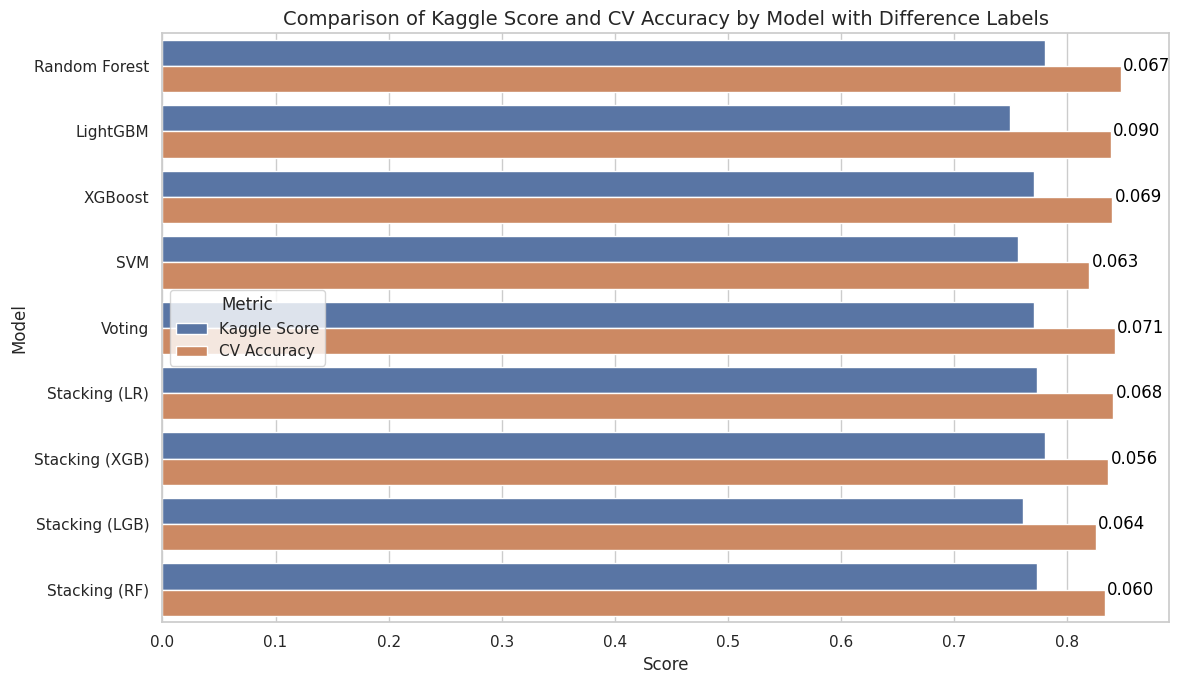

In [ ]:
# モデル性能データの準備
data = {
    "Model": [
        "Random Forest",
        "LightGBM",
        "XGBoost",
        "SVM",
        "Voting",
        "Stacking (LR)",
        "Stacking (XGB)",
        "Stacking (LGB)",
        "Stacking (RF)"
    ],
    "Kaggle Score": [
        0.77990,
        0.74880,
        0.77033,
        0.75598,
        0.77033,
        0.77272,
        0.77990,
        0.76076,
        0.77272
    ],
    "CV Accuracy": [
        0.847363,
        0.838384,
        0.839506,
        0.819304,
        0.841751,
        0.840629,
        0.836139,
        0.824916,
        0.832772
    ]
}

df = pd.DataFrame(data)

# 差分計算
df["Difference"] = df["CV Accuracy"] - df["Kaggle Score"]

# melt処理でSeaborn用データ整形
df_plot = df.melt(id_vars="Model", value_vars=["Kaggle Score", "CV Accuracy"],
                  var_name="Metric", value_name="Score")

# 可視化
plt.figure(figsize=(12, 7))
sns.set(style="whitegrid")
barplot = sns.barplot(data=df_plot, x="Score", y="Model", hue="Metric")

# 差分のラベルを追加
for index, row in df.iterrows():
    plt.text(
        row["CV Accuracy"] + 0.002,
        index,
        f'{row["Difference"]:.3f}',
        color='black',
        va='center'
    )

plt.title("Comparison of Kaggle Score and CV Accuracy by Model with Difference Labels", fontsize=14)
plt.xlabel("Score")
plt.ylabel("Model")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

### 📊 Model Performance Comparison / モデル性能比較（CV vs Kaggle）


| ✅ **Model / モデル名** | 📈 **CV Accuracy** | 🏅 **Kaggle Score** | 📉 **Gap / 乖離** | 📝 **Notes / コメント**                                            |
| ------------------ | ------------------ | ------------------- | --------------- | -------------------------------------------------------------- |
| Random Forest      | 0.847              | 0.7799              | 0.0675          | ⚠️ High accuracy but gap indicates overfitting / 高精度だが過学習の懸念あり |
| LightGBM           | 0.838              | 0.7488              | 0.0896          | ⚠️ Fast but shows significant drop / 高速だがCVとの乖離が大きい            |
| XGBoost            | 0.840              | 0.7703              | 0.0692          | ✅ Balanced performance / バランスの良い性能                             |
| SVM                | 0.819              | 0.7559              | 0.0633          | 🧭 Moderate generalization / まずまずの汎化性能                         |
| Voting             | 0.842              | 0.7703              | 0.0715          | ❗ Stable but gap exists / 安定性はあるが乖離あり                          |
| Stacking (LR)      | 0.841              | 0.7727              | 0.0680          | 📊 Interpretability with decent generalization / 解釈性とそこそこの汎化性能 |
| Stacking (XGB)     | 0.836              | 0.7799              | 0.0562          | ✅ Best consistency across metrics / 最も安定したモデル                  |
| Stacking (LGB)     | 0.825              | 0.7608              | 0.0642          | ⚙️ Improvement from base LGB / 単体LGBより改善                       |
| Stacking (RF)      | 0.833              | 0.7727              | 0.0603          | 🌳 Stable stacking performance / 安定したスタッキング性能                  |



### Conclusion / 結論：
Although the tuned Random Forest achieved the highest cross-validation accuracy (0.8474), its relatively large gap with the Kaggle score (0.7799) suggests potential overfitting. This makes it a risky choice as the final model, especially for deployment or unseen data.
On the other hand, the Stacking model with XGBoost as meta-learner showed a smaller performance gap and consistent scores across validation and Kaggle.
Therefore, it is safer and more reliable to select the Stacking (XGBoost meta) model as the final choice.  

チューニング済みのランダムフォレストは交差検証で最高の精度（0.8474）を示しましたが、Kaggleスコア（0.7799）との乖離が大きく、過学習の可能性が示唆されます。そのため、未知データや本番運用を想定した場合、最終モデルとして選ぶにはややリスクがあります。
一方で、XGBoostをメタモデルに使用したスタッキングモデルは、CVスコアとKaggleスコアの差が小さく、より一貫した安定した性能を示しました。
したがって、最終モデルとしては Stacking (XGBoost meta) を選択するのが安全で信頼性が高いと言えます。

## 7 📤 Final Submission Code / 最終提出用コード

This section generates the final prediction file (`submission_final.csv`) using the best-performing model from our comparisons.  
以下は、モデル比較の結果最も性能が良かったモデルを使って、Kaggle に提出する予測ファイル（`submission_final.csv`）を作成するコードです。


In [ ]:
# =====================================================
# 1. Prepare test data / テストデータの特徴量を準備
# ※ df_test に必要な前処理（欠損処理・特徴量変換）が済んでいる前提です
# =====================================================
X_test_selected = df_fe4_test[selected_features]  # test.csvと同様の特徴量セットを使用
passenger_ids = df_test['PassengerId']  # Kaggle 提出用の ID カラム

# =====================================================
# 2. Make predictions / 予測を実行
# =====================================================
y_test_pred = best_model_stacking_XGB_tuned.predict(X_test_selected)

# =====================================================
# 3. Create submission DataFrame / 提出用のデータフレームを作成
# =====================================================
submission = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Survived': y_test_pred
})

# =====================================================
# 4. Save to CSV / CSVファイルとして保存（Kaggleに提出可能）
# =====================================================
submission.to_csv('submission_final.csv', index=False)
print("✅ submission.csv has been saved!")


# Colabの場合、自動でダウンロード（必要に応じて）
from google.colab import files
files.download('submission_final.csv.csv')

✅ submission.csv has been saved!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 6 ✅ Final Model Recommendation Report / 最終モデル推薦レポート

### 🏆 Selected Model / 選定モデル  
**Stacking (XGB meta)**

---

### ✅ Reason for Selection / 選定理由

- Consistent performance across both CV and Kaggle leaderboard  
- High ROC AUC and F1 score, indicating strong classification balance  
- Although it requires longer training (1.84 sec) and prediction time (9.37 sec) compared to others, its superior generalization and stability outweigh the computational cost  

- CVとKaggleスコアの両方で安定した性能  
- ROC AUCやF1スコアも高く、バランスの取れた分類性能  
- 学習時間は1.84秒、推論時間は9.37秒と他モデルより長いですが、安定した性能がそれを補っています

---

### 📉 Alternative Models Considered / 他に検討したモデル

- **Random Forest**: Highest CV accuracy but larger gap with Kaggle score, suggesting overfitting. Training time 0.57 sec, prediction time 5.78 sec.  
- **XGBoost**: Strong and fast, with training time 0.23 sec and prediction time 0.73 sec, but slightly outperformed by Stacking (XGB) in generalization  
- **Voting**: Good accuracy but larger variation and weaker test set performance. Training and prediction times are relatively low (0.51 sec and 2.07 sec), making it suitable for faster inference scenarios despite slightly lower stability.  

- **Random Forest**：CV精度が最も高いが、Kaggleとの乖離が大きく過学習の懸念あり（学習0.57秒、推論5.78秒）  
- **XGBoost**：安定性は高く予測も高速（学習0.23秒、推論0.73秒）だが、Stackingの方が総合的に優れていた  
- **Voting**：高精度だが、やや汎化性能が劣る。学習0.51秒、推論2.07秒と高速で、推論速度を重視する場合に適している  

---

### 📊 Summary Table / サマリー表（抜粋）

| Model               | CV Accuracy | Kaggle Score | Gap    | Train Time | Predict Time |
|---------------------|-------------|---------------|--------|-------------|---------------|
| Stacking (XGB meta) | 0.836       | 0.7799        | 0.0562 | 1.84 sec    | 9.37 sec      |
| Random Forest       | 0.847       | 0.7799        | 0.0675 | 0.57 sec    | 5.78 sec      |
| Voting              | 0.842       | 0.7703        | 0.0715 | 0.51 sec    | 2.07 sec      |

---

### 🟢 Final Recommendation / 最終推薦

> **Deploy Stacking (XGB meta)** as the final model for its excellent generalization and consistent performance across all metrics.  
> **採用モデル：Stacking (XGB meta)**  
> 理由：精度、汎化性能、安定性、Kaggleとの一致性において最もバランスが良かったため。

---


## 8🎯 SHAP-Based Model Contribution (Meta Model: XGBoost) / SHAPによるベースモデルの貢献度分析（メタモデル：XGBoost）  

We analyzed the importance of each base model’s predictions using SHAP values from the final meta-model (XGBoost) in the stacking ensemble.

スタッキングのメタモデル（XGBoost）に対し、各ベースモデルの予測値がどれほど重要だったかをSHAP値で評価しました。

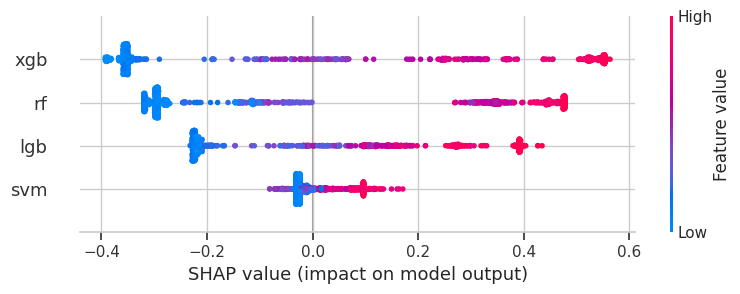

🧭 Mean SHAP Value (Importance) per Base Model / 各ベースモデルの平均SHAP値（重要度）:
rf: 0.3067
xgb: 0.3570
lgb: 0.2203
svm: 0.0418


In [ ]:
# ===========================================
# Step 1: Prepare base model predictions
# ステップ1：各ベースモデルの予測値（生存確率）を計算
# These will be used as input features for the meta-model
# → メタモデル（XGBoost）の入力特徴量となります
# ===========================================
base_preds = []

# Get base model names
model_names = list(best_model_stacking_XGB_tuned.named_estimators_.keys())

# For each base model, get the predicted probability for class 1 (Survived)
# 各ベースモデルに対して、生存クラス（クラス1）の予測確率を取得
for name, model in best_model_stacking_XGB_tuned.named_estimators_.items():
    # Use predict_proba (SVM pipeline is already calibrated)
    preds = model.predict_proba(X_selected)[:, 1]
    base_preds.append(preds)

# ===========================================
# Step 2: Stack predictions as meta-features
# ステップ2：予測値を列方向に結合して、メタモデルの入力特徴量を作成
# Shape will be (n_samples, n_base_models)
# → (サンプル数, ベースモデル数)の2次元配列になります
# ===========================================
meta_features = np.column_stack(base_preds)

# ===========================================
# Step 3: Create SHAP explainer for the meta-model
# ステップ3：メタモデル（XGBoost）用のSHAP Explainerを作成
# ===========================================
explainer_meta = shap.Explainer(best_model_stacking_XGB_tuned.final_estimator_)

# ===========================================
# Step 4: Calculate SHAP values for meta-model inputs
# ステップ4：メタモデルに対するSHAP値を計算
# → 各ベースモデルの予測が、スタック予測にどれだけ貢献しているかを分析
# ===========================================
shap_values_meta = explainer_meta(meta_features)

# ===========================================
# Step 5: Plot SHAP summary plot
# ステップ5：SHAPサマリープロットで視覚化
# → 各ベースモデルの「平均的な重要度」を可視化
# ===========================================
shap.summary_plot(shap_values_meta, features=meta_features, feature_names=model_names)

# ===========================================
# Step 6: Print mean absolute SHAP values
# ステップ6：各特徴量（ベースモデル）の平均SHAP値を数値で表示
# → グラフだけでなく、数値でも比較可能にします
# ===========================================
print("🧭 Mean SHAP Value (Importance) per Base Model / 各ベースモデルの平均SHAP値（重要度）:")
mean_abs_shap = np.abs(shap_values_meta.values).mean(axis=0)

for name, val in zip(model_names, mean_abs_shap):
    print(f"{name}: {val:.4f}")



#### 🧭 Mean SHAP Values (Model Importance) / 平均SHAP値（モデルの重要度）

| Base Model | SHAP Importance | Interpretation / 解釈 |
|------------|------------------|------------------------|
| XGBoost (`xgb`) | 0.3570 | ⭐ Most important contributor to final predictions / 最も予測に貢献 |
| Random Forest (`rf`) | 0.3067 | 🔸 Strong contribution / 強い影響あり |
| LightGBM (`lgb`) | 0.2203 | ⚠️ Moderate impact / 中程度の貢献 |
| SVM (`svm`) | 0.0418 | 🔻 Minimal influence / ほとんど影響なし |

This analysis confirms that the meta-model heavily relied on XGBoost and Random Forest to make its final decisions.  

この結果から、メタモデルはXGBoostとRandom Forestの出力を主に信頼していたことがわかります。


### Model Contribution Analysis Based on SHAP Values / SHAP値に基づくモデル貢献度の分析

The SHAP summary plot shows the contribution of each base model to the final stacked prediction. Among the base models, XGBoost has the highest mean SHAP value (0.357), followed by Random Forest (0.307), LightGBM (0.220), and SVM (0.042).

This suggests that the meta-model relies most heavily on the tree-based models (XGBoost, Random Forest, LightGBM) for its predictions. The relatively low contribution of SVM may be due to its linear nature, which limits its ability to capture complex nonlinear relationships in the data. Moreover, since the SVM is calibrated, its predicted probabilities are expected to be reliable but may lack the expressive power of tree-based models.

Therefore, combining diverse model types in stacking leverages their complementary strengths: tree models capture nonlinearities well, while SVM provides a linear perspective. The meta-model effectively weights these contributions to improve overall prediction accuracy.

---

SHAPサマリープロットは、最終的なスタッキング予測に対する各ベースモデルの貢献度を示しています。ベースモデルの中では、XGBoostが最も高い平均SHAP値（0.357）を持ち、次いでランダムフォレスト（0.307）、LightGBM（0.220）、SVM（0.042）となっています。

これはメタモデルが主に木構造ベースのモデル（XGBoost、ランダムフォレスト、LightGBM）に依存していることを示唆しています。一方で、SVMの貢献度が低い理由は、線形モデルであるため複雑な非線形関係を捉えにくいことに起因していると考えられます。SVMは確率キャリブレーションを施しているため、予測確率の信頼性は高いものの、表現力では木構造モデルに劣る可能性があります。

したがって、スタッキングにおいて多様なモデルを組み合わせることで、それぞれの強みを活かしています。木構造モデルは非線形性をよく捉え、SVMは線形性を補完する役割を果たしています。メタモデルはこれらの寄与度をうまく加重し、全体の予測精度を向上させています。



# 9 🔍 Final Model Analysis / 最終モデルの評価と考察

In this section, I summarize the performance of the final stacking model using both quantitative metrics and model interpretation techniques.
Cross-validation scores are analyzed alongside SHAP values to evaluate which base models contributed most to the final prediction.
This analysis helps assess the model’s strengths and limitations, especially in handling class imbalance.

このセクションでは、最終的に採用したスタッキングモデルの性能を、定量的な評価指標とモデル解釈の観点から総括します。
交差検証のスコアに加えてSHAP値を用いることで、どのベースモデルが最終予測に最も貢献しているかを可視化し、
モデルの強みと課題（特にクラス不均衡への対応）について考察を行います。
---

### ✅ 1. Model Performance Summary / モデルの性能評価

| Metric / 指標            | Value / 値  |
|--------------------------|-------------|
| 🎯 Mean CV Accuracy      | **0.836**   |
| 📈 Mean CV ROC AUC       | **0.874**   |

📋 **Classification Report (CV predictions) / 分類レポート（交差検証）:**

| Class / クラス | Precision | Recall | F1-score |
|----------------|-----------|--------|----------|
| 0 (Not Survived / 非生存) | 0.84 | 0.90 | 0.87 |
| 1 (Survived / 生存)       | 0.82 | 0.73 | 0.77 |

🗣️ **Interpretation / 解釈:**
- The model predicts non-survivors well, with high recall (0.90).  
- Survivor recall (0.73) is lower, indicating some survivors are missed.
- モデルは非生存者の予測精度が高く、再現率（Recall）が0.90と優れている。
- 一方、生存者のRecallが0.73と低めで、一部の生存者を見逃している可能性がある。

---

### 📊 2. SHAP-Based Contribution of Base Models / SHAPによるベースモデルの重要度分析

| Base Model | Mean SHAP Value / 平均SHAP値 |
|------------|-------------------------------|
| XGBoost    | **0.3570**                    |
| RandomForest | **0.3067**                  |
| LightGBM   | **0.2203**                    |
| SVM        | **0.0418**                    |

🧠 **Discussion / 考察:**
- XGBoost and RandomForest had the highest SHAP importance → strong contribution to final prediction.  
- These models handle non-linear relationships well, which fits the Titanic dataset.  
- SVM had the lowest contribution, likely because it is linear and cannot capture complex patterns.  
- Therefore, tree-based models are better suited for this task.

-  XGBoostとRandomForestのSHAP値が最も高く、最終予測への貢献が大きいとわかる。
- これらのモデルは非線形構造に強く、Titanicのような複雑なデータに適している。
-  SVMは線形モデルであるため、複雑な構造を捉えにくく、貢献度が低かったと考えられる。
-  よって、ツリー系モデルがこの問題にはより適していると結論づけられる。

---

### 📝 3. Conclusion / 結論

📌 The stacking model with XGBoost meta-learner performs well overall, but recall for survivors can be improved.  
📌 XGBoostをメタ学習器に使ったスタッキングモデルは全体として高性能だが、生存者のRecallは改善の余地がある。

📈 **Possible improvements / 改善の方向性:**
- Class balancing (e.g. SMOTE) or class weight tuning may improve recall for minority class (survivors).  
- Base model selection can be further optimized.  
-   クラス不均衡への対応（例：SMOTE）やクラス重み調整でRecallを改善できる可能性がある。
- ベースモデルの構成や選定を見直すことで、さらなる性能向上が期待できる。

---

### 🌍 Summary / まとめ

- Final stacking model (meta: XGBoost) achieves **83.6% accuracy** and **87.4% ROC AUC**.
- SHAP analysis shows strongest contributions from XGBoost and RandomForest.
- SVM has low impact, likely due to its linear nature.
- Overall strong performance, with room to improve recall for class 1.

- 最終的なスタッキングモデル（メタモデル：XGBoost）は、**正解率 83.6%**、**ROC AUC 87.4%** を達成しました。  
- SHAP解析によれば、**XGBoostとRandomForestが最も大きな貢献**をしていることが分かりました。  
- **SVMの貢献度は低く**、これは線形モデルであるため複雑なパターンを捉えにくいことが原因と考えられます。  
- **全体として性能は高いですが、生存者（クラス1）のRecallには改善の余地**があります。


# 10 📌 Conclusion / 結論  

In this final section, I summarize the overall approach, results, key insights, and areas for future improvement based on the Titanic survival prediction project.
This reflection highlights what was learned through model development, evaluation, and interpretation.

この最終セクションでは、Titanic生存予測プロジェクトにおけるアプローチ、結果、得られた知見、今後の改善点について総括します。
モデル構築から評価・解釈に至るまでの一連の過程を振り返り、得られた学びを明確にします。

🎯 **Objective**  
The goal of this project was to predict passenger survival on the Titanic using machine learning.  
本プロジェクトの目的は、Titanic乗客の生存を機械学習で予測することでした。

🔧 **Approach**  
- Data preprocessing (missing value imputation, feature engineering, encoding)  
- Built and tuned base models: RandomForest, XGBoost, LightGBM, and a calibrated SVM  
- Combined all models using stacking, with XGBoost as the meta-learner  
データの前処理（欠損値補完、特徴量エンジニアリング、カテゴリ変換）を行い、  
RandomForest、XGBoost、LightGBM、SVMなどのモデルを構築・チューニングし、  
それらをXGBoostメタモデルでスタッキングしました。

📈 **Results**  
- Final stacking model achieved **83.6% accuracy** and **87.4% ROC AUC**  
- SHAP analysis showed that XGBoost and RandomForest had the highest impact  
- SVM contributed the least, likely due to its linear nature  
最終的なスタッキングモデルは**正解率83.6%**、**ROC AUCは87.4%**を記録しました。  
SHAP分析の結果、XGBoostとRandomForestが最も大きな影響を持ち、  
線形モデルであるSVMは、貢献度が比較的低いことが分かりました。

🧠 **Insights**  
- Tree-based models handled complex, non-linear patterns better in the Titanic dataset  
- Linear models like SVM may be less effective in such settings  
ツリー系モデルはTitanicのような複雑で非線形なパターンに強く、  
SVMのような線形モデルはそのようなデータには不向きであることが示されました。

🚀 **Future Work**  
- Improve recall for the minority class (survivors) using techniques like SMOTE or class weighting  
- Consider adding more features or optimizing base model selection  
少数クラス（生存者）のRecallを改善するには、SMOTEなどの手法やクラス重みの調整が有効です。  
また、特徴量の追加やベースモデルの選定や構成の最適化も今後の改善ポイントです。

🧾 **Summary**  
This project demonstrated that stacking ensemble models—combined with SHAP for interpretability—can achieve strong predictive performance on classification tasks like Titanic survival.  
本プロジェクトでは、スタッキングとSHAPによる説明可能性を活用することで、Titanic生存予測のような分類タスクで高精度な予測が可能であることを示しました。
